# Execute the trained model (WSI level)

In [3]:
from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


dataset_dir = "../../datasets/CAMELYON16"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "Epoch-10_Images-109278_Batch-1"
trained_model_path="{}/{}".format(model_dir, 'OCDC+CAMELYON16__Size-{}x{}_{}.pth'.format(patch_size[0], patch_size[1], trained_model_version))
model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)


if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:
    
    dataset_type = "testing"
    classes = ["tumor", "normal"]
    for cls in classes:

        camelyon16_dir = "../../datasets/CAMELYON16"
        annotations_dir = "{}/{}/lesion_annotations".format(camelyon16_dir, dataset_type)
        wsi_images_dir = "{}/{}/{}/wsi".format(camelyon16_dir, dataset_type, cls)
        patch_images_dir = "{}/{}/{}/patch/640x640".format(camelyon16_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(camelyon16_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(camelyon16_dir, trained_model_version, dataset_type, cls)
        
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".tif", "")

                file_is_tif = wsi_image_file.lower().endswith('.tif')
                if file_is_tif:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists(dir_to_save):
                        os.makedirs("{}/{}".format(wsi_images_results_dir, wsi_image_number))
                        os.makedirs("{}/01-unet_result".format(dir_to_save))
                        
                    # scale down image
                    pil_scaled_down_image, scale = scale_down_camelyon16_img(wsi_image_file, magnification)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)

                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    # run the model
                    count_tiles = 0
                    count_roi_tiles = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        if color != GREEN_COLOR:

                            count_tiles += 1

                            r_s = row * tile_size
                            r_e = r_s + tile_size
                            c_s = column * tile_size
                            c_e = c_s + tile_size
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

                            # only tile with valid size
                            if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                                # read the tile from the original wsi image
                                pil_input_tile, np_input_tile = read_region(wsi_image_file, column, row, magnification, tile_size)

                                # run the model
                                if color_model == "LAB":
                                    np_input_tile = rgb_to_lab(np_input_tile)

                                X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float()
                                X = Variable(X.unsqueeze(0)).to(device) if use_cuda else X.unsqueeze(0)
                                y_hat = model(X).detach().cpu().squeeze(0)
                                #y_hat = model(X).squeeze(0)
                                output_tile = y_hat[0]
                                np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                                #

                                # only tiles that something was found by model
                                if np.any(np.unique(np_output_tile >= 0.1)):

                                    # save the output image-patch results
                                    utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                                    np_output_tile[np_output_tile > 0] = 1
                                    count_roi_tiles += 1

                    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
                    logger.info("-")

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                        

2020-12-31 17:13:53,621 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/HumanOralTissues+CAMELYON16__Size-640x640_Epoch-10_Images-109278_Batch-1.pth
2020-12-31 17:13:53,633 :: INFO <module> :: Processing wsi 'test_001.tif'
2020-12-31 17:13:54,182 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'test_001.tif'
2021-01-01 04:43:12,745 :: INFO <module> :: 	 '3615/4265/18900' tiles identified as ROI by model
2021-01-01 04:43:12,791 :: INFO <module> :: -
2021-01-01 04:43:14,507 :: INFO <module> :: Processing wsi 'test_003.tif'
2021-01-01 04:43:16,008 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'test_003.tif'
2021-01-01 12:20:23,371 :: INFO <module> :: 	 '1969/2845/52938' tiles identified as ROI by model
2021-01-01 12:20:23,379 :: INFO <module> :: -


# Generate the heatmaps (WSI level)

2021-01-02 12:10:56,802 :: INFO <module> :: Segmenting wsi image: 'test_001.tif'
2021-01-02 12:12:16,461 :: INFO <module> :: 	 '3607' tiles identified as ROI after post processing
2021-01-02 12:12:16,462 :: INFO <module> :: -
2021-01-02 12:12:27,323 :: INFO <module> :: Segmenting wsi image: 'test_003.tif'
2021-01-02 12:13:15,070 :: INFO <module> :: 	 '1969' tiles identified as ROI after post processing
2021-01-02 12:13:15,071 :: INFO <module> :: -


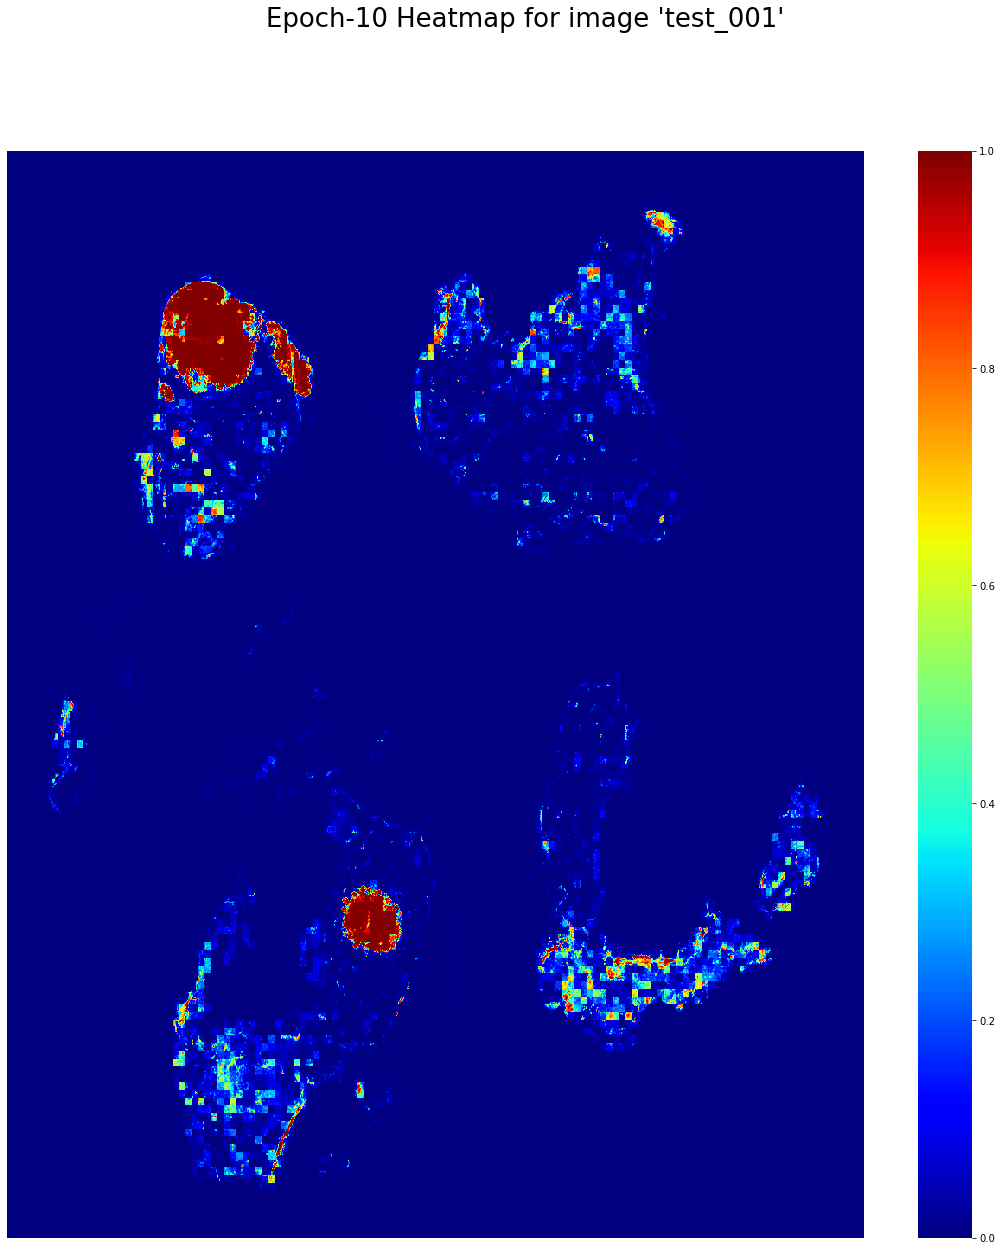

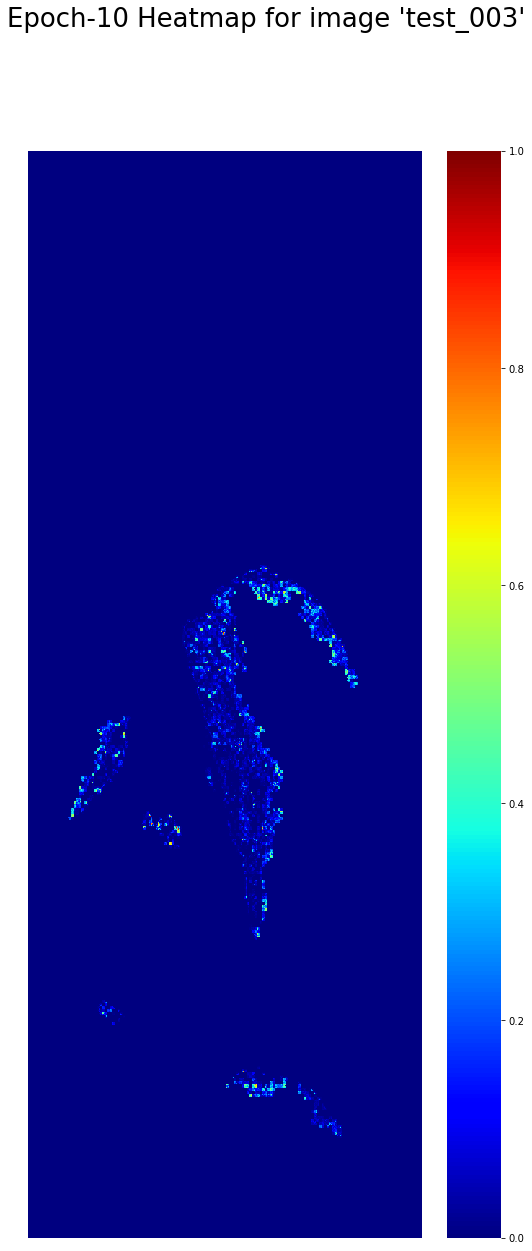

In [2]:
from sourcecode.wsi_image_utils import *

import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils


dataset_dir = "../../datasets/CAMELYON16"
model_dir = "../../models"
trained_model_version = "Epoch-10_Images-109278_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)


dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    camelyon16_dir = "../../datasets/CAMELYON16"
    annotations_dir = "{}/{}/lesion_annotations".format(camelyon16_dir, dataset_type)
    wsi_images_dir = "{}/{}/{}/wsi".format(camelyon16_dir, dataset_type, cls)
    patch_images_dir = "{}/{}/{}/patch/640x640".format(camelyon16_dir, dataset_type, cls)
    patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(camelyon16_dir, trained_model_version, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(camelyon16_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".tif", "")

            file_is_tif = wsi_image_file.lower().endswith('.tif')
            if file_is_tif:

                logger.info("Segmenting wsi image: '{}'".format(wsi_file))
                unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, wsi_image_number)
                if not os.path.exists(unet_results_dir):
                    logger.info("\t This WSI image was not processed by our fcn based method yet.")
                    logger.info("\t {}".format(unet_results_dir))
                    continue
                
                original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                pil_original_image = load_pil_image(original_img_path, gray=False)
                np_scaled_down_image = pil_to_np(pil_original_image)

                # fcn roi identification
                count_tiles = 0
                np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
                np_tissue_roi = np.zeros_like(np_scaled_down_image)
                for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
                    for unet_tile_image_file in sorted(unet_tile_files):
                        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

                            # load the unet image-patch result
                            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
                            np_tile_unet = np_tile_unet * (1.0/255)
                            np_tile_unet[np.isnan(np_tile_unet)] = 0

                            # check if exists values greather than 0.x
                            if np.any(np.unique(np_tile_unet > 0.1)):

                                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                                row = int(aux_row_column[0].replace("r", ""))
                                column = int(aux_row_column[-1])

                                r_s = row * tile_size
                                r_e = r_s + tile_size
                                c_s = column * tile_size
                                c_e = c_s + tile_size
                                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                                tissue_area = tissue_percent(np_tile_unet)
                                if tissue_area > 1:

                                    count_tiles += 1

                                else:
                                    np_heatmap[r_s:r_e, c_s:c_e] = 0

                logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
                logger.info("-")
                
                f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
                f.suptitle("{} Heatmap for image '{}'".format(trained_model_version.split("_")[0], wsi_image_number), fontsize=26)

                ax1 = f.add_subplot(111)
                sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

                f.savefig(original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap.png".format(wsi_image_number)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap)), original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap_gray.png".format(wsi_image_number)))

# Generate the lesion localization points (WSI level)

In [4]:
from wsi_image_utils import *

import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils

from scipy import ndimage as nd
from skimage import measure


dataset = "testing"
camelyon16_dir = "/media/dalifreire/CCB60537B6052394/Users/Dali/Downloads/CAMELYON16"
camelyon16_dir_results = "/media/dalifreire/HD1/DALI/HumanOralDataset+CAMELYON16"
evaluation_masks_dir = "{}/testing/evaluation_masks".format(camelyon16_dir)
wsi_images_list = None
#[
    #"test_003",
    #"test_018",
    
    #"test_002",
    #"test_016",
    #"test_027"
#]

tile_size=20
magnification=0.625
scale = get_scale_by_magnification(magnification)
tile_size_original = int(scale * tile_size)


threshold_prob = 0.99
threshold_itc = 200/(0.243 * pow(2, 5))


trained_model_version = "Epoch-10_Images-109278_Batch-1"
results_base_dir="{}/results/{}".format(camelyon16_dir_results, trained_model_version)

classes = ["tumor", "normal"]
for cls in classes:
        
    class_dir = "{}/{}/{}".format(camelyon16_dir, dataset, cls)
    wsi_images_dir = "{}/wsi".format(class_dir)
    
    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".tif", "")
            
            #if int(wsi_image_number.split("_")[1]) != 1:
            #    continue
                
            file_is_tif = wsi_image_file.lower().endswith('.tif')
            file_in_image_list = file_is_tif and False if wsi_images_list is None else wsi_images_list.count(wsi_image_number) > 0
            if file_is_tif if wsi_images_list is None else file_in_image_list:

                print("Generating the lesion localization points for wsi image: '{}'".format(wsi_file))

                heatmap_gray_path = "{}/tiles/640x640/{}/{}_heatmap_gray.png".format(results_base_dir, wsi_image_number, wsi_image_number)
                if not os.path.exists(heatmap_gray_path):
                    print("\t This original WSI image was not processed yet.")
                    print(heatmap_gray_path)
                    continue

                np_heatmap_gray = load_np_image(heatmap_gray_path, color_model="GRAY") * (1.0/255)
                np_heatmap_points = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                np_heatmap_convex = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))

                seg_threshold_img = basic_threshold(np_heatmap_gray, threshold=threshold_prob, output_type="uint8")
                seg_threshold_img = nd.morphology.binary_fill_holes(seg_threshold_img)
                
                seg_threshold_img_labels = measure.label(seg_threshold_img, connectivity=2)
                seg_threshold_img = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                seg_threshold_img[seg_threshold_img_labels > 0] = 1
                utils.save_image(TF.to_tensor(np_to_pil(seg_threshold_img)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}".format(threshold_prob)))
                
                properties = measure.regionprops(seg_threshold_img_labels)
                
                csv_file_path = "{}/wsi_level/threshold_{}/{}.csv".format(results_base_dir, threshold_prob, wsi_image_number)
                with open(csv_file_path, mode='w') as result_file:

                    result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    
                    labels = np.unique(seg_threshold_img_labels)
                    for idx in range(1, np.max(seg_threshold_img_labels)):

                        label = labels[idx]
                        centroid = (int(properties[idx-1].centroid[0]), int(properties[idx-1].centroid[1]))
                        major_axis_length = properties[idx-1].major_axis_length
                        
                        if major_axis_length > threshold_itc:

                            hull = properties[idx-1].convex_image
                            bbox = properties[idx-1].bbox
                            mean_intensity = np.mean(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            max_intensity = np.max(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            centroid_intensity = np_heatmap_gray[centroid[0], centroid[1]]
                            
                            prob = max_intensity
                            if prob > 0.0:
                                #print("   {:04.2f}, {}, {}".format(prob, centroid[1], centroid[0]))
                                result_writer.writerow(["{:04.2f}".format(prob), centroid[1], centroid[0]])
                                np_heatmap_points[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 1
                                np_heatmap_convex[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True] = 1
                                np_heatmap_convex[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 0.5
                        
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_points)), heatmap_gray_path.replace("_gray", "_points"))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_convex)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}_convex".format(threshold_prob)))

Generating the lesion localization points for wsi image: 'test_001.tif'
Generating the lesion localization points for wsi image: 'test_002.tif'
Generating the lesion localization points for wsi image: 'test_004.tif'
Generating the lesion localization points for wsi image: 'test_008.tif'
Generating the lesion localization points for wsi image: 'test_010.tif'
Generating the lesion localization points for wsi image: 'test_011.tif'
Generating the lesion localization points for wsi image: 'test_013.tif'
Generating the lesion localization points for wsi image: 'test_016.tif'
Generating the lesion localization points for wsi image: 'test_021.tif'
Generating the lesion localization points for wsi image: 'test_026.tif'
Generating the lesion localization points for wsi image: 'test_027.tif'
Generating the lesion localization points for wsi image: 'test_029.tif'
Generating the lesion localization points for wsi image: 'test_030.tif'
Generating the lesion localization points for wsi image: 'test_0

Generating the lesion localization points for wsi image: 'test_109.tif'
Generating the lesion localization points for wsi image: 'test_111.tif'
Generating the lesion localization points for wsi image: 'test_112.tif'
Generating the lesion localization points for wsi image: 'test_115.tif'
Generating the lesion localization points for wsi image: 'test_118.tif'
Generating the lesion localization points for wsi image: 'test_119.tif'
Generating the lesion localization points for wsi image: 'test_120.tif'
Generating the lesion localization points for wsi image: 'test_123.tif'
Generating the lesion localization points for wsi image: 'test_124.tif'
Generating the lesion localization points for wsi image: 'test_125.tif'
Generating the lesion localization points for wsi image: 'test_126.tif'
Generating the lesion localization points for wsi image: 'test_127.tif'
Generating the lesion localization points for wsi image: 'test_128.tif'
Generating the lesion localization points for wsi image: 'test_1

# Execute the trained model (image-patch level)

In [1]:
from train import *
from camelyon16_dataloader import *

import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision import utils
from datetime import datetime

batch_size = 1
patch_size = (640, 640)
color_model = "LAB"
model_dir = "models"
dataset_dir = "/media/dalifreire/CCB60537B6052394/Users/Dali/Downloads/CAMELYON16"
dataloaders = create_dataloader(tile_size="{}x{}".format(patch_size[0], patch_size[1]),
                                batch_size=batch_size, 
                                shuffle=False,
                                img_input_size=patch_size,
                                img_output_size=patch_size,
                                dataset_dir=dataset_dir,
                                color_model=color_model)
dataset_train_size = len(dataloaders['train'].dataset)
dataset_test_size = len(dataloaders['test'].dataset)
print("-")

# Checking for GPU availability
use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
print('Runing on: {}'.format(device))

# load our u-net based model
epochs = "10"
trained_model_version = "Epoch-{}_Images-109278_Batch-1".format(epochs)
trained_model_path = "{}/{}".format(model_dir, 'HumanOralTissues+CAMELYON16__Size-{}x{}_{}.pth'.format(patch_size[0], patch_size[1], trained_model_version))
model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)


# results dir
results_dir = "/media/dalifreire/HD1/DALI/HumanOralDataset+CAMELYON16/results/Epoch-{}_Images-109278_Batch-1/{}_{}x{}".format(epochs, color_model, patch_size[0], patch_size[1])
results_output_dir = "{}/01-output".format(results_dir)
results_roi_dir = "{}/02-roi".format(results_dir)
if not os.path.exists(results_dir):
    print("Creating folder to save output results")
    os.makedirs(results_output_dir)
    os.makedirs(results_roi_dir)

for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
        
    X = Variable(images).to(device) if use_cuda else images
    print('Batch {}: {}/{} images: {} masks: {} {}'.format(
        (batch_idx+1), 
        (batch_idx+1) * len(images), 
        len(dataloaders['test'].dataset),
        images.shape,
        masks.shape,
        datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
    
    
    #X_numpy = X.cpu().numpy()
    y_hat = model(X).detach().cpu().squeeze(0)
    
    
    input_image = transforms.ToPILImage()(X.squeeze(0).cpu())
    output_mask = basic_threshold(y_hat[0].detach().cpu().numpy(), threshold=0.5, output_type="uint8")
    
    input_image_rgb = lab_to_rgb(pil_to_np(input_image))
    roi_image = blend_image(np_to_pil(input_image_rgb), np_to_pil(output_mask), foreground='red', inverse=True)
    
    
    # save the results
    patch_img_name = fname[0]
    utils.save_image(y_hat[0], '{}/{}'.format(results_output_dir, patch_img_name))
    utils.save_image(TF.to_tensor(roi_image), '{}/{}'.format(results_roi_dir, patch_img_name))

2020-12-17 21:03:36,583 :: INFO load_dataset :: [training] /media/dalifreire/CCB60537B6052394/Users/Dali/Downloads/CAMELYON16/training
2020-12-17 21:04:18,927 :: INFO load_dataset :: [testing] /media/dalifreire/CCB60537B6052394/Users/Dali/Downloads/CAMELYON16/testing
2020-12-17 21:04:48,858 :: INFO create_dataloader :: Train images (640x640): 109278 (augmentation: True)
2020-12-17 21:04:48,859 :: INFO create_dataloader :: Test images (640x640): 43012 (augmentation: False)


-
Runing on: cuda


2020-12-17 21:04:50,843 :: INFO load_checkpoint :: 	 Model loaded on: cuda / 3 / 1 / (640, 640) -> models/HumanOralTissues+CAMELYON16__Size-640x640_Epoch-10_Images-109278_Batch-1.pth


('test_001_r100c52.png',)
Batch 1: 1/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:50
('test_001_r100c53.png',)
Batch 2: 2/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:51
('test_001_r100c54.png',)
Batch 3: 3/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:52
('test_001_r100c55.png',)
Batch 4: 4/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:53
('test_001_r100c56.png',)
Batch 5: 5/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:54
('test_001_r100c57.png',)
Batch 6: 6/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:54
('test_001_r100c58.png',)
Batch 7: 7/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:04:55
('test_001_r100c59.png',)
Batch 8: 8/43012 images: torch.Size([1, 3, 

('test_001_r19c37.png',)
Batch 63: 63/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:39
('test_001_r20c24.png',)
Batch 64: 64/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:40
('test_001_r20c25.png',)
Batch 65: 65/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:41
('test_001_r20c26.png',)
Batch 66: 66/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:41
('test_001_r20c27.png',)
Batch 67: 67/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:42
('test_001_r20c28.png',)
Batch 68: 68/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:43
('test_001_r20c29.png',)
Batch 69: 69/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:05:44
('test_001_r20c30.png',)
Batch 70: 70/43012 images: torch.Size

('test_001_r23c32.png',)
Batch 124: 124/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:25
('test_001_r23c33.png',)
Batch 125: 125/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:26
('test_001_r23c34.png',)
Batch 126: 126/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:27
('test_001_r23c35.png',)
Batch 127: 127/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:28
('test_001_r23c36.png',)
Batch 128: 128/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:29
('test_001_r23c37.png',)
Batch 129: 129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:29
('test_001_r23c38.png',)
Batch 130: 130/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:06:30
('test_001_r23c39.png',)
Batch 131: 131/43012 im

('test_001_r26c33.png',)
Batch 185: 185/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:12
('test_001_r26c34.png',)
Batch 186: 186/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:13
('test_001_r26c35.png',)
Batch 187: 187/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:14
('test_001_r26c36.png',)
Batch 188: 188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:15
('test_001_r26c37.png',)
Batch 189: 189/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:15
('test_001_r26c38.png',)
Batch 190: 190/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:16
('test_001_r26c41.png',)
Batch 191: 191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:17
('test_001_r26c42.png',)
Batch 192: 192/43012 im

('test_001_r29c36.png',)
Batch 246: 246/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:07:59
('test_001_r29c37.png',)
Batch 247: 247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:00
('test_001_r29c44.png',)
Batch 248: 248/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:00
('test_001_r29c45.png',)
Batch 249: 249/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:01
('test_001_r29c46.png',)
Batch 250: 250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:02
('test_001_r29c47.png',)
Batch 251: 251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:03
('test_001_r30c24.png',)
Batch 252: 252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:04
('test_001_r30c25.png',)
Batch 253: 253/43012 im

('test_001_r98c55.png',)
Batch 307: 307/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:46
('test_001_r98c56.png',)
Batch 308: 308/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:47
('test_001_r98c57.png',)
Batch 309: 309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:48
('test_001_r98c58.png',)
Batch 310: 310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:48
('test_001_r98c59.png',)
Batch 311: 311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:49
('test_001_r98c60.png',)
Batch 312: 312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:50
('test_001_r98c61.png',)
Batch 313: 313/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:08:51
('test_001_r99c52.png',)
Batch 314: 314/43012 im

('test_002_r257c53.png',)
Batch 367: 367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:31
('test_002_r257c54.png',)
Batch 368: 368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:32
('test_002_r257c55.png',)
Batch 369: 369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:33
('test_002_r257c56.png',)
Batch 370: 370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:33
('test_002_r258c48.png',)
Batch 371: 371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:34
('test_002_r258c49.png',)
Batch 372: 372/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:35
('test_002_r258c50.png',)
Batch 373: 373/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:09:36
('test_002_r258c51.png',)
Batch 374: 374/

('test_002_r284c62.png',)
Batch 427: 427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:16
('test_002_r284c63.png',)
Batch 428: 428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:17
('test_002_r284c64.png',)
Batch 429: 429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:17
('test_002_r284c65.png',)
Batch 430: 430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:18
('test_002_r285c61.png',)
Batch 431: 431/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:19
('test_002_r285c62.png',)
Batch 432: 432/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:20
('test_002_r285c63.png',)
Batch 433: 433/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:10:20
('test_002_r285c64.png',)
Batch 434: 434/

('test_008_r69c44.png',)
Batch 487: 487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:01
('test_008_r72c40.png',)
Batch 488: 488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:02
('test_010_r148c25.png',)
Batch 489: 489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:03
('test_010_r149c25.png',)
Batch 490: 490/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:04
('test_010_r149c26.png',)
Batch 491: 491/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:05
('test_010_r230c126.png',)
Batch 492: 492/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:05
('test_010_r230c127.png',)
Batch 493: 493/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:06
('test_010_r231c126.png',)
Batch 494: 494

('test_016_r102c37.png',)
Batch 547: 547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:47
('test_016_r102c38.png',)
Batch 548: 548/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:47
('test_016_r102c39.png',)
Batch 549: 549/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:48
('test_016_r102c40.png',)
Batch 550: 550/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:49
('test_016_r102c41.png',)
Batch 551: 551/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:50
('test_016_r102c42.png',)
Batch 552: 552/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:50
('test_016_r102c43.png',)
Batch 553: 553/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:11:51
('test_016_r102c44.png',)
Batch 554: 554/

('test_016_r104c51.png',)
Batch 607: 607/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:31
('test_016_r104c52.png',)
Batch 608: 608/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:31
('test_016_r104c71.png',)
Batch 609: 609/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:32
('test_016_r104c72.png',)
Batch 610: 610/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:33
('test_016_r104c77.png',)
Batch 611: 611/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:34
('test_016_r104c78.png',)
Batch 612: 612/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:34
('test_016_r104c79.png',)
Batch 613: 613/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:12:35
('test_016_r104c80.png',)
Batch 614: 614/

('test_016_r106c48.png',)
Batch 667: 667/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:15
('test_016_r106c49.png',)
Batch 668: 668/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:16
('test_016_r106c50.png',)
Batch 669: 669/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:16
('test_016_r106c51.png',)
Batch 670: 670/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:17
('test_016_r106c52.png',)
Batch 671: 671/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:18
('test_016_r106c53.png',)
Batch 672: 672/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:19
('test_016_r106c70.png',)
Batch 673: 673/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:13:19
('test_016_r106c71.png',)
Batch 674: 674/

('test_016_r107c85.png',)
Batch 727: 727/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:00
('test_016_r107c86.png',)
Batch 728: 728/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:00
('test_016_r107c87.png',)
Batch 729: 729/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:01
('test_016_r107c88.png',)
Batch 730: 730/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:02
('test_016_r107c89.png',)
Batch 731: 731/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:03
('test_016_r107c90.png',)
Batch 732: 732/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:03
('test_016_r108c36.png',)
Batch 733: 733/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:04
('test_016_r108c37.png',)
Batch 734: 734/

('test_016_r109c49.png',)
Batch 787: 787/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:44
('test_016_r109c50.png',)
Batch 788: 788/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:45
('test_016_r109c51.png',)
Batch 789: 789/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:45
('test_016_r109c52.png',)
Batch 790: 790/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:46
('test_016_r109c53.png',)
Batch 791: 791/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:47
('test_016_r109c64.png',)
Batch 792: 792/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:48
('test_016_r109c65.png',)
Batch 793: 793/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:14:48
('test_016_r109c66.png',)
Batch 794: 794/

('test_016_r110c73.png',)
Batch 847: 847/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:28
('test_016_r110c74.png',)
Batch 848: 848/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:29
('test_016_r110c75.png',)
Batch 849: 849/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:30
('test_016_r110c76.png',)
Batch 850: 850/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:31
('test_016_r110c77.png',)
Batch 851: 851/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:31
('test_016_r110c78.png',)
Batch 852: 852/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:32
('test_016_r110c79.png',)
Batch 853: 853/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:15:33
('test_016_r110c80.png',)
Batch 854: 854/

('test_016_r111c83.png',)
Batch 907: 907/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:13
('test_016_r111c84.png',)
Batch 908: 908/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:14
('test_016_r111c85.png',)
Batch 909: 909/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:15
('test_016_r111c86.png',)
Batch 910: 910/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:15
('test_016_r111c87.png',)
Batch 911: 911/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:16
('test_016_r111c88.png',)
Batch 912: 912/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:17
('test_016_r111c89.png',)
Batch 913: 913/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:18
('test_016_r111c90.png',)
Batch 914: 914/

('test_016_r112c92.png',)
Batch 967: 967/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:58
('test_016_r113c35.png',)
Batch 968: 968/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:58
('test_016_r113c36.png',)
Batch 969: 969/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:16:59
('test_016_r113c37.png',)
Batch 970: 970/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:00
('test_016_r113c38.png',)
Batch 971: 971/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:01
('test_016_r113c39.png',)
Batch 972: 972/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:01
('test_016_r113c40.png',)
Batch 973: 973/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:02
('test_016_r113c41.png',)
Batch 974: 974/

('test_016_r114c45.png',)
Batch 1027: 1027/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:42
('test_016_r114c46.png',)
Batch 1028: 1028/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:43
('test_016_r114c47.png',)
Batch 1029: 1029/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:43
('test_016_r114c48.png',)
Batch 1030: 1030/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:44
('test_016_r114c49.png',)
Batch 1031: 1031/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:45
('test_016_r114c50.png',)
Batch 1032: 1032/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:46
('test_016_r114c51.png',)
Batch 1033: 1033/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:17:46
('test_016_r114c52.png',)
B

('test_016_r115c65.png',)
Batch 1086: 1086/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:26
('test_016_r115c66.png',)
Batch 1087: 1087/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:26
('test_016_r115c67.png',)
Batch 1088: 1088/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:27
('test_016_r115c68.png',)
Batch 1089: 1089/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:28
('test_016_r115c69.png',)
Batch 1090: 1090/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:29
('test_016_r115c70.png',)
Batch 1091: 1091/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:29
('test_016_r115c71.png',)
Batch 1092: 1092/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:18:30
('test_016_r115c72.png',)
B

('test_016_r116c77.png',)
Batch 1145: 1145/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:10
('test_016_r116c78.png',)
Batch 1146: 1146/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:11
('test_016_r116c79.png',)
Batch 1147: 1147/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:11
('test_016_r116c80.png',)
Batch 1148: 1148/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:12
('test_016_r116c81.png',)
Batch 1149: 1149/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:13
('test_016_r116c82.png',)
Batch 1150: 1150/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:14
('test_016_r116c83.png',)
Batch 1151: 1151/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:14
('test_016_r116c84.png',)
B

('test_016_r118c39.png',)
Batch 1204: 1204/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:54
('test_016_r118c40.png',)
Batch 1205: 1205/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:55
('test_016_r118c41.png',)
Batch 1206: 1206/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:56
('test_016_r118c42.png',)
Batch 1207: 1207/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:57
('test_016_r118c43.png',)
Batch 1208: 1208/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:57
('test_016_r118c44.png',)
Batch 1209: 1209/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:58
('test_016_r118c45.png',)
Batch 1210: 1210/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:19:59
('test_016_r118c46.png',)
B

('test_016_r119c74.png',)
Batch 1263: 1263/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:38
('test_016_r119c75.png',)
Batch 1264: 1264/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:39
('test_016_r119c76.png',)
Batch 1265: 1265/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:40
('test_016_r119c77.png',)
Batch 1266: 1266/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:41
('test_016_r119c78.png',)
Batch 1267: 1267/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:41
('test_016_r119c85.png',)
Batch 1268: 1268/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:42
('test_016_r119c86.png',)
Batch 1269: 1269/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:20:43
('test_016_r119c87.png',)
B

('test_016_r122c65.png',)
Batch 1322: 1322/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:23
('test_016_r122c66.png',)
Batch 1323: 1323/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:24
('test_016_r122c67.png',)
Batch 1324: 1324/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:25
('test_016_r122c68.png',)
Batch 1325: 1325/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:25
('test_016_r122c69.png',)
Batch 1326: 1326/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:26
('test_016_r122c70.png',)
Batch 1327: 1327/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:27
('test_016_r122c71.png',)
Batch 1328: 1328/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:21:28
('test_016_r122c72.png',)
B

('test_016_r56c18.png',)
Batch 1382: 1382/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:09
('test_016_r56c33.png',)
Batch 1383: 1383/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:10
('test_016_r56c34.png',)
Batch 1384: 1384/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:10
('test_016_r56c7.png',)
Batch 1385: 1385/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:11
('test_016_r56c8.png',)
Batch 1386: 1386/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:12
('test_016_r56c9.png',)
Batch 1387: 1387/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:13
('test_016_r57c10.png',)
Batch 1388: 1388/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:14
('test_016_r57c11.png',)
Batch 1389: 

('test_016_r60c17.png',)
Batch 1442: 1442/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:54
('test_016_r60c18.png',)
Batch 1443: 1443/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:55
('test_016_r60c19.png',)
Batch 1444: 1444/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:56
('test_016_r60c20.png',)
Batch 1445: 1445/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:56
('test_016_r60c21.png',)
Batch 1446: 1446/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:57
('test_016_r60c6.png',)
Batch 1447: 1447/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:58
('test_016_r60c7.png',)
Batch 1448: 1448/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:22:59
('test_016_r60c8.png',)
Batch 1449: 

('test_016_r63c19.png',)
Batch 1502: 1502/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:39
('test_016_r63c20.png',)
Batch 1503: 1503/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:40
('test_016_r63c21.png',)
Batch 1504: 1504/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:41
('test_016_r63c22.png',)
Batch 1505: 1505/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:41
('test_016_r63c23.png',)
Batch 1506: 1506/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:42
('test_016_r63c24.png',)
Batch 1507: 1507/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:43
('test_016_r63c25.png',)
Batch 1508: 1508/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:23:44
('test_016_r63c26.png',)
Batch 150

('test_016_r65c30.png',)
Batch 1562: 1562/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:24
('test_016_r65c31.png',)
Batch 1563: 1563/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:25
('test_016_r65c32.png',)
Batch 1564: 1564/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:25
('test_016_r65c7.png',)
Batch 1565: 1565/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:26
('test_016_r65c8.png',)
Batch 1566: 1566/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:27
('test_016_r65c9.png',)
Batch 1567: 1567/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:28
('test_016_r66c10.png',)
Batch 1568: 1568/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:24:28
('test_016_r66c11.png',)
Batch 1569: 

('test_016_r67c35.png',)
Batch 1622: 1622/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:09
('test_016_r67c36.png',)
Batch 1623: 1623/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:09
('test_016_r67c8.png',)
Batch 1624: 1624/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:10
('test_016_r67c9.png',)
Batch 1625: 1625/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:11
('test_016_r68c10.png',)
Batch 1626: 1626/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:12
('test_016_r68c11.png',)
Batch 1627: 1627/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:13
('test_016_r68c12.png',)
Batch 1628: 1628/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:13
('test_016_r68c13.png',)
Batch 1629:

('test_016_r69c9.png',)
Batch 1682: 1682/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:54
('test_016_r70c10.png',)
Batch 1683: 1683/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:54
('test_016_r70c11.png',)
Batch 1684: 1684/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:55
('test_016_r70c12.png',)
Batch 1685: 1685/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:56
('test_016_r70c13.png',)
Batch 1686: 1686/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:57
('test_016_r70c14.png',)
Batch 1687: 1687/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:58
('test_016_r70c15.png',)
Batch 1688: 1688/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:25:58
('test_016_r70c16.png',)
Batch 1689

('test_016_r72c12.png',)
Batch 1742: 1742/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:38
('test_016_r72c13.png',)
Batch 1743: 1743/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:39
('test_016_r72c14.png',)
Batch 1744: 1744/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:40
('test_016_r72c15.png',)
Batch 1745: 1745/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:40
('test_016_r72c16.png',)
Batch 1746: 1746/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:41
('test_016_r72c17.png',)
Batch 1747: 1747/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:42
('test_016_r72c18.png',)
Batch 1748: 1748/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:26:43
('test_016_r72c19.png',)
Batch 174

('test_016_r74c16.png',)
Batch 1802: 1802/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:23
('test_016_r74c17.png',)
Batch 1803: 1803/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:24
('test_016_r74c18.png',)
Batch 1804: 1804/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:25
('test_016_r74c19.png',)
Batch 1805: 1805/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:25
('test_016_r74c20.png',)
Batch 1806: 1806/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:26
('test_016_r74c21.png',)
Batch 1807: 1807/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:27
('test_016_r74c22.png',)
Batch 1808: 1808/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:27:27
('test_016_r74c23.png',)
Batch 180

('test_016_r76c23.png',)
Batch 1862: 1862/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:07
('test_016_r76c24.png',)
Batch 1863: 1863/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:08
('test_016_r76c25.png',)
Batch 1864: 1864/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:09
('test_016_r76c26.png',)
Batch 1865: 1865/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:09
('test_016_r76c27.png',)
Batch 1866: 1866/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:10
('test_016_r76c28.png',)
Batch 1867: 1867/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:11
('test_016_r76c29.png',)
Batch 1868: 1868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:12
('test_016_r76c30.png',)
Batch 186

('test_016_r78c26.png',)
Batch 1922: 1922/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:51
('test_016_r78c27.png',)
Batch 1923: 1923/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:52
('test_016_r78c28.png',)
Batch 1924: 1924/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:52
('test_016_r78c29.png',)
Batch 1925: 1925/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:53
('test_016_r78c30.png',)
Batch 1926: 1926/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:54
('test_016_r78c31.png',)
Batch 1927: 1927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:55
('test_016_r78c32.png',)
Batch 1928: 1928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:28:55
('test_016_r78c33.png',)
Batch 192

('test_016_r80c28.png',)
Batch 1982: 1982/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:36
('test_016_r80c29.png',)
Batch 1983: 1983/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:37
('test_016_r80c30.png',)
Batch 1984: 1984/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:38
('test_016_r80c31.png',)
Batch 1985: 1985/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:38
('test_016_r80c32.png',)
Batch 1986: 1986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:39
('test_016_r80c33.png',)
Batch 1987: 1987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:40
('test_016_r80c34.png',)
Batch 1988: 1988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:29:41
('test_016_r80c35.png',)
Batch 198

('test_016_r82c24.png',)
Batch 2042: 2042/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:22
('test_016_r82c25.png',)
Batch 2043: 2043/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:23
('test_016_r82c26.png',)
Batch 2044: 2044/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:24
('test_016_r82c27.png',)
Batch 2045: 2045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:24
('test_016_r82c28.png',)
Batch 2046: 2046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:25
('test_016_r82c29.png',)
Batch 2047: 2047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:26
('test_016_r82c30.png',)
Batch 2048: 2048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:30:27
('test_016_r82c31.png',)
Batch 204

('test_016_r84c116.png',)
Batch 2102: 2102/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:07
('test_016_r84c119.png',)
Batch 2103: 2103/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:08
('test_016_r84c120.png',)
Batch 2104: 2104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:09
('test_016_r84c21.png',)
Batch 2105: 2105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:10
('test_016_r84c22.png',)
Batch 2106: 2106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:11
('test_016_r84c23.png',)
Batch 2107: 2107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:11
('test_016_r84c24.png',)
Batch 2108: 2108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:12
('test_016_r84c25.png',)
Batch 

('test_016_r85c40.png',)
Batch 2162: 2162/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:53
('test_016_r85c41.png',)
Batch 2163: 2163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:54
('test_016_r85c42.png',)
Batch 2164: 2164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:55
('test_016_r85c43.png',)
Batch 2165: 2165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:56
('test_016_r85c44.png',)
Batch 2166: 2166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:56
('test_016_r85c45.png',)
Batch 2167: 2167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:57
('test_016_r85c46.png',)
Batch 2168: 2168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:31:58
('test_016_r85c47.png',)
Batch 216

('test_016_r87c33.png',)
Batch 2222: 2222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:37
('test_016_r87c34.png',)
Batch 2223: 2223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:38
('test_016_r87c35.png',)
Batch 2224: 2224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:39
('test_016_r87c36.png',)
Batch 2225: 2225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:40
('test_016_r87c37.png',)
Batch 2226: 2226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:41
('test_016_r87c38.png',)
Batch 2227: 2227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:42
('test_016_r87c39.png',)
Batch 2228: 2228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:32:42
('test_016_r87c40.png',)
Batch 222

('test_016_r89c35.png',)
Batch 2282: 2282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:23
('test_016_r89c36.png',)
Batch 2283: 2283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:24
('test_016_r89c37.png',)
Batch 2284: 2284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:24
('test_016_r89c38.png',)
Batch 2285: 2285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:25
('test_016_r89c39.png',)
Batch 2286: 2286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:26
('test_016_r89c40.png',)
Batch 2287: 2287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:26
('test_016_r89c41.png',)
Batch 2288: 2288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:33:27
('test_016_r89c42.png',)
Batch 228

('test_016_r92c39.png',)
Batch 2342: 2342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:07
('test_016_r92c40.png',)
Batch 2343: 2343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:07
('test_016_r92c41.png',)
Batch 2344: 2344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:08
('test_016_r92c42.png',)
Batch 2345: 2345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:09
('test_016_r92c43.png',)
Batch 2346: 2346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:10
('test_016_r92c44.png',)
Batch 2347: 2347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:10
('test_016_r92c45.png',)
Batch 2348: 2348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:11
('test_016_r92c46.png',)
Batch 234

('test_016_r95c50.png',)
Batch 2402: 2402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:51
('test_016_r96c35.png',)
Batch 2403: 2403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:52
('test_016_r96c36.png',)
Batch 2404: 2404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:52
('test_016_r96c37.png',)
Batch 2405: 2405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:53
('test_016_r96c38.png',)
Batch 2406: 2406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:54
('test_016_r96c39.png',)
Batch 2407: 2407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:55
('test_016_r96c40.png',)
Batch 2408: 2408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:34:55
('test_016_r96c41.png',)
Batch 240

('test_021_r137c67.png',)
Batch 2462: 2462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:35
('test_021_r137c68.png',)
Batch 2463: 2463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:36
('test_021_r137c69.png',)
Batch 2464: 2464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:37
('test_021_r137c70.png',)
Batch 2465: 2465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:38
('test_021_r137c71.png',)
Batch 2466: 2466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:38
('test_021_r137c72.png',)
Batch 2467: 2467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:39
('test_021_r137c73.png',)
Batch 2468: 2468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:35:40
('test_021_r137c74.png',)
B

('test_021_r141c70.png',)
Batch 2521: 2521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:19
('test_021_r141c71.png',)
Batch 2522: 2522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:20
('test_021_r141c72.png',)
Batch 2523: 2523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:21
('test_021_r141c73.png',)
Batch 2524: 2524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:22
('test_021_r141c74.png',)
Batch 2525: 2525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:22
('test_021_r141c75.png',)
Batch 2526: 2526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:23
('test_021_r141c76.png',)
Batch 2527: 2527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:36:24
('test_021_r141c77.png',)
B

('test_021_r144c72.png',)
Batch 2580: 2580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:03
('test_021_r144c73.png',)
Batch 2581: 2581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:04
('test_021_r144c74.png',)
Batch 2582: 2582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:05
('test_021_r144c75.png',)
Batch 2583: 2583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:05
('test_021_r144c76.png',)
Batch 2584: 2584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:06
('test_021_r144c77.png',)
Batch 2585: 2585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:07
('test_021_r144c78.png',)
Batch 2586: 2586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:08
('test_021_r144c79.png',)
B

('test_021_r146c86.png',)
Batch 2639: 2639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:47
('test_021_r146c87.png',)
Batch 2640: 2640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:48
('test_021_r146c88.png',)
Batch 2641: 2641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:48
('test_021_r146c89.png',)
Batch 2642: 2642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:49
('test_021_r146c90.png',)
Batch 2643: 2643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:50
('test_021_r146c91.png',)
Batch 2644: 2644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:50
('test_021_r146c92.png',)
Batch 2645: 2645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:37:51
('test_021_r147c51.png',)
B

('test_021_r148c87.png',)
Batch 2698: 2698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:30
('test_021_r148c88.png',)
Batch 2699: 2699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:31
('test_021_r148c89.png',)
Batch 2700: 2700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:32
('test_021_r148c90.png',)
Batch 2701: 2701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:32
('test_021_r148c91.png',)
Batch 2702: 2702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:33
('test_021_r148c92.png',)
Batch 2703: 2703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:34
('test_021_r148c93.png',)
Batch 2704: 2704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:38:35
('test_021_r148c94.png',)
B

('test_021_r150c87.png',)
Batch 2757: 2757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:14
('test_021_r150c88.png',)
Batch 2758: 2758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:15
('test_021_r150c89.png',)
Batch 2759: 2759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:15
('test_021_r150c90.png',)
Batch 2760: 2760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:16
('test_021_r150c91.png',)
Batch 2761: 2761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:17
('test_021_r150c92.png',)
Batch 2762: 2762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:18
('test_021_r150c93.png',)
Batch 2763: 2763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:18
('test_021_r150c94.png',)
B

('test_021_r152c94.png',)
Batch 2816: 2816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:57
('test_021_r152c95.png',)
Batch 2817: 2817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:58
('test_021_r152c96.png',)
Batch 2818: 2818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:59
('test_021_r152c97.png',)
Batch 2819: 2819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:39:59
('test_021_r152c98.png',)
Batch 2820: 2820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:00
('test_021_r152c99.png',)
Batch 2821: 2821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:01
('test_021_r153c100.png',)
Batch 2822: 2822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:02
('test_021_r153c101.png',)

('test_021_r155c89.png',)
Batch 2875: 2875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:41
('test_021_r155c90.png',)
Batch 2876: 2876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:41
('test_021_r155c91.png',)
Batch 2877: 2877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:42
('test_021_r155c92.png',)
Batch 2878: 2878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:43
('test_021_r155c93.png',)
Batch 2879: 2879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:43
('test_021_r155c94.png',)
Batch 2880: 2880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:44
('test_021_r155c95.png',)
Batch 2881: 2881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:40:45
('test_021_r155c96.png',)
B

('test_021_r159c98.png',)
Batch 2934: 2934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:24
('test_021_r159c99.png',)
Batch 2935: 2935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:25
('test_021_r160c100.png',)
Batch 2936: 2936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:26
('test_021_r160c101.png',)
Batch 2937: 2937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:27
('test_021_r160c102.png',)
Batch 2938: 2938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:27
('test_021_r160c103.png',)
Batch 2939: 2939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:28
('test_021_r160c104.png',)
Batch 2940: 2940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:41:29
('test_021_r160c105.pn

('test_021_r163c105.png',)
Batch 2993: 2993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:08
('test_021_r163c106.png',)
Batch 2994: 2994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:09
('test_021_r163c107.png',)
Batch 2995: 2995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:10
('test_021_r163c108.png',)
Batch 2996: 2996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:11
('test_021_r163c84.png',)
Batch 2997: 2997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:11
('test_021_r163c85.png',)
Batch 2998: 2998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:12
('test_021_r163c86.png',)
Batch 2999: 2999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:13
('test_021_r163c87.png'

('test_021_r165c91.png',)
Batch 3052: 3052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:52
('test_021_r165c92.png',)
Batch 3053: 3053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:53
('test_021_r165c93.png',)
Batch 3054: 3054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:54
('test_021_r165c94.png',)
Batch 3055: 3055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:55
('test_021_r165c95.png',)
Batch 3056: 3056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:55
('test_021_r165c96.png',)
Batch 3057: 3057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:56
('test_021_r165c97.png',)
Batch 3058: 3058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:42:57
('test_021_r165c98.png',)
B

('test_021_r167c94.png',)
Batch 3111: 3111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:36
('test_021_r167c95.png',)
Batch 3112: 3112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:37
('test_021_r167c96.png',)
Batch 3113: 3113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:38
('test_021_r167c97.png',)
Batch 3114: 3114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:39
('test_021_r167c98.png',)
Batch 3115: 3115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:39
('test_021_r167c99.png',)
Batch 3116: 3116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:40
('test_021_r168c100.png',)
Batch 3117: 3117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:43:41
('test_021_r168c101.png',)

('test_021_r169c92.png',)
Batch 3170: 3170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:21
('test_021_r169c93.png',)
Batch 3171: 3171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:21
('test_021_r169c94.png',)
Batch 3172: 3172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:22
('test_021_r169c95.png',)
Batch 3173: 3173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:23
('test_021_r169c96.png',)
Batch 3174: 3174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:24
('test_021_r169c97.png',)
Batch 3175: 3175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:24
('test_021_r169c98.png',)
Batch 3176: 3176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:44:25
('test_021_r169c99.png',)
B

('test_021_r171c86.png',)
Batch 3229: 3229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:04
('test_021_r171c87.png',)
Batch 3230: 3230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:05
('test_021_r171c88.png',)
Batch 3231: 3231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:06
('test_021_r171c89.png',)
Batch 3232: 3232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:07
('test_021_r171c90.png',)
Batch 3233: 3233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:07
('test_021_r171c91.png',)
Batch 3234: 3234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:08
('test_021_r171c92.png',)
Batch 3235: 3235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:09
('test_021_r171c93.png',)
B

('test_021_r173c112.png',)
Batch 3288: 3288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:48
('test_021_r173c113.png',)
Batch 3289: 3289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:49
('test_021_r173c114.png',)
Batch 3290: 3290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:49
('test_021_r173c115.png',)
Batch 3291: 3291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:50
('test_021_r173c116.png',)
Batch 3292: 3292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:51
('test_021_r173c117.png',)
Batch 3293: 3293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:52
('test_021_r173c84.png',)
Batch 3294: 3294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:45:52
('test_021_r173c85.pn

('test_021_r175c103.png',)
Batch 3347: 3347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:31
('test_021_r175c104.png',)
Batch 3348: 3348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:32
('test_021_r175c105.png',)
Batch 3349: 3349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:33
('test_021_r175c106.png',)
Batch 3350: 3350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:33
('test_021_r175c107.png',)
Batch 3351: 3351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:34
('test_021_r175c108.png',)
Batch 3352: 3352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:35
('test_021_r175c109.png',)
Batch 3353: 3353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:46:36
('test_021_r175c110.

('test_021_r176c94.png',)
Batch 3406: 3406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:15
('test_021_r176c95.png',)
Batch 3407: 3407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:15
('test_021_r176c96.png',)
Batch 3408: 3408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:16
('test_021_r176c97.png',)
Batch 3409: 3409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:17
('test_021_r176c98.png',)
Batch 3410: 3410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:18
('test_021_r176c99.png',)
Batch 3411: 3411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:18
('test_021_r177c100.png',)
Batch 3412: 3412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:19
('test_021_r177c101.png',)

('test_021_r178c118.png',)
Batch 3465: 3465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:58
('test_021_r178c83.png',)
Batch 3466: 3466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:59
('test_021_r178c84.png',)
Batch 3467: 3467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:47:59
('test_021_r178c85.png',)
Batch 3468: 3468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:00
('test_021_r178c86.png',)
Batch 3469: 3469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:01
('test_021_r178c87.png',)
Batch 3470: 3470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:01
('test_021_r178c88.png',)
Batch 3471: 3471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:02
('test_021_r178c89.png',)


('test_021_r180c104.png',)
Batch 3524: 3524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:41
('test_021_r180c105.png',)
Batch 3525: 3525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:41
('test_021_r180c106.png',)
Batch 3526: 3526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:42
('test_021_r180c107.png',)
Batch 3527: 3527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:43
('test_021_r180c108.png',)
Batch 3528: 3528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:44
('test_021_r180c109.png',)
Batch 3529: 3529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:44
('test_021_r180c110.png',)
Batch 3530: 3530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:48:45
('test_021_r180c111.

('test_021_r181c89.png',)
Batch 3583: 3583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:24
('test_021_r181c90.png',)
Batch 3584: 3584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:25
('test_021_r181c91.png',)
Batch 3585: 3585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:25
('test_021_r181c92.png',)
Batch 3586: 3586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:26
('test_021_r181c93.png',)
Batch 3587: 3587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:27
('test_021_r181c94.png',)
Batch 3588: 3588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:28
('test_021_r181c95.png',)
Batch 3589: 3589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:49:28
('test_021_r181c96.png',)
B

('test_021_r183c110.png',)
Batch 3642: 3642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:07
('test_021_r183c111.png',)
Batch 3643: 3643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:08
('test_021_r183c112.png',)
Batch 3644: 3644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:08
('test_021_r183c113.png',)
Batch 3645: 3645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:09
('test_021_r183c114.png',)
Batch 3646: 3646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:10
('test_021_r183c115.png',)
Batch 3647: 3647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:11
('test_021_r183c116.png',)
Batch 3648: 3648/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:11
('test_021_r183c117.

('test_021_r184c89.png',)
Batch 3701: 3701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:50
('test_021_r184c90.png',)
Batch 3702: 3702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:51
('test_021_r184c91.png',)
Batch 3703: 3703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:52
('test_021_r184c92.png',)
Batch 3704: 3704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:52
('test_021_r184c93.png',)
Batch 3705: 3705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:53
('test_021_r184c94.png',)
Batch 3706: 3706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:54
('test_021_r184c95.png',)
Batch 3707: 3707/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:50:54
('test_021_r184c96.png',)
B

('test_021_r186c108.png',)
Batch 3760: 3760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:33
('test_021_r186c109.png',)
Batch 3761: 3761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:34
('test_021_r186c110.png',)
Batch 3762: 3762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:35
('test_021_r186c111.png',)
Batch 3763: 3763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:36
('test_021_r186c112.png',)
Batch 3764: 3764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:36
('test_021_r186c113.png',)
Batch 3765: 3765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:37
('test_021_r186c114.png',)
Batch 3766: 3766/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:51:38
('test_021_r186c115.

('test_021_r187c38.png',)
Batch 3819: 3819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:17
('test_021_r187c85.png',)
Batch 3820: 3820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:17
('test_021_r187c86.png',)
Batch 3821: 3821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:18
('test_021_r187c87.png',)
Batch 3822: 3822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:19
('test_021_r187c88.png',)
Batch 3823: 3823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:20
('test_021_r187c89.png',)
Batch 3824: 3824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:20
('test_021_r187c90.png',)
Batch 3825: 3825/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:52:21
('test_021_r187c91.png',)
B

('test_021_r189c102.png',)
Batch 3878: 3878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:00
('test_021_r189c103.png',)
Batch 3879: 3879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:01
('test_021_r189c104.png',)
Batch 3880: 3880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:01
('test_021_r189c105.png',)
Batch 3881: 3881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:02
('test_021_r189c106.png',)
Batch 3882: 3882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:03
('test_021_r189c107.png',)
Batch 3883: 3883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:04
('test_021_r189c108.png',)
Batch 3884: 3884/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:04
('test_021_r189c109.

('test_021_r190c119.png',)
Batch 3937: 3937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:43
('test_021_r190c120.png',)
Batch 3938: 3938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:44
('test_021_r190c121.png',)
Batch 3939: 3939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:45
('test_021_r190c122.png',)
Batch 3940: 3940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:45
('test_021_r190c33.png',)
Batch 3941: 3941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:46
('test_021_r190c34.png',)
Batch 3942: 3942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:47
('test_021_r190c35.png',)
Batch 3943: 3943/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:53:48
('test_021_r190c36.png'

('test_021_r191c89.png',)
Batch 3996: 3996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:27
('test_021_r191c90.png',)
Batch 3997: 3997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:28
('test_021_r191c91.png',)
Batch 3998: 3998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:28
('test_021_r191c92.png',)
Batch 3999: 3999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:29
('test_021_r191c93.png',)
Batch 4000: 4000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:30
('test_021_r191c94.png',)
Batch 4001: 4001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:30
('test_021_r191c95.png',)
Batch 4002: 4002/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:54:31
('test_021_r191c96.png',)
B

('test_021_r193c103.png',)
Batch 4055: 4055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:10
('test_021_r193c104.png',)
Batch 4056: 4056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:11
('test_021_r193c105.png',)
Batch 4057: 4057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:12
('test_021_r193c106.png',)
Batch 4058: 4058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:12
('test_021_r193c107.png',)
Batch 4059: 4059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:13
('test_021_r193c108.png',)
Batch 4060: 4060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:14
('test_021_r193c109.png',)
Batch 4061: 4061/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:15
('test_021_r193c110.

('test_021_r194c115.png',)
Batch 4114: 4114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:54
('test_021_r194c116.png',)
Batch 4115: 4115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:54
('test_021_r194c117.png',)
Batch 4116: 4116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:55
('test_021_r194c118.png',)
Batch 4117: 4117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:56
('test_021_r194c119.png',)
Batch 4118: 4118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:57
('test_021_r194c120.png',)
Batch 4119: 4119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:57
('test_021_r194c121.png',)
Batch 4120: 4120/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:55:58
('test_021_r194c122.

('test_021_r195c124.png',)
Batch 4173: 4173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:37
('test_021_r195c24.png',)
Batch 4174: 4174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:38
('test_021_r195c25.png',)
Batch 4175: 4175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:38
('test_021_r195c32.png',)
Batch 4176: 4176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:39
('test_021_r195c33.png',)
Batch 4177: 4177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:40
('test_021_r195c34.png',)
Batch 4178: 4178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:41
('test_021_r195c35.png',)
Batch 4179: 4179/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:56:41
('test_021_r195c36.png',)


('test_021_r196c32.png',)
Batch 4232: 4232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:21
('test_021_r196c33.png',)
Batch 4233: 4233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:22
('test_021_r196c34.png',)
Batch 4234: 4234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:22
('test_021_r196c35.png',)
Batch 4235: 4235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:23
('test_021_r196c36.png',)
Batch 4236: 4236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:24
('test_021_r196c37.png',)
Batch 4237: 4237/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:25
('test_021_r196c38.png',)
Batch 4238: 4238/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:57:25
('test_021_r196c47.png',)
B

('test_021_r197c25.png',)
Batch 4291: 4291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:04
('test_021_r197c33.png',)
Batch 4292: 4292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:05
('test_021_r197c34.png',)
Batch 4293: 4293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:06
('test_021_r197c35.png',)
Batch 4294: 4294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:06
('test_021_r197c36.png',)
Batch 4295: 4295/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:07
('test_021_r197c37.png',)
Batch 4296: 4296/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:08
('test_021_r197c47.png',)
Batch 4297: 4297/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:09
('test_021_r197c48.png',)
B

('test_021_r198c33.png',)
Batch 4350: 4350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:48
('test_021_r198c34.png',)
Batch 4351: 4351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:49
('test_021_r198c35.png',)
Batch 4352: 4352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:49
('test_021_r198c36.png',)
Batch 4353: 4353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:50
('test_021_r198c37.png',)
Batch 4354: 4354/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:51
('test_021_r198c46.png',)
Batch 4355: 4355/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:52
('test_021_r198c47.png',)
Batch 4356: 4356/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:58:52
('test_021_r198c48.png',)
B

('test_021_r199c123.png',)
Batch 4409: 4409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:31
('test_021_r199c24.png',)
Batch 4410: 4410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:32
('test_021_r199c33.png',)
Batch 4411: 4411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:33
('test_021_r199c34.png',)
Batch 4412: 4412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:33
('test_021_r199c35.png',)
Batch 4413: 4413/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:34
('test_021_r199c36.png',)
Batch 4414: 4414/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:35
('test_021_r199c37.png',)
Batch 4415: 4415/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 21:59:36
('test_021_r199c38.png',)


('test_021_r200c119.png',)
Batch 4468: 4468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:15
('test_021_r200c120.png',)
Batch 4469: 4469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:15
('test_021_r200c121.png',)
Batch 4470: 4470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:16
('test_021_r200c122.png',)
Batch 4471: 4471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:17
('test_021_r200c123.png',)
Batch 4472: 4472/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:18
('test_021_r200c34.png',)
Batch 4473: 4473/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:18
('test_021_r200c35.png',)
Batch 4474: 4474/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:19
('test_021_r200c36.png

('test_021_r201c111.png',)
Batch 4527: 4527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:58
('test_021_r201c112.png',)
Batch 4528: 4528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:00:59
('test_021_r201c113.png',)
Batch 4529: 4529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:00
('test_021_r201c114.png',)
Batch 4530: 4530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:00
('test_021_r201c115.png',)
Batch 4531: 4531/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:01
('test_021_r201c116.png',)
Batch 4532: 4532/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:02
('test_021_r201c117.png',)
Batch 4533: 4533/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:03
('test_021_r201c118.

('test_021_r202c100.png',)
Batch 4586: 4586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:42
('test_021_r202c101.png',)
Batch 4587: 4587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:43
('test_021_r202c102.png',)
Batch 4588: 4588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:43
('test_021_r202c103.png',)
Batch 4589: 4589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:44
('test_021_r202c104.png',)
Batch 4590: 4590/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:45
('test_021_r202c105.png',)
Batch 4591: 4591/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:46
('test_021_r202c106.png',)
Batch 4592: 4592/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:01:46
('test_021_r202c107.

('test_021_r202c86.png',)
Batch 4645: 4645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:26
('test_021_r202c87.png',)
Batch 4646: 4646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:26
('test_021_r202c88.png',)
Batch 4647: 4647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:27
('test_021_r202c89.png',)
Batch 4648: 4648/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:28
('test_021_r202c90.png',)
Batch 4649: 4649/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:29
('test_021_r202c91.png',)
Batch 4650: 4650/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:29
('test_021_r202c92.png',)
Batch 4651: 4651/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:02:30
('test_021_r202c93.png',)
B

('test_021_r203c57.png',)
Batch 4704: 4704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:09
('test_021_r203c58.png',)
Batch 4705: 4705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:10
('test_021_r203c59.png',)
Batch 4706: 4706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:11
('test_021_r203c60.png',)
Batch 4707: 4707/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:11
('test_021_r203c74.png',)
Batch 4708: 4708/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:12
('test_021_r203c75.png',)
Batch 4709: 4709/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:13
('test_021_r203c76.png',)
Batch 4710: 4710/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:13
('test_021_r203c77.png',)
B

('test_021_r204c33.png',)
Batch 4763: 4763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:53
('test_021_r204c34.png',)
Batch 4764: 4764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:54
('test_021_r204c35.png',)
Batch 4765: 4765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:54
('test_021_r204c36.png',)
Batch 4766: 4766/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:55
('test_021_r204c37.png',)
Batch 4767: 4767/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:56
('test_021_r204c38.png',)
Batch 4768: 4768/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:57
('test_021_r204c39.png',)
Batch 4769: 4769/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:03:57
('test_021_r204c40.png',)
B

('test_021_r205c101.png',)
Batch 4822: 4822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:37
('test_021_r205c102.png',)
Batch 4823: 4823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:37
('test_021_r205c103.png',)
Batch 4824: 4824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:38
('test_021_r205c104.png',)
Batch 4825: 4825/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:39
('test_021_r205c105.png',)
Batch 4826: 4826/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:40
('test_021_r205c106.png',)
Batch 4827: 4827/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:40
('test_021_r205c107.png',)
Batch 4828: 4828/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:04:41
('test_021_r205c108.

('test_021_r205c72.png',)
Batch 4881: 4881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:20
('test_021_r205c73.png',)
Batch 4882: 4882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:21
('test_021_r205c74.png',)
Batch 4883: 4883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:22
('test_021_r205c75.png',)
Batch 4884: 4884/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:23
('test_021_r205c76.png',)
Batch 4885: 4885/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:23
('test_021_r205c77.png',)
Batch 4886: 4886/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:24
('test_021_r205c78.png',)
Batch 4887: 4887/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:05:25
('test_021_r205c79.png',)
B

('test_021_r206c34.png',)
Batch 4940: 4940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:04
('test_021_r206c35.png',)
Batch 4941: 4941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:05
('test_021_r206c36.png',)
Batch 4942: 4942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:06
('test_021_r206c37.png',)
Batch 4943: 4943/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:06
('test_021_r206c38.png',)
Batch 4944: 4944/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:07
('test_021_r206c39.png',)
Batch 4945: 4945/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:08
('test_021_r206c40.png',)
Batch 4946: 4946/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:09
('test_021_r206c41.png',)
B

('test_021_r206c97.png',)
Batch 4999: 4999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:48
('test_021_r206c98.png',)
Batch 5000: 5000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:49
('test_021_r206c99.png',)
Batch 5001: 5001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:49
('test_021_r207c100.png',)
Batch 5002: 5002/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:50
('test_021_r207c101.png',)
Batch 5003: 5003/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:51
('test_021_r207c102.png',)
Batch 5004: 5004/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:52
('test_021_r207c103.png',)
Batch 5005: 5005/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:06:52
('test_021_r207c104.png

('test_021_r207c59.png',)
Batch 5058: 5058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:32
('test_021_r207c60.png',)
Batch 5059: 5059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:33
('test_021_r207c61.png',)
Batch 5060: 5060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:34
('test_021_r207c62.png',)
Batch 5061: 5061/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:34
('test_021_r207c63.png',)
Batch 5062: 5062/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:35
('test_021_r207c64.png',)
Batch 5063: 5063/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:36
('test_021_r207c65.png',)
Batch 5064: 5064/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:07:37
('test_021_r207c66.png',)
B

('test_021_r208c118.png',)
Batch 5117: 5117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:16
('test_021_r208c119.png',)
Batch 5118: 5118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:17
('test_021_r208c120.png',)
Batch 5119: 5119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:18
('test_021_r208c121.png',)
Batch 5120: 5120/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:18
('test_021_r208c122.png',)
Batch 5121: 5121/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:19
('test_021_r208c123.png',)
Batch 5122: 5122/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:20
('test_021_r208c124.png',)
Batch 5123: 5123/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:08:20
('test_021_r208c125.

('test_021_r208c78.png',)
Batch 5176: 5176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:00
('test_021_r208c79.png',)
Batch 5177: 5177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:01
('test_021_r208c80.png',)
Batch 5178: 5178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:01
('test_021_r208c81.png',)
Batch 5179: 5179/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:02
('test_021_r208c82.png',)
Batch 5180: 5180/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:03
('test_021_r208c83.png',)
Batch 5181: 5181/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:04
('test_021_r208c84.png',)
Batch 5182: 5182/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:04
('test_021_r208c85.png',)
B

('test_021_r209c37.png',)
Batch 5235: 5235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:44
('test_021_r209c38.png',)
Batch 5236: 5236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:45
('test_021_r209c39.png',)
Batch 5237: 5237/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:46
('test_021_r209c40.png',)
Batch 5238: 5238/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:46
('test_021_r209c41.png',)
Batch 5239: 5239/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:47
('test_021_r209c42.png',)
Batch 5240: 5240/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:48
('test_021_r209c43.png',)
Batch 5241: 5241/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:09:49
('test_021_r209c44.png',)
B

('test_021_r209c96.png',)
Batch 5294: 5294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:28
('test_021_r209c97.png',)
Batch 5295: 5295/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:29
('test_021_r209c98.png',)
Batch 5296: 5296/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:30
('test_021_r209c99.png',)
Batch 5297: 5297/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:30
('test_021_r210c100.png',)
Batch 5298: 5298/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:31
('test_021_r210c101.png',)
Batch 5299: 5299/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:32
('test_021_r210c102.png',)
Batch 5300: 5300/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:10:33
('test_021_r210c103.png'

('test_021_r210c54.png',)
Batch 5353: 5353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:12
('test_021_r210c55.png',)
Batch 5354: 5354/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:13
('test_021_r210c56.png',)
Batch 5355: 5355/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:13
('test_021_r210c57.png',)
Batch 5356: 5356/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:14
('test_021_r210c58.png',)
Batch 5357: 5357/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:15
('test_021_r210c59.png',)
Batch 5358: 5358/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:16
('test_021_r210c60.png',)
Batch 5359: 5359/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:16
('test_021_r210c61.png',)
B

('test_021_r211c113.png',)
Batch 5412: 5412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:56
('test_021_r211c114.png',)
Batch 5413: 5413/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:56
('test_021_r211c115.png',)
Batch 5414: 5414/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:57
('test_021_r211c116.png',)
Batch 5415: 5415/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:58
('test_021_r211c117.png',)
Batch 5416: 5416/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:59
('test_021_r211c118.png',)
Batch 5417: 5417/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:11:59
('test_021_r211c119.png',)
Batch 5418: 5418/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:00
('test_021_r211c120.

('test_021_r211c71.png',)
Batch 5471: 5471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:39
('test_021_r211c72.png',)
Batch 5472: 5472/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:40
('test_021_r211c73.png',)
Batch 5473: 5473/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:41
('test_021_r211c74.png',)
Batch 5474: 5474/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:41
('test_021_r211c75.png',)
Batch 5475: 5475/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:42
('test_021_r211c76.png',)
Batch 5476: 5476/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:43
('test_021_r211c77.png',)
Batch 5477: 5477/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:12:44
('test_021_r211c78.png',)
B

('test_021_r212c130.png',)
Batch 5530: 5530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:23
('test_021_r212c30.png',)
Batch 5531: 5531/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:24
('test_021_r212c31.png',)
Batch 5532: 5532/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:25
('test_021_r212c32.png',)
Batch 5533: 5533/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:26
('test_021_r212c33.png',)
Batch 5534: 5534/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:26
('test_021_r212c34.png',)
Batch 5535: 5535/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:27
('test_021_r212c35.png',)
Batch 5536: 5536/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:13:28
('test_021_r212c36.png',)


('test_021_r212c88.png',)
Batch 5589: 5589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:07
('test_021_r212c89.png',)
Batch 5590: 5590/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:08
('test_021_r212c90.png',)
Batch 5591: 5591/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:09
('test_021_r212c91.png',)
Batch 5592: 5592/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:09
('test_021_r212c92.png',)
Batch 5593: 5593/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:10
('test_021_r212c93.png',)
Batch 5594: 5594/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:11
('test_021_r212c94.png',)
Batch 5595: 5595/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:12
('test_021_r212c95.png',)
B

('test_021_r213c46.png',)
Batch 5648: 5648/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:51
('test_021_r213c47.png',)
Batch 5649: 5649/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:52
('test_021_r213c48.png',)
Batch 5650: 5650/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:52
('test_021_r213c49.png',)
Batch 5651: 5651/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:53
('test_021_r213c50.png',)
Batch 5652: 5652/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:54
('test_021_r213c51.png',)
Batch 5653: 5653/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:55
('test_021_r213c52.png',)
Batch 5654: 5654/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:14:55
('test_021_r213c53.png',)
B

('test_021_r214c105.png',)
Batch 5707: 5707/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:35
('test_021_r214c106.png',)
Batch 5708: 5708/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:36
('test_021_r214c107.png',)
Batch 5709: 5709/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:36
('test_021_r214c108.png',)
Batch 5710: 5710/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:37
('test_021_r214c109.png',)
Batch 5711: 5711/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:38
('test_021_r214c110.png',)
Batch 5712: 5712/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:39
('test_021_r214c111.png',)
Batch 5713: 5713/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:15:39
('test_021_r214c112.

('test_021_r214c62.png',)
Batch 5766: 5766/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:18
('test_021_r214c63.png',)
Batch 5767: 5767/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:19
('test_021_r214c64.png',)
Batch 5768: 5768/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:20
('test_021_r214c65.png',)
Batch 5769: 5769/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:21
('test_021_r214c66.png',)
Batch 5770: 5770/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:21
('test_021_r214c67.png',)
Batch 5771: 5771/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:22
('test_021_r214c68.png',)
Batch 5772: 5772/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:16:23
('test_021_r214c69.png',)
B

('test_021_r215c121.png',)
Batch 5825: 5825/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:02
('test_021_r215c122.png',)
Batch 5826: 5826/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:03
('test_021_r215c123.png',)
Batch 5827: 5827/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:04
('test_021_r215c124.png',)
Batch 5828: 5828/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:05
('test_021_r215c125.png',)
Batch 5829: 5829/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:05
('test_021_r215c126.png',)
Batch 5830: 5830/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:06
('test_021_r215c127.png',)
Batch 5831: 5831/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:07
('test_021_r215c128.

('test_021_r215c79.png',)
Batch 5884: 5884/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:46
('test_021_r215c80.png',)
Batch 5885: 5885/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:47
('test_021_r215c81.png',)
Batch 5886: 5886/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:48
('test_021_r215c82.png',)
Batch 5887: 5887/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:48
('test_021_r215c83.png',)
Batch 5888: 5888/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:49
('test_021_r215c84.png',)
Batch 5889: 5889/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:50
('test_021_r215c85.png',)
Batch 5890: 5890/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:17:51
('test_021_r215c86.png',)
B

('test_021_r216c38.png',)
Batch 5943: 5943/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:30
('test_021_r216c39.png',)
Batch 5944: 5944/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:30
('test_021_r216c40.png',)
Batch 5945: 5945/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:31
('test_021_r216c41.png',)
Batch 5946: 5946/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:32
('test_021_r216c42.png',)
Batch 5947: 5947/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:33
('test_021_r216c43.png',)
Batch 5948: 5948/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:33
('test_021_r216c44.png',)
Batch 5949: 5949/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:18:34
('test_021_r216c45.png',)
B

('test_021_r216c97.png',)
Batch 6002: 6002/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:14
('test_021_r216c98.png',)
Batch 6003: 6003/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:15
('test_021_r216c99.png',)
Batch 6004: 6004/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:15
('test_021_r217c100.png',)
Batch 6005: 6005/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:16
('test_021_r217c101.png',)
Batch 6006: 6006/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:17
('test_021_r217c102.png',)
Batch 6007: 6007/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:18
('test_021_r217c103.png',)
Batch 6008: 6008/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:18
('test_021_r217c104.png

('test_021_r217c57.png',)
Batch 6061: 6061/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:58
('test_021_r217c58.png',)
Batch 6062: 6062/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:58
('test_021_r217c59.png',)
Batch 6063: 6063/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:19:59
('test_021_r217c60.png',)
Batch 6064: 6064/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:00
('test_021_r217c61.png',)
Batch 6065: 6065/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:01
('test_021_r217c62.png',)
Batch 6066: 6066/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:01
('test_021_r217c63.png',)
Batch 6067: 6067/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:02
('test_021_r217c64.png',)
B

('test_021_r218c116.png',)
Batch 6120: 6120/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:42
('test_021_r218c117.png',)
Batch 6121: 6121/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:42
('test_021_r218c118.png',)
Batch 6122: 6122/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:43
('test_021_r218c119.png',)
Batch 6123: 6123/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:44
('test_021_r218c120.png',)
Batch 6124: 6124/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:44
('test_021_r218c121.png',)
Batch 6125: 6125/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:45
('test_021_r218c122.png',)
Batch 6126: 6126/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:20:46
('test_021_r218c123.

('test_021_r218c78.png',)
Batch 6179: 6179/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:25
('test_021_r218c79.png',)
Batch 6180: 6180/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:26
('test_021_r218c80.png',)
Batch 6181: 6181/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:27
('test_021_r218c81.png',)
Batch 6182: 6182/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:27
('test_021_r218c82.png',)
Batch 6183: 6183/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:28
('test_021_r218c83.png',)
Batch 6184: 6184/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:29
('test_021_r218c84.png',)
Batch 6185: 6185/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:21:30
('test_021_r218c85.png',)
B

('test_021_r219c40.png',)
Batch 6238: 6238/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:09
('test_021_r219c41.png',)
Batch 6239: 6239/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:09
('test_021_r219c42.png',)
Batch 6240: 6240/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:10
('test_021_r219c43.png',)
Batch 6241: 6241/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:11
('test_021_r219c44.png',)
Batch 6242: 6242/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:12
('test_021_r219c45.png',)
Batch 6243: 6243/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:12
('test_021_r219c46.png',)
Batch 6244: 6244/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:13
('test_021_r219c47.png',)
B

('test_021_r219c99.png',)
Batch 6297: 6297/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:53
('test_021_r220c100.png',)
Batch 6298: 6298/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:53
('test_021_r220c101.png',)
Batch 6299: 6299/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:54
('test_021_r220c102.png',)
Batch 6300: 6300/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:55
('test_021_r220c103.png',)
Batch 6301: 6301/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:56
('test_021_r220c104.png',)
Batch 6302: 6302/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:56
('test_021_r220c105.png',)
Batch 6303: 6303/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:22:57
('test_021_r220c106.p

('test_021_r220c63.png',)
Batch 6356: 6356/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:36
('test_021_r220c64.png',)
Batch 6357: 6357/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:37
('test_021_r220c65.png',)
Batch 6358: 6358/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:37
('test_021_r220c66.png',)
Batch 6359: 6359/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:38
('test_021_r220c67.png',)
Batch 6360: 6360/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:39
('test_021_r220c68.png',)
Batch 6361: 6361/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:40
('test_021_r220c69.png',)
Batch 6362: 6362/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:23:40
('test_021_r220c70.png',)
B

('test_021_r221c122.png',)
Batch 6415: 6415/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:20
('test_021_r221c123.png',)
Batch 6416: 6416/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:20
('test_021_r221c124.png',)
Batch 6417: 6417/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:21
('test_021_r221c125.png',)
Batch 6418: 6418/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:22
('test_021_r221c126.png',)
Batch 6419: 6419/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:23
('test_021_r221c127.png',)
Batch 6420: 6420/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:23
('test_021_r221c129.png',)
Batch 6421: 6421/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:24:24
('test_021_r221c36.p

('test_021_r221c88.png',)
Batch 6474: 6474/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:03
('test_021_r221c89.png',)
Batch 6475: 6475/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:04
('test_021_r221c90.png',)
Batch 6476: 6476/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:05
('test_021_r221c91.png',)
Batch 6477: 6477/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:06
('test_021_r221c92.png',)
Batch 6478: 6478/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:06
('test_021_r221c93.png',)
Batch 6479: 6479/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:07
('test_021_r221c94.png',)
Batch 6480: 6480/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:08
('test_021_r221c95.png',)
B

('test_021_r222c55.png',)
Batch 6533: 6533/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:47
('test_021_r222c56.png',)
Batch 6534: 6534/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:48
('test_021_r222c57.png',)
Batch 6535: 6535/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:48
('test_021_r222c58.png',)
Batch 6536: 6536/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:49
('test_021_r222c59.png',)
Batch 6537: 6537/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:50
('test_021_r222c60.png',)
Batch 6538: 6538/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:50
('test_021_r222c61.png',)
Batch 6539: 6539/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:25:51
('test_021_r222c62.png',)
B

('test_021_r223c114.png',)
Batch 6592: 6592/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:30
('test_021_r223c115.png',)
Batch 6593: 6593/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:31
('test_021_r223c116.png',)
Batch 6594: 6594/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:32
('test_021_r223c117.png',)
Batch 6595: 6595/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:32
('test_021_r223c118.png',)
Batch 6596: 6596/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:33
('test_021_r223c119.png',)
Batch 6597: 6597/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:34
('test_021_r223c120.png',)
Batch 6598: 6598/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:26:35
('test_021_r223c121.

('test_021_r223c81.png',)
Batch 6651: 6651/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:14
('test_021_r223c82.png',)
Batch 6652: 6652/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:15
('test_021_r223c83.png',)
Batch 6653: 6653/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:15
('test_021_r223c84.png',)
Batch 6654: 6654/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:16
('test_021_r223c85.png',)
Batch 6655: 6655/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:17
('test_021_r223c86.png',)
Batch 6656: 6656/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:17
('test_021_r223c87.png',)
Batch 6657: 6657/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:18
('test_021_r223c88.png',)
B

('test_021_r224c48.png',)
Batch 6710: 6710/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:57
('test_021_r224c49.png',)
Batch 6711: 6711/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:58
('test_021_r224c50.png',)
Batch 6712: 6712/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:59
('test_021_r224c51.png',)
Batch 6713: 6713/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:27:59
('test_021_r224c52.png',)
Batch 6714: 6714/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:00
('test_021_r224c53.png',)
Batch 6715: 6715/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:01
('test_021_r224c54.png',)
Batch 6716: 6716/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:02
('test_021_r224c55.png',)
B

('test_021_r225c107.png',)
Batch 6769: 6769/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:41
('test_021_r225c108.png',)
Batch 6770: 6770/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:42
('test_021_r225c109.png',)
Batch 6771: 6771/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:43
('test_021_r225c110.png',)
Batch 6772: 6772/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:43
('test_021_r225c111.png',)
Batch 6773: 6773/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:44
('test_021_r225c112.png',)
Batch 6774: 6774/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:45
('test_021_r225c113.png',)
Batch 6775: 6775/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:28:45
('test_021_r225c114.

('test_021_r225c74.png',)
Batch 6828: 6828/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:24
('test_021_r225c75.png',)
Batch 6829: 6829/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:25
('test_021_r225c76.png',)
Batch 6830: 6830/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:26
('test_021_r225c77.png',)
Batch 6831: 6831/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:27
('test_021_r225c78.png',)
Batch 6832: 6832/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:27
('test_021_r225c79.png',)
Batch 6833: 6833/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:28
('test_021_r225c80.png',)
Batch 6834: 6834/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:29:29
('test_021_r225c81.png',)
B

('test_021_r226c41.png',)
Batch 6887: 6887/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:08
('test_021_r226c42.png',)
Batch 6888: 6888/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:09
('test_021_r226c43.png',)
Batch 6889: 6889/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:10
('test_021_r226c44.png',)
Batch 6890: 6890/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:10
('test_021_r226c45.png',)
Batch 6891: 6891/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:11
('test_021_r226c46.png',)
Batch 6892: 6892/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:12
('test_021_r226c47.png',)
Batch 6893: 6893/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:12
('test_021_r226c48.png',)
B

('test_021_r227c100.png',)
Batch 6946: 6946/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:52
('test_021_r227c101.png',)
Batch 6947: 6947/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:53
('test_021_r227c102.png',)
Batch 6948: 6948/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:53
('test_021_r227c103.png',)
Batch 6949: 6949/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:54
('test_021_r227c104.png',)
Batch 6950: 6950/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:55
('test_021_r227c105.png',)
Batch 6951: 6951/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:56
('test_021_r227c106.png',)
Batch 6952: 6952/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:30:56
('test_021_r227c107.

('test_021_r227c67.png',)
Batch 7005: 7005/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:35
('test_021_r227c68.png',)
Batch 7006: 7006/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:36
('test_021_r227c69.png',)
Batch 7007: 7007/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:37
('test_021_r227c70.png',)
Batch 7008: 7008/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:38
('test_021_r227c71.png',)
Batch 7009: 7009/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:38
('test_021_r227c72.png',)
Batch 7010: 7010/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:39
('test_021_r227c73.png',)
Batch 7011: 7011/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:31:40
('test_021_r227c74.png',)
B

('test_021_r228c30.png',)
Batch 7064: 7064/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:19
('test_021_r228c37.png',)
Batch 7065: 7065/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:20
('test_021_r228c38.png',)
Batch 7066: 7066/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:21
('test_021_r228c39.png',)
Batch 7067: 7067/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:22
('test_021_r228c40.png',)
Batch 7068: 7068/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:22
('test_021_r228c41.png',)
Batch 7069: 7069/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:23
('test_021_r228c42.png',)
Batch 7070: 7070/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:32:24
('test_021_r228c43.png',)
B

('test_021_r228c95.png',)
Batch 7123: 7123/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:03
('test_021_r228c96.png',)
Batch 7124: 7124/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:03
('test_021_r228c97.png',)
Batch 7125: 7125/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:04
('test_021_r228c98.png',)
Batch 7126: 7126/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:05
('test_021_r228c99.png',)
Batch 7127: 7127/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:06
('test_021_r229c100.png',)
Batch 7128: 7128/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:06
('test_021_r229c101.png',)
Batch 7129: 7129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:07
('test_021_r229c102.png',

('test_021_r229c63.png',)
Batch 7182: 7182/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:46
('test_021_r229c64.png',)
Batch 7183: 7183/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:47
('test_021_r229c65.png',)
Batch 7184: 7184/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:48
('test_021_r229c66.png',)
Batch 7185: 7185/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:49
('test_021_r229c67.png',)
Batch 7186: 7186/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:49
('test_021_r229c68.png',)
Batch 7187: 7187/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:50
('test_021_r229c69.png',)
Batch 7188: 7188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:33:51
('test_021_r229c70.png',)
B

('test_021_r230c122.png',)
Batch 7241: 7241/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:30
('test_021_r230c123.png',)
Batch 7242: 7242/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:31
('test_021_r230c124.png',)
Batch 7243: 7243/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:32
('test_021_r230c125.png',)
Batch 7244: 7244/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:33
('test_021_r230c37.png',)
Batch 7245: 7245/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:33
('test_021_r230c38.png',)
Batch 7246: 7246/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:34
('test_021_r230c39.png',)
Batch 7247: 7247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:34:35
('test_021_r230c40.png'

('test_021_r230c92.png',)
Batch 7300: 7300/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:14
('test_021_r230c93.png',)
Batch 7301: 7301/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:15
('test_021_r230c94.png',)
Batch 7302: 7302/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:15
('test_021_r230c95.png',)
Batch 7303: 7303/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:16
('test_021_r230c96.png',)
Batch 7304: 7304/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:17
('test_021_r230c97.png',)
Batch 7305: 7305/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:18
('test_021_r230c98.png',)
Batch 7306: 7306/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:18
('test_021_r230c99.png',)
B

('test_021_r231c63.png',)
Batch 7359: 7359/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:58
('test_021_r231c64.png',)
Batch 7360: 7360/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:58
('test_021_r231c65.png',)
Batch 7361: 7361/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:35:59
('test_021_r231c66.png',)
Batch 7362: 7362/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:00
('test_021_r231c67.png',)
Batch 7363: 7363/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:01
('test_021_r231c68.png',)
Batch 7364: 7364/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:01
('test_021_r231c69.png',)
Batch 7365: 7365/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:02
('test_021_r231c70.png',)
B

('test_021_r232c122.png',)
Batch 7418: 7418/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:41
('test_021_r232c123.png',)
Batch 7419: 7419/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:42
('test_021_r232c124.png',)
Batch 7420: 7420/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:43
('test_021_r232c125.png',)
Batch 7421: 7421/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:44
('test_021_r232c39.png',)
Batch 7422: 7422/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:44
('test_021_r232c40.png',)
Batch 7423: 7423/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:45
('test_021_r232c41.png',)
Batch 7424: 7424/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:36:46
('test_021_r232c42.png'

('test_021_r232c94.png',)
Batch 7477: 7477/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:25
('test_021_r232c95.png',)
Batch 7478: 7478/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:26
('test_021_r232c96.png',)
Batch 7479: 7479/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:27
('test_021_r232c97.png',)
Batch 7480: 7480/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:27
('test_021_r232c98.png',)
Batch 7481: 7481/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:28
('test_021_r232c99.png',)
Batch 7482: 7482/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:29
('test_021_r233c100.png',)
Batch 7483: 7483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:37:30
('test_021_r233c101.png',)

('test_021_r233c66.png',)
Batch 7536: 7536/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:09
('test_021_r233c67.png',)
Batch 7537: 7537/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:10
('test_021_r233c68.png',)
Batch 7538: 7538/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:10
('test_021_r233c69.png',)
Batch 7539: 7539/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:11
('test_021_r233c70.png',)
Batch 7540: 7540/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:12
('test_021_r233c71.png',)
Batch 7541: 7541/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:13
('test_021_r233c72.png',)
Batch 7542: 7542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:13
('test_021_r233c73.png',)
B

('test_021_r234c125.png',)
Batch 7595: 7595/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:53
('test_021_r234c39.png',)
Batch 7596: 7596/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:54
('test_021_r234c40.png',)
Batch 7597: 7597/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:54
('test_021_r234c41.png',)
Batch 7598: 7598/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:55
('test_021_r234c42.png',)
Batch 7599: 7599/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:56
('test_021_r234c43.png',)
Batch 7600: 7600/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:57
('test_021_r234c44.png',)
Batch 7601: 7601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:38:57
('test_021_r234c45.png',)


('test_021_r234c97.png',)
Batch 7654: 7654/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:36
('test_021_r234c98.png',)
Batch 7655: 7655/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:37
('test_021_r234c99.png',)
Batch 7656: 7656/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:38
('test_021_r235c100.png',)
Batch 7657: 7657/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:39
('test_021_r235c101.png',)
Batch 7658: 7658/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:39
('test_021_r235c102.png',)
Batch 7659: 7659/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:40
('test_021_r235c103.png',)
Batch 7660: 7660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:39:41
('test_021_r235c104.png

('test_021_r235c70.png',)
Batch 7713: 7713/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:20
('test_021_r235c71.png',)
Batch 7714: 7714/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:21
('test_021_r235c72.png',)
Batch 7715: 7715/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:22
('test_021_r235c73.png',)
Batch 7716: 7716/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:22
('test_021_r235c74.png',)
Batch 7717: 7717/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:23
('test_021_r235c75.png',)
Batch 7718: 7718/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:24
('test_021_r235c76.png',)
Batch 7719: 7719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:40:25
('test_021_r235c77.png',)
B

('test_021_r236c44.png',)
Batch 7772: 7772/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:04
('test_021_r236c45.png',)
Batch 7773: 7773/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:05
('test_021_r236c46.png',)
Batch 7774: 7774/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:06
('test_021_r236c47.png',)
Batch 7775: 7775/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:06
('test_021_r236c48.png',)
Batch 7776: 7776/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:07
('test_021_r236c49.png',)
Batch 7777: 7777/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:08
('test_021_r236c50.png',)
Batch 7778: 7778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:09
('test_021_r236c51.png',)
B

('test_021_r237c103.png',)
Batch 7831: 7831/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:48
('test_021_r237c104.png',)
Batch 7832: 7832/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:49
('test_021_r237c105.png',)
Batch 7833: 7833/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:50
('test_021_r237c106.png',)
Batch 7834: 7834/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:50
('test_021_r237c107.png',)
Batch 7835: 7835/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:51
('test_021_r237c108.png',)
Batch 7836: 7836/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:52
('test_021_r237c109.png',)
Batch 7837: 7837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:41:53
('test_021_r237c110.

('test_021_r237c78.png',)
Batch 7890: 7890/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:32
('test_021_r237c79.png',)
Batch 7891: 7891/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:33
('test_021_r237c80.png',)
Batch 7892: 7892/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:34
('test_021_r237c81.png',)
Batch 7893: 7893/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:35
('test_021_r237c82.png',)
Batch 7894: 7894/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:35
('test_021_r237c83.png',)
Batch 7895: 7895/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:36
('test_021_r237c84.png',)
Batch 7896: 7896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:42:37
('test_021_r237c85.png',)
B

('test_021_r238c54.png',)
Batch 7949: 7949/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:16
('test_021_r238c55.png',)
Batch 7950: 7950/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:17
('test_021_r238c56.png',)
Batch 7951: 7951/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:18
('test_021_r238c57.png',)
Batch 7952: 7952/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:19
('test_021_r238c58.png',)
Batch 7953: 7953/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:19
('test_021_r238c59.png',)
Batch 7954: 7954/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:20
('test_021_r238c60.png',)
Batch 7955: 7955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:43:21
('test_021_r238c61.png',)
B

('test_021_r239c113.png',)
Batch 8008: 8008/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:01
('test_021_r239c114.png',)
Batch 8009: 8009/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:01
('test_021_r239c115.png',)
Batch 8010: 8010/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:02
('test_021_r239c116.png',)
Batch 8011: 8011/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:03
('test_021_r239c117.png',)
Batch 8012: 8012/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:04
('test_021_r239c118.png',)
Batch 8013: 8013/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:04
('test_021_r239c119.png',)
Batch 8014: 8014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:05
('test_021_r239c120.

('test_021_r239c90.png',)
Batch 8067: 8067/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:45
('test_021_r239c91.png',)
Batch 8068: 8068/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:46
('test_021_r239c92.png',)
Batch 8069: 8069/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:46
('test_021_r239c93.png',)
Batch 8070: 8070/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:47
('test_021_r239c94.png',)
Batch 8071: 8071/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:48
('test_021_r239c95.png',)
Batch 8072: 8072/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:49
('test_021_r239c96.png',)
Batch 8073: 8073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:44:49
('test_021_r239c97.png',)
B

('test_021_r240c71.png',)
Batch 8126: 8126/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:29
('test_021_r240c72.png',)
Batch 8127: 8127/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:30
('test_021_r240c73.png',)
Batch 8128: 8128/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:31
('test_021_r240c74.png',)
Batch 8129: 8129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:31
('test_021_r240c75.png',)
Batch 8130: 8130/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:32
('test_021_r240c76.png',)
Batch 8131: 8131/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:33
('test_021_r240c77.png',)
Batch 8132: 8132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:45:34
('test_021_r240c78.png',)
B

('test_021_r241c57.png',)
Batch 8185: 8185/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:13
('test_021_r241c58.png',)
Batch 8186: 8186/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:14
('test_021_r241c59.png',)
Batch 8187: 8187/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:14
('test_021_r241c60.png',)
Batch 8188: 8188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:15
('test_021_r241c61.png',)
Batch 8189: 8189/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:16
('test_021_r241c62.png',)
Batch 8190: 8190/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:17
('test_021_r241c63.png',)
Batch 8191: 8191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:17
('test_021_r241c64.png',)
B

('test_021_r242c116.png',)
Batch 8244: 8244/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:57
('test_021_r242c117.png',)
Batch 8245: 8245/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:58
('test_021_r242c118.png',)
Batch 8246: 8246/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:58
('test_021_r242c119.png',)
Batch 8247: 8247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:46:59
('test_021_r242c120.png',)
Batch 8248: 8248/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:00
('test_021_r242c121.png',)
Batch 8249: 8249/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:01
('test_021_r242c122.png',)
Batch 8250: 8250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:01
('test_021_r242c55.p

('test_021_r243c107.png',)
Batch 8303: 8303/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:41
('test_021_r243c108.png',)
Batch 8304: 8304/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:42
('test_021_r243c109.png',)
Batch 8305: 8305/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:42
('test_021_r243c110.png',)
Batch 8306: 8306/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:43
('test_021_r243c111.png',)
Batch 8307: 8307/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:44
('test_021_r243c112.png',)
Batch 8308: 8308/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:45
('test_021_r243c113.png',)
Batch 8309: 8309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:47:45
('test_021_r243c114.

('test_021_r243c98.png',)
Batch 8362: 8362/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:25
('test_021_r243c99.png',)
Batch 8363: 8363/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:25
('test_021_r244c100.png',)
Batch 8364: 8364/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:26
('test_021_r244c101.png',)
Batch 8365: 8365/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:27
('test_021_r244c102.png',)
Batch 8366: 8366/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:28
('test_021_r244c103.png',)
Batch 8367: 8367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:28
('test_021_r244c104.png',)
Batch 8368: 8368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:48:29
('test_021_r244c105.pn

('test_021_r244c92.png',)
Batch 8421: 8421/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:09
('test_021_r244c93.png',)
Batch 8422: 8422/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:09
('test_021_r244c94.png',)
Batch 8423: 8423/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:10
('test_021_r244c95.png',)
Batch 8424: 8424/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:11
('test_021_r244c96.png',)
Batch 8425: 8425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:12
('test_021_r244c97.png',)
Batch 8426: 8426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:12
('test_021_r244c98.png',)
Batch 8427: 8427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:13
('test_021_r244c99.png',)
B

('test_021_r245c86.png',)
Batch 8480: 8480/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:53
('test_021_r245c87.png',)
Batch 8481: 8481/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:53
('test_021_r245c88.png',)
Batch 8482: 8482/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:54
('test_021_r245c89.png',)
Batch 8483: 8483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:55
('test_021_r245c90.png',)
Batch 8484: 8484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:56
('test_021_r245c91.png',)
Batch 8485: 8485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:56
('test_021_r245c92.png',)
Batch 8486: 8486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:49:57
('test_021_r245c93.png',)
B

('test_021_r246c83.png',)
Batch 8539: 8539/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:36
('test_021_r246c84.png',)
Batch 8540: 8540/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:37
('test_021_r246c85.png',)
Batch 8541: 8541/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:38
('test_021_r246c86.png',)
Batch 8542: 8542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:39
('test_021_r246c87.png',)
Batch 8543: 8543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:39
('test_021_r246c88.png',)
Batch 8544: 8544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:40
('test_021_r246c89.png',)
Batch 8545: 8545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:50:41
('test_021_r246c90.png',)
B

('test_021_r247c81.png',)
Batch 8598: 8598/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:20
('test_021_r247c82.png',)
Batch 8599: 8599/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:21
('test_021_r247c83.png',)
Batch 8600: 8600/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:22
('test_021_r247c84.png',)
Batch 8601: 8601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:22
('test_021_r247c85.png',)
Batch 8602: 8602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:23
('test_021_r247c86.png',)
Batch 8603: 8603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:24
('test_021_r247c87.png',)
Batch 8604: 8604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:51:25
('test_021_r247c88.png',)
B

('test_021_r248c80.png',)
Batch 8657: 8657/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:04
('test_021_r248c81.png',)
Batch 8658: 8658/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:05
('test_021_r248c82.png',)
Batch 8659: 8659/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:05
('test_021_r248c83.png',)
Batch 8660: 8660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:06
('test_021_r248c84.png',)
Batch 8661: 8661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:07
('test_021_r248c85.png',)
Batch 8662: 8662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:08
('test_021_r248c86.png',)
Batch 8663: 8663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:08
('test_021_r248c87.png',)
B

('test_021_r249c82.png',)
Batch 8716: 8716/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:47
('test_021_r249c83.png',)
Batch 8717: 8717/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:48
('test_021_r249c84.png',)
Batch 8718: 8718/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:49
('test_021_r249c85.png',)
Batch 8719: 8719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:50
('test_021_r249c86.png',)
Batch 8720: 8720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:50
('test_021_r249c87.png',)
Batch 8721: 8721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:51
('test_021_r249c88.png',)
Batch 8722: 8722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:52:52
('test_021_r249c89.png',)
B

('test_021_r250c85.png',)
Batch 8775: 8775/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:31
('test_021_r250c86.png',)
Batch 8776: 8776/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:32
('test_021_r250c87.png',)
Batch 8777: 8777/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:33
('test_021_r250c88.png',)
Batch 8778: 8778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:33
('test_021_r250c89.png',)
Batch 8779: 8779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:34
('test_021_r250c90.png',)
Batch 8780: 8780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:35
('test_021_r250c91.png',)
Batch 8781: 8781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:53:36
('test_021_r250c92.png',)
B

('test_021_r251c89.png',)
Batch 8834: 8834/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:15
('test_021_r251c90.png',)
Batch 8835: 8835/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:15
('test_021_r251c91.png',)
Batch 8836: 8836/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:16
('test_021_r251c92.png',)
Batch 8837: 8837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:17
('test_021_r251c93.png',)
Batch 8838: 8838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:18
('test_021_r251c94.png',)
Batch 8839: 8839/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:18
('test_021_r251c95.png',)
Batch 8840: 8840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:19
('test_021_r251c96.png',)
B

('test_021_r252c94.png',)
Batch 8893: 8893/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:58
('test_021_r252c95.png',)
Batch 8894: 8894/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:54:59
('test_021_r252c96.png',)
Batch 8895: 8895/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:00
('test_021_r252c97.png',)
Batch 8896: 8896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:00
('test_021_r252c98.png',)
Batch 8897: 8897/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:01
('test_021_r252c99.png',)
Batch 8898: 8898/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:02
('test_021_r253c100.png',)
Batch 8899: 8899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:03
('test_021_r253c101.png',)

('test_021_r254c101.png',)
Batch 8952: 8952/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:42
('test_021_r254c102.png',)
Batch 8953: 8953/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:43
('test_021_r254c103.png',)
Batch 8954: 8954/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:44
('test_021_r254c104.png',)
Batch 8955: 8955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:44
('test_021_r254c105.png',)
Batch 8956: 8956/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:45
('test_021_r254c106.png',)
Batch 8957: 8957/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:46
('test_021_r254c107.png',)
Batch 8958: 8958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:55:47
('test_021_r254c108.

('test_021_r255c108.png',)
Batch 9011: 9011/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:26
('test_021_r255c109.png',)
Batch 9012: 9012/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:27
('test_021_r255c110.png',)
Batch 9013: 9013/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:27
('test_021_r255c111.png',)
Batch 9014: 9014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:28
('test_021_r255c112.png',)
Batch 9015: 9015/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:29
('test_021_r255c113.png',)
Batch 9016: 9016/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:30
('test_021_r255c114.png',)
Batch 9017: 9017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:56:30
('test_021_r255c115.

('test_021_r256c109.png',)
Batch 9070: 9070/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:10
('test_021_r256c110.png',)
Batch 9071: 9071/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:11
('test_021_r256c111.png',)
Batch 9072: 9072/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:11
('test_021_r256c112.png',)
Batch 9073: 9073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:12
('test_021_r256c113.png',)
Batch 9074: 9074/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:13
('test_021_r256c114.png',)
Batch 9075: 9075/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:14
('test_021_r256c115.png',)
Batch 9076: 9076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:14
('test_021_r256c116.

('test_021_r257c102.png',)
Batch 9129: 9129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:54
('test_021_r257c103.png',)
Batch 9130: 9130/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:54
('test_021_r257c104.png',)
Batch 9131: 9131/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:55
('test_021_r257c105.png',)
Batch 9132: 9132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:56
('test_021_r257c106.png',)
Batch 9133: 9133/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:57
('test_021_r257c107.png',)
Batch 9134: 9134/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:57
('test_021_r257c108.png',)
Batch 9135: 9135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:57:58
('test_021_r257c109.

('test_021_r257c91.png',)
Batch 9188: 9188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:38
('test_021_r257c92.png',)
Batch 9189: 9189/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:38
('test_021_r257c93.png',)
Batch 9190: 9190/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:39
('test_021_r257c94.png',)
Batch 9191: 9191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:40
('test_021_r257c95.png',)
Batch 9192: 9192/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:41
('test_021_r257c96.png',)
Batch 9193: 9193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:41
('test_021_r257c97.png',)
Batch 9194: 9194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:58:42
('test_021_r257c98.png',)
B

('test_021_r258c79.png',)
Batch 9247: 9247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:22
('test_021_r258c80.png',)
Batch 9248: 9248/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:22
('test_021_r258c81.png',)
Batch 9249: 9249/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:23
('test_021_r258c82.png',)
Batch 9250: 9250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:24
('test_021_r258c83.png',)
Batch 9251: 9251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:25
('test_021_r258c84.png',)
Batch 9252: 9252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:25
('test_021_r258c85.png',)
Batch 9253: 9253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 22:59:26
('test_021_r258c86.png',)
B

('test_021_r259c66.png',)
Batch 9306: 9306/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:06
('test_021_r259c67.png',)
Batch 9307: 9307/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:06
('test_021_r259c68.png',)
Batch 9308: 9308/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:07
('test_021_r259c69.png',)
Batch 9309: 9309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:08
('test_021_r259c70.png',)
Batch 9310: 9310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:09
('test_021_r259c71.png',)
Batch 9311: 9311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:09
('test_021_r259c72.png',)
Batch 9312: 9312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:10
('test_021_r259c73.png',)
B

('test_021_r260c54.png',)
Batch 9365: 9365/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:50
('test_021_r260c55.png',)
Batch 9366: 9366/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:51
('test_021_r260c56.png',)
Batch 9367: 9367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:51
('test_021_r260c57.png',)
Batch 9368: 9368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:52
('test_021_r260c58.png',)
Batch 9369: 9369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:53
('test_021_r260c59.png',)
Batch 9370: 9370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:53
('test_021_r260c60.png',)
Batch 9371: 9371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:00:54
('test_021_r260c61.png',)
B

('test_021_r261c45.png',)
Batch 9424: 9424/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:34
('test_021_r261c46.png',)
Batch 9425: 9425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:35
('test_021_r261c47.png',)
Batch 9426: 9426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:35
('test_021_r261c48.png',)
Batch 9427: 9427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:36
('test_021_r261c49.png',)
Batch 9428: 9428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:37
('test_021_r261c50.png',)
Batch 9429: 9429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:38
('test_021_r261c51.png',)
Batch 9430: 9430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:01:38
('test_021_r261c52.png',)
B

('test_021_r262c105.png',)
Batch 9483: 9483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:18
('test_021_r262c106.png',)
Batch 9484: 9484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:19
('test_021_r262c107.png',)
Batch 9485: 9485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:19
('test_021_r262c108.png',)
Batch 9486: 9486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:20
('test_021_r262c109.png',)
Batch 9487: 9487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:21
('test_021_r262c110.png',)
Batch 9488: 9488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:22
('test_021_r262c111.png',)
Batch 9489: 9489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:02:22
('test_021_r262c44.p

('test_021_r262c97.png',)
Batch 9542: 9542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:02
('test_021_r262c98.png',)
Batch 9543: 9543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:02
('test_021_r262c99.png',)
Batch 9544: 9544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:03
('test_021_r263c100.png',)
Batch 9545: 9545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:04
('test_021_r263c101.png',)
Batch 9546: 9546/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:05
('test_021_r263c102.png',)
Batch 9547: 9547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:05
('test_021_r263c103.png',)
Batch 9548: 9548/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:06
('test_021_r263c104.png

('test_021_r263c97.png',)
Batch 9601: 9601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:46
('test_021_r263c98.png',)
Batch 9602: 9602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:46
('test_021_r263c99.png',)
Batch 9603: 9603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:47
('test_021_r264c100.png',)
Batch 9604: 9604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:48
('test_021_r264c101.png',)
Batch 9605: 9605/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:49
('test_021_r264c102.png',)
Batch 9606: 9606/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:49
('test_021_r264c103.png',)
Batch 9607: 9607/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:03:50
('test_021_r264c104.png

('test_021_r264c99.png',)
Batch 9660: 9660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:29
('test_021_r265c100.png',)
Batch 9661: 9661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:30
('test_021_r265c101.png',)
Batch 9662: 9662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:31
('test_021_r265c102.png',)
Batch 9663: 9663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:32
('test_021_r265c47.png',)
Batch 9664: 9664/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:32
('test_021_r265c48.png',)
Batch 9665: 9665/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:33
('test_021_r265c49.png',)
Batch 9666: 9666/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:04:34
('test_021_r265c50.png',

('test_021_r266c52.png',)
Batch 9719: 9719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:14
('test_021_r266c53.png',)
Batch 9720: 9720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:14
('test_021_r266c54.png',)
Batch 9721: 9721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:15
('test_021_r266c55.png',)
Batch 9722: 9722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:16
('test_021_r266c56.png',)
Batch 9723: 9723/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:17
('test_021_r266c57.png',)
Batch 9724: 9724/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:17
('test_021_r266c58.png',)
Batch 9725: 9725/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:18
('test_021_r266c59.png',)
B

('test_021_r267c60.png',)
Batch 9778: 9778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:57
('test_021_r267c61.png',)
Batch 9779: 9779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:58
('test_021_r267c62.png',)
Batch 9780: 9780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:05:59
('test_021_r267c63.png',)
Batch 9781: 9781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:00
('test_021_r267c64.png',)
Batch 9782: 9782/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:00
('test_021_r267c65.png',)
Batch 9783: 9783/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:01
('test_021_r267c66.png',)
Batch 9784: 9784/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:02
('test_021_r267c67.png',)
B

('test_021_r268c75.png',)
Batch 9837: 9837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:41
('test_021_r268c76.png',)
Batch 9838: 9838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:42
('test_021_r268c77.png',)
Batch 9839: 9839/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:43
('test_021_r268c78.png',)
Batch 9840: 9840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:44
('test_021_r268c79.png',)
Batch 9841: 9841/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:44
('test_021_r269c39.png',)
Batch 9842: 9842/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:45
('test_021_r269c40.png',)
Batch 9843: 9843/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:06:46
('test_021_r269c41.png',)
B

('test_021_r270c50.png',)
Batch 9896: 9896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:26
('test_021_r270c51.png',)
Batch 9897: 9897/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:27
('test_021_r270c52.png',)
Batch 9898: 9898/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:27
('test_021_r270c53.png',)
Batch 9899: 9899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:28
('test_021_r270c54.png',)
Batch 9900: 9900/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:29
('test_021_r270c55.png',)
Batch 9901: 9901/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:30
('test_021_r270c56.png',)
Batch 9902: 9902/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:07:30
('test_021_r270c57.png',)
B

('test_021_r271c65.png',)
Batch 9955: 9955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:09
('test_021_r271c66.png',)
Batch 9956: 9956/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:10
('test_021_r271c67.png',)
Batch 9957: 9957/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:11
('test_021_r271c68.png',)
Batch 9958: 9958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:11
('test_021_r271c69.png',)
Batch 9959: 9959/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:12
('test_021_r271c70.png',)
Batch 9960: 9960/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:13
('test_021_r271c71.png',)
Batch 9961: 9961/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:14
('test_021_r271c72.png',)
B

('test_021_r272c78.png',)
Batch 10014: 10014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:53
('test_021_r272c79.png',)
Batch 10015: 10015/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:54
('test_021_r272c80.png',)
Batch 10016: 10016/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:55
('test_021_r272c81.png',)
Batch 10017: 10017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:55
('test_021_r272c82.png',)
Batch 10018: 10018/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:56
('test_021_r272c83.png',)
Batch 10019: 10019/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:57
('test_021_r273c32.png',)
Batch 10020: 10020/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:08:58
('test_021_r2

('test_021_r274c37.png',)
Batch 10073: 10073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:37
('test_021_r274c38.png',)
Batch 10074: 10074/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:38
('test_021_r274c39.png',)
Batch 10075: 10075/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:38
('test_021_r274c40.png',)
Batch 10076: 10076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:39
('test_021_r274c41.png',)
Batch 10077: 10077/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:40
('test_021_r274c42.png',)
Batch 10078: 10078/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:41
('test_021_r274c43.png',)
Batch 10079: 10079/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:09:41
('test_021_r2

('test_021_r275c42.png',)
Batch 10132: 10132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:21
('test_021_r275c43.png',)
Batch 10133: 10133/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:21
('test_021_r275c44.png',)
Batch 10134: 10134/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:22
('test_021_r275c45.png',)
Batch 10135: 10135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:23
('test_021_r275c46.png',)
Batch 10136: 10136/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:24
('test_021_r275c47.png',)
Batch 10137: 10137/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:24
('test_021_r275c48.png',)
Batch 10138: 10138/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:10:25
('test_021_r2

('test_021_r276c46.png',)
Batch 10191: 10191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:05
('test_021_r276c47.png',)
Batch 10192: 10192/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:05
('test_021_r276c48.png',)
Batch 10193: 10193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:06
('test_021_r276c49.png',)
Batch 10194: 10194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:07
('test_021_r276c50.png',)
Batch 10195: 10195/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:08
('test_021_r276c51.png',)
Batch 10196: 10196/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:08
('test_021_r276c52.png',)
Batch 10197: 10197/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:09
('test_021_r2

('test_021_r277c48.png',)
Batch 10250: 10250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:48
('test_021_r277c49.png',)
Batch 10251: 10251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:49
('test_021_r277c50.png',)
Batch 10252: 10252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:50
('test_021_r277c51.png',)
Batch 10253: 10253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:51
('test_021_r277c52.png',)
Batch 10254: 10254/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:51
('test_021_r277c53.png',)
Batch 10255: 10255/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:52
('test_021_r277c54.png',)
Batch 10256: 10256/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:11:53
('test_021_r2

('test_021_r278c50.png',)
Batch 10309: 10309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:32
('test_021_r278c51.png',)
Batch 10310: 10310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:33
('test_021_r278c52.png',)
Batch 10311: 10311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:34
('test_021_r278c53.png',)
Batch 10312: 10312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:34
('test_021_r278c54.png',)
Batch 10313: 10313/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:35
('test_021_r278c55.png',)
Batch 10314: 10314/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:36
('test_021_r278c56.png',)
Batch 10315: 10315/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:12:37
('test_021_r2

('test_021_r279c51.png',)
Batch 10368: 10368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:16
('test_021_r279c52.png',)
Batch 10369: 10369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:16
('test_021_r279c53.png',)
Batch 10370: 10370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:17
('test_021_r279c54.png',)
Batch 10371: 10371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:18
('test_021_r279c55.png',)
Batch 10372: 10372/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:19
('test_021_r279c56.png',)
Batch 10373: 10373/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:19
('test_021_r279c57.png',)
Batch 10374: 10374/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:20
('test_021_r2

('test_021_r280c52.png',)
Batch 10427: 10427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:13:59
('test_021_r280c53.png',)
Batch 10428: 10428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:00
('test_021_r280c54.png',)
Batch 10429: 10429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:01
('test_021_r280c55.png',)
Batch 10430: 10430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:02
('test_021_r280c56.png',)
Batch 10431: 10431/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:02
('test_021_r280c57.png',)
Batch 10432: 10432/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:03
('test_021_r280c58.png',)
Batch 10433: 10433/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:04
('test_021_r2

('test_021_r281c53.png',)
Batch 10486: 10486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:43
('test_021_r281c54.png',)
Batch 10487: 10487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:44
('test_021_r281c55.png',)
Batch 10488: 10488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:44
('test_021_r281c56.png',)
Batch 10489: 10489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:45
('test_021_r281c57.png',)
Batch 10490: 10490/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:46
('test_021_r281c58.png',)
Batch 10491: 10491/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:47
('test_021_r281c59.png',)
Batch 10492: 10492/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:14:47
('test_021_r2

('test_021_r282c54.png',)
Batch 10545: 10545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:26
('test_021_r282c55.png',)
Batch 10546: 10546/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:27
('test_021_r282c56.png',)
Batch 10547: 10547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:28
('test_021_r282c57.png',)
Batch 10548: 10548/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:29
('test_021_r282c58.png',)
Batch 10549: 10549/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:29
('test_021_r282c59.png',)
Batch 10550: 10550/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:30
('test_021_r282c60.png',)
Batch 10551: 10551/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:15:31
('test_021_r2

('test_021_r283c55.png',)
Batch 10604: 10604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:10
('test_021_r283c56.png',)
Batch 10605: 10605/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:11
('test_021_r283c57.png',)
Batch 10606: 10606/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:11
('test_021_r283c58.png',)
Batch 10607: 10607/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:12
('test_021_r283c59.png',)
Batch 10608: 10608/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:13
('test_021_r283c60.png',)
Batch 10609: 10609/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:14
('test_021_r283c61.png',)
Batch 10610: 10610/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:14
('test_021_r2

('test_021_r284c57.png',)
Batch 10663: 10663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:53
('test_021_r284c58.png',)
Batch 10664: 10664/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:54
('test_021_r284c59.png',)
Batch 10665: 10665/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:54
('test_021_r284c60.png',)
Batch 10666: 10666/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:55
('test_021_r284c61.png',)
Batch 10667: 10667/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:56
('test_021_r284c62.png',)
Batch 10668: 10668/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:57
('test_021_r284c63.png',)
Batch 10669: 10669/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:16:57
('test_021_r2

('test_021_r285c59.png',)
Batch 10722: 10722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:36
('test_021_r285c60.png',)
Batch 10723: 10723/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:37
('test_021_r285c61.png',)
Batch 10724: 10724/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:38
('test_021_r285c62.png',)
Batch 10725: 10725/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:39
('test_021_r285c63.png',)
Batch 10726: 10726/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:39
('test_021_r285c64.png',)
Batch 10727: 10727/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:40
('test_021_r285c65.png',)
Batch 10728: 10728/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:17:41
('test_021_r2

('test_021_r286c61.png',)
Batch 10781: 10781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:20
('test_021_r286c62.png',)
Batch 10782: 10782/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:20
('test_021_r286c63.png',)
Batch 10783: 10783/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:21
('test_021_r286c64.png',)
Batch 10784: 10784/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:22
('test_021_r286c65.png',)
Batch 10785: 10785/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:23
('test_021_r286c66.png',)
Batch 10786: 10786/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:23
('test_021_r286c67.png',)
Batch 10787: 10787/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:18:24
('test_021_r2

('test_021_r287c64.png',)
Batch 10840: 10840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:03
('test_021_r287c65.png',)
Batch 10841: 10841/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:04
('test_021_r287c66.png',)
Batch 10842: 10842/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:05
('test_021_r287c67.png',)
Batch 10843: 10843/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:05
('test_021_r287c68.png',)
Batch 10844: 10844/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:06
('test_021_r287c69.png',)
Batch 10845: 10845/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:07
('test_021_r287c70.png',)
Batch 10846: 10846/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:08
('test_021_r2

('test_021_r288c69.png',)
Batch 10899: 10899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:47
('test_021_r288c70.png',)
Batch 10900: 10900/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:48
('test_021_r288c71.png',)
Batch 10901: 10901/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:48
('test_021_r288c72.png',)
Batch 10902: 10902/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:49
('test_021_r288c73.png',)
Batch 10903: 10903/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:50
('test_021_r288c74.png',)
Batch 10904: 10904/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:51
('test_021_r288c75.png',)
Batch 10905: 10905/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:19:51
('test_021_r2

('test_021_r289c75.png',)
Batch 10958: 10958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:30
('test_021_r289c76.png',)
Batch 10959: 10959/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:31
('test_021_r289c77.png',)
Batch 10960: 10960/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:32
('test_021_r289c78.png',)
Batch 10961: 10961/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:32
('test_021_r289c79.png',)
Batch 10962: 10962/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:33
('test_021_r289c80.png',)
Batch 10963: 10963/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:34
('test_021_r289c81.png',)
Batch 10964: 10964/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:20:35
('test_021_r2

('test_021_r290c82.png',)
Batch 11017: 11017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:14
('test_021_r290c83.png',)
Batch 11018: 11018/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:14
('test_021_r290c84.png',)
Batch 11019: 11019/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:15
('test_021_r290c85.png',)
Batch 11020: 11020/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:16
('test_021_r290c86.png',)
Batch 11021: 11021/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:17
('test_021_r291c37.png',)
Batch 11022: 11022/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:18
('test_021_r291c38.png',)
Batch 11023: 11023/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:18
('test_021_r2

('test_021_r292c43.png',)
Batch 11076: 11076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:57
('test_021_r292c44.png',)
Batch 11077: 11077/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:58
('test_021_r292c45.png',)
Batch 11078: 11078/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:58
('test_021_r292c46.png',)
Batch 11079: 11079/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:21:59
('test_021_r292c47.png',)
Batch 11080: 11080/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:00
('test_021_r292c48.png',)
Batch 11081: 11081/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:01
('test_021_r292c49.png',)
Batch 11082: 11082/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:01
('test_021_r2

('test_021_r293c54.png',)
Batch 11135: 11135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:40
('test_021_r293c55.png',)
Batch 11136: 11136/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:41
('test_021_r293c56.png',)
Batch 11137: 11137/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:42
('test_021_r293c57.png',)
Batch 11138: 11138/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:43
('test_021_r293c58.png',)
Batch 11139: 11139/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:43
('test_021_r293c59.png',)
Batch 11140: 11140/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:44
('test_021_r293c60.png',)
Batch 11141: 11141/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:22:45
('test_021_r2

('test_021_r294c67.png',)
Batch 11194: 11194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:24
('test_021_r294c68.png',)
Batch 11195: 11195/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:25
('test_021_r294c69.png',)
Batch 11196: 11196/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:25
('test_021_r294c70.png',)
Batch 11197: 11197/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:26
('test_021_r294c71.png',)
Batch 11198: 11198/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:27
('test_021_r294c72.png',)
Batch 11199: 11199/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:28
('test_021_r294c73.png',)
Batch 11200: 11200/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:23:28
('test_021_r2

('test_021_r295c81.png',)
Batch 11253: 11253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:07
('test_021_r295c82.png',)
Batch 11254: 11254/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:08
('test_021_r295c83.png',)
Batch 11255: 11255/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:09
('test_021_r295c84.png',)
Batch 11256: 11256/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:09
('test_021_r295c85.png',)
Batch 11257: 11257/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:10
('test_021_r296c42.png',)
Batch 11258: 11258/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:11
('test_021_r296c43.png',)
Batch 11259: 11259/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:11
('test_021_r2

('test_021_r297c56.png',)
Batch 11312: 11312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:51
('test_021_r297c57.png',)
Batch 11313: 11313/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:51
('test_021_r297c58.png',)
Batch 11314: 11314/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:52
('test_021_r297c59.png',)
Batch 11315: 11315/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:53
('test_021_r297c60.png',)
Batch 11316: 11316/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:53
('test_021_r297c61.png',)
Batch 11317: 11317/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:54
('test_021_r297c62.png',)
Batch 11318: 11318/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:24:55
('test_021_r2

('test_021_r298c76.png',)
Batch 11371: 11371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:34
('test_021_r298c77.png',)
Batch 11372: 11372/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:35
('test_021_r298c78.png',)
Batch 11373: 11373/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:36
('test_021_r298c79.png',)
Batch 11374: 11374/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:37
('test_021_r298c80.png',)
Batch 11375: 11375/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:37
('test_021_r298c81.png',)
Batch 11376: 11376/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:38
('test_021_r298c82.png',)
Batch 11377: 11377/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:25:39
('test_021_r2

('test_021_r300c64.png',)
Batch 11430: 11430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:18
('test_021_r300c65.png',)
Batch 11431: 11431/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:19
('test_021_r300c66.png',)
Batch 11432: 11432/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:19
('test_021_r300c67.png',)
Batch 11433: 11433/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:20
('test_021_r300c68.png',)
Batch 11434: 11434/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:21
('test_021_r300c69.png',)
Batch 11435: 11435/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:22
('test_021_r300c70.png',)
Batch 11436: 11436/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:26:22
('test_021_r3

('test_021_r302c61.png',)
Batch 11489: 11489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:01
('test_021_r302c62.png',)
Batch 11490: 11490/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:02
('test_021_r302c63.png',)
Batch 11491: 11491/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:03
('test_021_r302c64.png',)
Batch 11492: 11492/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:03
('test_021_r302c65.png',)
Batch 11493: 11493/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:04
('test_021_r302c66.png',)
Batch 11494: 11494/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:05
('test_021_r302c67.png',)
Batch 11495: 11495/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:05
('test_021_r3

('test_021_r304c72.png',)
Batch 11548: 11548/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:45
('test_021_r304c73.png',)
Batch 11549: 11549/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:46
('test_021_r304c74.png',)
Batch 11550: 11550/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:46
('test_021_r304c75.png',)
Batch 11551: 11551/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:47
('test_021_r305c64.png',)
Batch 11552: 11552/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:48
('test_026_r24c38.png',)
Batch 11553: 11553/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:49
('test_026_r25c38.png',)
Batch 11554: 11554/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:27:49
('test_026_r26c

('test_026_r31c28.png',)
Batch 11607: 11607/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:29
('test_026_r31c29.png',)
Batch 11608: 11608/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:29
('test_026_r31c30.png',)
Batch 11609: 11609/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:30
('test_026_r31c31.png',)
Batch 11610: 11610/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:31
('test_026_r31c32.png',)
Batch 11611: 11611/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:32
('test_026_r31c33.png',)
Batch 11612: 11612/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:32
('test_026_r31c34.png',)
Batch 11613: 11613/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:28:33
('test_026_r31c35.pn

('test_026_r34c26.png',)
Batch 11666: 11666/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:12
('test_026_r34c27.png',)
Batch 11667: 11667/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:13
('test_026_r34c28.png',)
Batch 11668: 11668/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:14
('test_026_r34c29.png',)
Batch 11669: 11669/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:15
('test_026_r34c30.png',)
Batch 11670: 11670/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:15
('test_026_r34c31.png',)
Batch 11671: 11671/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:16
('test_026_r34c32.png',)
Batch 11672: 11672/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:17
('test_026_r34c33.pn

('test_026_r36c28.png',)
Batch 11725: 11725/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:56
('test_026_r36c29.png',)
Batch 11726: 11726/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:57
('test_026_r36c30.png',)
Batch 11727: 11727/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:58
('test_026_r36c31.png',)
Batch 11728: 11728/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:59
('test_026_r36c32.png',)
Batch 11729: 11729/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:29:59
('test_026_r36c33.png',)
Batch 11730: 11730/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:00
('test_026_r36c34.png',)
Batch 11731: 11731/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:01
('test_026_r36c35.pn

('test_026_r37c52.png',)
Batch 11784: 11784/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:40
('test_026_r37c53.png',)
Batch 11785: 11785/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:40
('test_026_r37c54.png',)
Batch 11786: 11786/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:41
('test_026_r37c55.png',)
Batch 11787: 11787/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:42
('test_026_r37c56.png',)
Batch 11788: 11788/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:43
('test_026_r37c57.png',)
Batch 11789: 11789/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:43
('test_026_r38c20.png',)
Batch 11790: 11790/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:30:44
('test_026_r38c21.pn

('test_026_r39c35.png',)
Batch 11843: 11843/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:23
('test_026_r39c36.png',)
Batch 11844: 11844/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:24
('test_026_r39c37.png',)
Batch 11845: 11845/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:25
('test_026_r39c38.png',)
Batch 11846: 11846/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:25
('test_026_r39c39.png',)
Batch 11847: 11847/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:26
('test_026_r39c40.png',)
Batch 11848: 11848/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:27
('test_026_r39c41.png',)
Batch 11849: 11849/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:31:28
('test_026_r39c42.pn

('test_026_r40c56.png',)
Batch 11902: 11902/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:07
('test_026_r40c57.png',)
Batch 11903: 11903/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:08
('test_026_r40c58.png',)
Batch 11904: 11904/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:08
('test_026_r41c19.png',)
Batch 11905: 11905/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:09
('test_026_r41c20.png',)
Batch 11906: 11906/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:10
('test_026_r41c21.png',)
Batch 11907: 11907/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:11
('test_026_r41c22.png',)
Batch 11908: 11908/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:11
('test_026_r41c23.pn

('test_026_r42c35.png',)
Batch 11961: 11961/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:50
('test_026_r42c36.png',)
Batch 11962: 11962/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:51
('test_026_r42c37.png',)
Batch 11963: 11963/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:52
('test_026_r42c38.png',)
Batch 11964: 11964/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:53
('test_026_r42c39.png',)
Batch 11965: 11965/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:53
('test_026_r42c40.png',)
Batch 11966: 11966/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:54
('test_026_r42c41.png',)
Batch 11967: 11967/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:32:55
('test_026_r42c42.pn

('test_026_r44c20.png',)
Batch 12020: 12020/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:34
('test_026_r44c21.png',)
Batch 12021: 12021/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:34
('test_026_r44c22.png',)
Batch 12022: 12022/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:35
('test_026_r44c23.png',)
Batch 12023: 12023/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:36
('test_026_r44c24.png',)
Batch 12024: 12024/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:37
('test_026_r44c25.png',)
Batch 12025: 12025/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:37
('test_026_r44c26.png',)
Batch 12026: 12026/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:33:38
('test_026_r44c27.pn

('test_026_r45c43.png',)
Batch 12079: 12079/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:17
('test_026_r45c47.png',)
Batch 12080: 12080/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:18
('test_026_r45c48.png',)
Batch 12081: 12081/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:19
('test_026_r45c49.png',)
Batch 12082: 12082/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:19
('test_026_r45c50.png',)
Batch 12083: 12083/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:20
('test_026_r45c51.png',)
Batch 12084: 12084/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:21
('test_026_r45c52.png',)
Batch 12085: 12085/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:34:22
('test_026_r45c53.pn

('test_026_r47c33.png',)
Batch 12138: 12138/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:01
('test_026_r47c34.png',)
Batch 12139: 12139/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:02
('test_026_r47c35.png',)
Batch 12140: 12140/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:03
('test_026_r47c36.png',)
Batch 12141: 12141/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:04
('test_026_r47c37.png',)
Batch 12142: 12142/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:04
('test_026_r47c38.png',)
Batch 12143: 12143/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:05
('test_026_r47c39.png',)
Batch 12144: 12144/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:06
('test_026_r47c40.pn

('test_026_r48c56.png',)
Batch 12197: 12197/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:45
('test_026_r48c57.png',)
Batch 12198: 12198/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:46
('test_026_r48c58.png',)
Batch 12199: 12199/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:46
('test_026_r48c59.png',)
Batch 12200: 12200/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:47
('test_026_r48c61.png',)
Batch 12201: 12201/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:48
('test_026_r49c23.png',)
Batch 12202: 12202/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:49
('test_026_r49c25.png',)
Batch 12203: 12203/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:35:49
('test_026_r49c26.pn

('test_026_r50c43.png',)
Batch 12256: 12256/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:29
('test_026_r50c44.png',)
Batch 12257: 12257/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:30
('test_026_r50c45.png',)
Batch 12258: 12258/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:30
('test_026_r50c46.png',)
Batch 12259: 12259/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:31
('test_026_r50c47.png',)
Batch 12260: 12260/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:32
('test_026_r50c48.png',)
Batch 12261: 12261/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:32
('test_026_r50c49.png',)
Batch 12262: 12262/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:36:33
('test_026_r50c50.pn

('test_026_r52c34.png',)
Batch 12315: 12315/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:12
('test_026_r52c35.png',)
Batch 12316: 12316/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:13
('test_026_r52c36.png',)
Batch 12317: 12317/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:14
('test_026_r52c37.png',)
Batch 12318: 12318/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:14
('test_026_r52c38.png',)
Batch 12319: 12319/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:15
('test_026_r52c39.png',)
Batch 12320: 12320/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:16
('test_026_r52c40.png',)
Batch 12321: 12321/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:16
('test_026_r52c41.pn

('test_026_r54c33.png',)
Batch 12374: 12374/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:55
('test_026_r54c34.png',)
Batch 12375: 12375/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:56
('test_026_r54c35.png',)
Batch 12376: 12376/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:57
('test_026_r54c36.png',)
Batch 12377: 12377/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:57
('test_026_r54c37.png',)
Batch 12378: 12378/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:58
('test_026_r54c38.png',)
Batch 12379: 12379/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:37:59
('test_026_r54c39.png',)
Batch 12380: 12380/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:00
('test_026_r54c40.pn

('test_026_r56c38.png',)
Batch 12433: 12433/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:39
('test_026_r56c39.png',)
Batch 12434: 12434/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:40
('test_026_r56c40.png',)
Batch 12435: 12435/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:41
('test_026_r56c41.png',)
Batch 12436: 12436/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:41
('test_026_r56c42.png',)
Batch 12437: 12437/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:42
('test_026_r56c43.png',)
Batch 12438: 12438/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:43
('test_026_r56c44.png',)
Batch 12439: 12439/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:38:44
('test_026_r56c45.pn

('test_026_r59c37.png',)
Batch 12492: 12492/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:24
('test_026_r59c40.png',)
Batch 12493: 12493/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:24
('test_026_r59c41.png',)
Batch 12494: 12494/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:25
('test_026_r60c32.png',)
Batch 12495: 12495/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:26
('test_026_r60c33.png',)
Batch 12496: 12496/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:26
('test_026_r60c34.png',)
Batch 12497: 12497/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:27
('test_026_r60c35.png',)
Batch 12498: 12498/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:39:28
('test_026_r60c39.pn

('test_026_r76c116.png',)
Batch 12551: 12551/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:07
('test_026_r76c117.png',)
Batch 12552: 12552/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:07
('test_026_r76c118.png',)
Batch 12553: 12553/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:08
('test_026_r76c119.png',)
Batch 12554: 12554/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:09
('test_027_r193c91.png',)
Batch 12555: 12555/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:10
('test_027_r193c92.png',)
Batch 12556: 12556/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:10
('test_027_r193c93.png',)
Batch 12557: 12557/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:11
('test_027_r1

('test_027_r199c89.png',)
Batch 12610: 12610/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:50
('test_027_r199c90.png',)
Batch 12611: 12611/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:51
('test_027_r199c91.png',)
Batch 12612: 12612/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:52
('test_027_r199c92.png',)
Batch 12613: 12613/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:53
('test_027_r199c93.png',)
Batch 12614: 12614/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:53
('test_027_r199c94.png',)
Batch 12615: 12615/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:54
('test_027_r199c95.png',)
Batch 12616: 12616/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:40:55
('test_027_r1

('test_027_r204c92.png',)
Batch 12669: 12669/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:35
('test_027_r204c93.png',)
Batch 12670: 12670/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:36
('test_027_r204c94.png',)
Batch 12671: 12671/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:36
('test_027_r204c95.png',)
Batch 12672: 12672/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:37
('test_027_r204c96.png',)
Batch 12673: 12673/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:38
('test_027_r204c97.png',)
Batch 12674: 12674/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:39
('test_027_r204c98.png',)
Batch 12675: 12675/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:41:39
('test_027_r2

('test_030_r205c102.png',)
Batch 12727: 12727/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:18
('test_030_r205c103.png',)
Batch 12728: 12728/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:19
('test_030_r205c95.png',)
Batch 12729: 12729/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:19
('test_030_r205c96.png',)
Batch 12730: 12730/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:20
('test_030_r205c97.png',)
Batch 12731: 12731/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:21
('test_030_r205c98.png',)
Batch 12732: 12732/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:22
('test_030_r205c99.png',)
Batch 12733: 12733/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:42:22
('test_030_

('test_030_r214c96.png',)
Batch 12786: 12786/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:01
('test_030_r214c99.png',)
Batch 12787: 12787/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:02
('test_030_r215c92.png',)
Batch 12788: 12788/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:03
('test_030_r215c93.png',)
Batch 12789: 12789/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:04
('test_030_r215c94.png',)
Batch 12790: 12790/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:04
('test_030_r221c84.png',)
Batch 12791: 12791/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:05
('test_030_r222c84.png',)
Batch 12792: 12792/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:06
('test_030_r2

('test_038_r202c108.png',)
Batch 12844: 12844/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:44
('test_038_r202c109.png',)
Batch 12845: 12845/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:45
('test_038_r202c110.png',)
Batch 12846: 12846/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:46
('test_038_r202c112.png',)
Batch 12847: 12847/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:46
('test_038_r203c108.png',)
Batch 12848: 12848/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:47
('test_038_r203c109.png',)
Batch 12849: 12849/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:48
('test_038_r203c110.png',)
Batch 12850: 12850/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:43:48
('test

('test_040_r104c95.png',)
Batch 12903: 12903/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:27
('test_040_r104c96.png',)
Batch 12904: 12904/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:28
('test_040_r104c97.png',)
Batch 12905: 12905/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:29
('test_040_r104c98.png',)
Batch 12906: 12906/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:30
('test_040_r104c99.png',)
Batch 12907: 12907/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:30
('test_040_r105c100.png',)
Batch 12908: 12908/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:31
('test_040_r105c101.png',)
Batch 12909: 12909/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:44:32
('test_040_

('test_040_r107c103.png',)
Batch 12961: 12961/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:09
('test_040_r107c104.png',)
Batch 12962: 12962/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:10
('test_040_r107c105.png',)
Batch 12963: 12963/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:11
('test_040_r107c106.png',)
Batch 12964: 12964/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:12
('test_040_r107c107.png',)
Batch 12965: 12965/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:12
('test_040_r107c108.png',)
Batch 12966: 12966/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:13
('test_040_r107c109.png',)
Batch 12967: 12967/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:14
('test

('test_040_r108c97.png',)
Batch 13019: 13019/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:52
('test_040_r108c98.png',)
Batch 13020: 13020/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:52
('test_040_r108c99.png',)
Batch 13021: 13021/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:53
('test_040_r109c100.png',)
Batch 13022: 13022/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:54
('test_040_r109c101.png',)
Batch 13023: 13023/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:54
('test_040_r109c102.png',)
Batch 13024: 13024/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:55
('test_040_r109c103.png',)
Batch 13025: 13025/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:45:56
('test_04

('test_040_r110c88.png',)
Batch 13077: 13077/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:33
('test_040_r110c89.png',)
Batch 13078: 13078/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:34
('test_040_r110c90.png',)
Batch 13079: 13079/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:35
('test_040_r110c91.png',)
Batch 13080: 13080/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:35
('test_040_r110c92.png',)
Batch 13081: 13081/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:36
('test_040_r110c93.png',)
Batch 13082: 13082/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:37
('test_040_r110c94.png',)
Batch 13083: 13083/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:46:38
('test_040_r1

('test_040_r112c79.png',)
Batch 13135: 13135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:15
('test_040_r112c80.png',)
Batch 13136: 13136/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:16
('test_040_r112c81.png',)
Batch 13137: 13137/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:17
('test_040_r112c82.png',)
Batch 13138: 13138/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:17
('test_040_r112c83.png',)
Batch 13139: 13139/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:18
('test_040_r112c84.png',)
Batch 13140: 13140/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:19
('test_040_r112c85.png',)
Batch 13141: 13141/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:19
('test_040_r1

('test_040_r114c103.png',)
Batch 13193: 13193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:57
('test_040_r114c104.png',)
Batch 13194: 13194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:58
('test_040_r114c105.png',)
Batch 13195: 13195/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:58
('test_040_r114c106.png',)
Batch 13196: 13196/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:47:59
('test_040_r114c107.png',)
Batch 13197: 13197/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:00
('test_040_r114c108.png',)
Batch 13198: 13198/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:01
('test_040_r114c109.png',)
Batch 13199: 13199/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:01
('test

('test_040_r115c95.png',)
Batch 13251: 13251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:39
('test_040_r115c96.png',)
Batch 13252: 13252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:40
('test_040_r115c97.png',)
Batch 13253: 13253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:40
('test_040_r115c98.png',)
Batch 13254: 13254/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:41
('test_040_r115c99.png',)
Batch 13255: 13255/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:42
('test_040_r116c100.png',)
Batch 13256: 13256/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:43
('test_040_r116c101.png',)
Batch 13257: 13257/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:48:43
('test_040_

('test_040_r117c80.png',)
Batch 13309: 13309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:21
('test_040_r117c81.png',)
Batch 13310: 13310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:22
('test_040_r117c82.png',)
Batch 13311: 13311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:23
('test_040_r117c83.png',)
Batch 13312: 13312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:23
('test_040_r117c84.png',)
Batch 13313: 13313/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:24
('test_040_r117c85.png',)
Batch 13314: 13314/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:25
('test_040_r117c86.png',)
Batch 13315: 13315/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:49:25
('test_040_r1

('test_040_r119c102.png',)
Batch 13367: 13367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:03
('test_040_r119c103.png',)
Batch 13368: 13368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:04
('test_040_r119c104.png',)
Batch 13369: 13369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:04
('test_040_r119c105.png',)
Batch 13370: 13370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:05
('test_040_r119c106.png',)
Batch 13371: 13371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:06
('test_040_r119c107.png',)
Batch 13372: 13372/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:07
('test_040_r119c108.png',)
Batch 13373: 13373/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:07
('test

('test_040_r120c96.png',)
Batch 13425: 13425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:45
('test_040_r120c97.png',)
Batch 13426: 13426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:46
('test_040_r120c98.png',)
Batch 13427: 13427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:47
('test_040_r120c99.png',)
Batch 13428: 13428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:47
('test_040_r121c100.png',)
Batch 13429: 13429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:48
('test_040_r121c101.png',)
Batch 13430: 13430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:49
('test_040_r121c102.png',)
Batch 13431: 13431/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:50:49
('test_040

('test_040_r123c90.png',)
Batch 13483: 13483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:27
('test_040_r123c91.png',)
Batch 13484: 13484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:28
('test_040_r123c92.png',)
Batch 13485: 13485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:29
('test_040_r123c93.png',)
Batch 13486: 13486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:30
('test_040_r123c94.png',)
Batch 13487: 13487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:30
('test_040_r124c102.png',)
Batch 13488: 13488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:31
('test_040_r124c103.png',)
Batch 13489: 13489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:51:32
('test_040_

('test_040_r131c110.png',)
Batch 13541: 13541/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:10
('test_040_r131c111.png',)
Batch 13542: 13542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:11
('test_040_r131c112.png',)
Batch 13543: 13543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:12
('test_040_r131c113.png',)
Batch 13544: 13544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:12
('test_040_r131c114.png',)
Batch 13545: 13545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:13
('test_040_r131c115.png',)
Batch 13546: 13546/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:14
('test_040_r132c103.png',)
Batch 13547: 13547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:15
('test

('test_040_r147c63.png',)
Batch 13600: 13600/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:54
('test_040_r147c64.png',)
Batch 13601: 13601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:55
('test_040_r147c65.png',)
Batch 13602: 13602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:55
('test_040_r147c67.png',)
Batch 13603: 13603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:56
('test_040_r147c68.png',)
Batch 13604: 13604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:57
('test_040_r147c69.png',)
Batch 13605: 13605/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:58
('test_040_r147c70.png',)
Batch 13606: 13606/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:52:58
('test_040_r1

('test_040_r149c73.png',)
Batch 13659: 13659/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:37
('test_040_r149c74.png',)
Batch 13660: 13660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:38
('test_040_r149c75.png',)
Batch 13661: 13661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:39
('test_040_r149c76.png',)
Batch 13662: 13662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:40
('test_040_r149c77.png',)
Batch 13663: 13663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:40
('test_040_r149c78.png',)
Batch 13664: 13664/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:41
('test_040_r149c79.png',)
Batch 13665: 13665/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:53:42
('test_040_r1

('test_040_r151c74.png',)
Batch 13718: 13718/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:21
('test_040_r151c75.png',)
Batch 13719: 13719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:22
('test_040_r151c76.png',)
Batch 13720: 13720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:22
('test_040_r151c77.png',)
Batch 13721: 13721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:23
('test_040_r151c78.png',)
Batch 13722: 13722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:24
('test_040_r151c79.png',)
Batch 13723: 13723/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:25
('test_040_r151c80.png',)
Batch 13724: 13724/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:54:25
('test_040_r1

('test_040_r153c67.png',)
Batch 13777: 13777/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:04
('test_040_r153c68.png',)
Batch 13778: 13778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:05
('test_040_r153c69.png',)
Batch 13779: 13779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:06
('test_040_r153c70.png',)
Batch 13780: 13780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:07
('test_040_r153c71.png',)
Batch 13781: 13781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:07
('test_040_r153c72.png',)
Batch 13782: 13782/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:08
('test_040_r153c73.png',)
Batch 13783: 13783/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:09
('test_040_r1

('test_040_r155c46.png',)
Batch 13836: 13836/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:48
('test_040_r155c47.png',)
Batch 13837: 13837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:49
('test_040_r155c48.png',)
Batch 13838: 13838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:50
('test_040_r155c49.png',)
Batch 13839: 13839/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:50
('test_040_r155c50.png',)
Batch 13840: 13840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:51
('test_040_r155c51.png',)
Batch 13841: 13841/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:52
('test_040_r155c52.png',)
Batch 13842: 13842/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:55:53
('test_040_r1

('test_040_r157c42.png',)
Batch 13895: 13895/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:31
('test_040_r157c43.png',)
Batch 13896: 13896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:32
('test_040_r157c44.png',)
Batch 13897: 13897/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:33
('test_040_r157c45.png',)
Batch 13898: 13898/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:33
('test_040_r157c46.png',)
Batch 13899: 13899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:34
('test_040_r157c47.png',)
Batch 13900: 13900/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:35
('test_040_r157c48.png',)
Batch 13901: 13901/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:56:35
('test_040_r1

('test_040_r160c39.png',)
Batch 13954: 13954/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:14
('test_040_r160c40.png',)
Batch 13955: 13955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:15
('test_040_r160c41.png',)
Batch 13956: 13956/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:15
('test_040_r160c42.png',)
Batch 13957: 13957/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:16
('test_040_r160c43.png',)
Batch 13958: 13958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:17
('test_040_r160c44.png',)
Batch 13959: 13959/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:18
('test_040_r160c45.png',)
Batch 13960: 13960/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:18
('test_040_r1

('test_048_r112c50.png',)
Batch 14013: 14013/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:58
('test_048_r12c76.png',)
Batch 14014: 14014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:58
('test_048_r12c77.png',)
Batch 14015: 14015/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:57:59
('test_048_r12c78.png',)
Batch 14016: 14016/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:00
('test_048_r12c79.png',)
Batch 14017: 14017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:01
('test_048_r13c77.png',)
Batch 14018: 14018/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:02
('test_048_r13c78.png',)
Batch 14019: 14019/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:02
('test_048_r13c79.p

('test_051_r169c113.png',)
Batch 14072: 14072/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:42
('test_051_r169c114.png',)
Batch 14073: 14073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:43
('test_051_r169c115.png',)
Batch 14074: 14074/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:44
('test_051_r169c117.png',)
Batch 14075: 14075/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:44
('test_051_r170c108.png',)
Batch 14076: 14076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:45
('test_051_r170c109.png',)
Batch 14077: 14077/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:46
('test_051_r170c110.png',)
Batch 14078: 14078/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:58:47
('test

('test_051_r174c108.png',)
Batch 14130: 14130/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:27
('test_051_r174c109.png',)
Batch 14131: 14131/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:28
('test_051_r174c110.png',)
Batch 14132: 14132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:29
('test_051_r174c111.png',)
Batch 14133: 14133/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:30
('test_051_r174c112.png',)
Batch 14134: 14134/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:30
('test_051_r174c113.png',)
Batch 14135: 14135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:31
('test_051_r174c114.png',)
Batch 14136: 14136/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/12/2020 23:59:32
('test

('test_051_r178c93.png',)
Batch 14188: 14188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:12
('test_051_r178c97.png',)
Batch 14189: 14189/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:13
('test_051_r179c107.png',)
Batch 14190: 14190/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:14
('test_051_r179c108.png',)
Batch 14191: 14191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:15
('test_051_r179c109.png',)
Batch 14192: 14192/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:15
('test_051_r179c110.png',)
Batch 14193: 14193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:16
('test_051_r179c111.png',)
Batch 14194: 14194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:17
('test_0

('test_051_r182c110.png',)
Batch 14246: 14246/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:57
('test_051_r182c111.png',)
Batch 14247: 14247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:58
('test_051_r182c112.png',)
Batch 14248: 14248/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:00:59
('test_051_r182c113.png',)
Batch 14249: 14249/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:00
('test_051_r182c114.png',)
Batch 14250: 14250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:00
('test_051_r182c115.png',)
Batch 14251: 14251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:01
('test_051_r182c117.png',)
Batch 14252: 14252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:02
('test

('test_051_r187c111.png',)
Batch 14304: 14304/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:42
('test_051_r187c112.png',)
Batch 14305: 14305/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:43
('test_051_r187c113.png',)
Batch 14306: 14306/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:43
('test_051_r187c117.png',)
Batch 14307: 14307/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:44
('test_051_r187c118.png',)
Batch 14308: 14308/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:45
('test_051_r188c109.png',)
Batch 14309: 14309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:46
('test_051_r188c110.png',)
Batch 14310: 14310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:01:46
('test

('test_061_r208c26.png',)
Batch 14362: 14362/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:26
('test_061_r208c27.png',)
Batch 14363: 14363/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:26
('test_061_r208c28.png',)
Batch 14364: 14364/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:27
('test_061_r209c24.png',)
Batch 14365: 14365/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:28
('test_061_r209c25.png',)
Batch 14366: 14366/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:28
('test_061_r209c26.png',)
Batch 14367: 14367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:29
('test_061_r209c27.png',)
Batch 14368: 14368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:02:30
('test_061_r2

('test_061_r219c85.png',)
Batch 14421: 14421/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:09
('test_061_r219c86.png',)
Batch 14422: 14422/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:10
('test_061_r219c87.png',)
Batch 14423: 14423/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:11
('test_061_r219c88.png',)
Batch 14424: 14424/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:12
('test_061_r219c89.png',)
Batch 14425: 14425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:12
('test_061_r220c86.png',)
Batch 14426: 14426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:13
('test_061_r220c87.png',)
Batch 14427: 14427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:14
('test_061_r2

('test_064_r239c80.png',)
Batch 14480: 14480/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:53
('test_064_r239c81.png',)
Batch 14481: 14481/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:54
('test_064_r239c82.png',)
Batch 14482: 14482/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:54
('test_064_r240c80.png',)
Batch 14483: 14483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:55
('test_064_r240c81.png',)
Batch 14484: 14484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:56
('test_064_r240c82.png',)
Batch 14485: 14485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:57
('test_064_r241c80.png',)
Batch 14486: 14486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:03:58
('test_065_r3

('test_068_r252c61.png',)
Batch 14539: 14539/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:37
('test_068_r252c62.png',)
Batch 14540: 14540/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:38
('test_068_r252c63.png',)
Batch 14541: 14541/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:39
('test_068_r252c64.png',)
Batch 14542: 14542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:40
('test_068_r252c65.png',)
Batch 14543: 14543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:40
('test_068_r252c66.png',)
Batch 14544: 14544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:41
('test_068_r252c67.png',)
Batch 14545: 14545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:04:42
('test_068_r2

('test_068_r255c63.png',)
Batch 14598: 14598/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:21
('test_068_r255c64.png',)
Batch 14599: 14599/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:22
('test_068_r255c65.png',)
Batch 14600: 14600/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:22
('test_068_r255c66.png',)
Batch 14601: 14601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:23
('test_068_r255c67.png',)
Batch 14602: 14602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:24
('test_068_r255c68.png',)
Batch 14603: 14603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:25
('test_068_r255c69.png',)
Batch 14604: 14604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:05:25
('test_068_r2

('test_068_r257c72.png',)
Batch 14657: 14657/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:04
('test_068_r257c73.png',)
Batch 14658: 14658/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:05
('test_068_r258c49.png',)
Batch 14659: 14659/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:05
('test_068_r258c50.png',)
Batch 14660: 14660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:06
('test_068_r258c51.png',)
Batch 14661: 14661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:07
('test_068_r258c52.png',)
Batch 14662: 14662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:08
('test_068_r258c53.png',)
Batch 14663: 14663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:08
('test_068_r2

('test_068_r260c56.png',)
Batch 14716: 14716/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:47
('test_068_r260c57.png',)
Batch 14717: 14717/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:48
('test_068_r260c58.png',)
Batch 14718: 14718/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:49
('test_068_r260c59.png',)
Batch 14719: 14719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:49
('test_068_r260c60.png',)
Batch 14720: 14720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:50
('test_068_r260c61.png',)
Batch 14721: 14721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:51
('test_068_r260c62.png',)
Batch 14722: 14722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:06:51
('test_068_r2

('test_068_r262c58.png',)
Batch 14775: 14775/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:30
('test_068_r262c59.png',)
Batch 14776: 14776/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:31
('test_068_r262c60.png',)
Batch 14777: 14777/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:32
('test_068_r262c61.png',)
Batch 14778: 14778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:32
('test_068_r262c62.png',)
Batch 14779: 14779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:33
('test_068_r262c63.png',)
Batch 14780: 14780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:34
('test_068_r262c64.png',)
Batch 14781: 14781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:07:34
('test_068_r2

('test_068_r264c59.png',)
Batch 14834: 14834/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:13
('test_068_r264c60.png',)
Batch 14835: 14835/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:14
('test_068_r264c61.png',)
Batch 14836: 14836/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:15
('test_068_r264c62.png',)
Batch 14837: 14837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:15
('test_068_r264c63.png',)
Batch 14838: 14838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:16
('test_068_r264c64.png',)
Batch 14839: 14839/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:17
('test_068_r264c65.png',)
Batch 14840: 14840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:17
('test_068_r2

('test_068_r266c69.png',)
Batch 14893: 14893/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:56
('test_068_r266c70.png',)
Batch 14894: 14894/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:57
('test_068_r266c71.png',)
Batch 14895: 14895/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:57
('test_068_r266c72.png',)
Batch 14896: 14896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:58
('test_068_r266c73.png',)
Batch 14897: 14897/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:08:59
('test_068_r266c74.png',)
Batch 14898: 14898/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:00
('test_068_r266c75.png',)
Batch 14899: 14899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:00
('test_068_r2

('test_068_r269c58.png',)
Batch 14952: 14952/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:39
('test_068_r269c59.png',)
Batch 14953: 14953/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:40
('test_068_r269c60.png',)
Batch 14954: 14954/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:40
('test_068_r269c61.png',)
Batch 14955: 14955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:41
('test_068_r269c62.png',)
Batch 14956: 14956/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:42
('test_068_r269c63.png',)
Batch 14957: 14957/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:43
('test_068_r269c64.png',)
Batch 14958: 14958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:09:43
('test_068_r2

('test_069_r41c162.png',)
Batch 15011: 15011/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:23
('test_069_r42c161.png',)
Batch 15012: 15012/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:24
('test_069_r42c162.png',)
Batch 15013: 15013/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:24
('test_069_r43c161.png',)
Batch 15014: 15014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:25
('test_069_r43c162.png',)
Batch 15015: 15015/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:26
('test_069_r44c10.png',)
Batch 15016: 15016/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:27
('test_069_r45c10.png',)
Batch 15017: 15017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:10:27
('test_069_r46c

('test_069_r60c26.png',)
Batch 15070: 15070/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:07
('test_069_r60c27.png',)
Batch 15071: 15071/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:08
('test_069_r60c28.png',)
Batch 15072: 15072/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:09
('test_069_r61c173.png',)
Batch 15073: 15073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:09
('test_069_r61c174.png',)
Batch 15074: 15074/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:10
('test_069_r61c22.png',)
Batch 15075: 15075/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:11
('test_069_r61c23.png',)
Batch 15076: 15076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:12
('test_069_r61c24.

('test_069_r96c110.png',)
Batch 15129: 15129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:51
('test_069_r97c107.png',)
Batch 15130: 15130/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:52
('test_069_r97c110.png',)
Batch 15131: 15131/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:53
('test_069_r97c111.png',)
Batch 15132: 15132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:54
('test_069_r98c108.png',)
Batch 15133: 15133/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:54
('test_069_r98c109.png',)
Batch 15134: 15134/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:55
('test_069_r98c110.png',)
Batch 15135: 15135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:11:56
('test_069_r9

('test_071_r28c167.png',)
Batch 15188: 15188/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:36
('test_071_r28c19.png',)
Batch 15189: 15189/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:36
('test_071_r28c20.png',)
Batch 15190: 15190/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:37
('test_071_r28c21.png',)
Batch 15191: 15191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:38
('test_071_r28c22.png',)
Batch 15192: 15192/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:38
('test_071_r28c23.png',)
Batch 15193: 15193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:39
('test_071_r28c24.png',)
Batch 15194: 15194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:12:40
('test_071_r28c25.p

('test_071_r30c166.png',)
Batch 15247: 15247/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:20
('test_071_r30c167.png',)
Batch 15248: 15248/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:21
('test_071_r30c168.png',)
Batch 15249: 15249/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:22
('test_071_r30c169.png',)
Batch 15250: 15250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:23
('test_071_r30c170.png',)
Batch 15251: 15251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:23
('test_071_r30c171.png',)
Batch 15252: 15252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:24
('test_071_r30c172.png',)
Batch 15253: 15253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:13:25
('test_071_r3

('test_071_r31c27.png',)
Batch 15306: 15306/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:05
('test_071_r31c28.png',)
Batch 15307: 15307/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:06
('test_071_r31c29.png',)
Batch 15308: 15308/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:06
('test_071_r31c30.png',)
Batch 15309: 15309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:07
('test_071_r31c31.png',)
Batch 15310: 15310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:08
('test_071_r31c32.png',)
Batch 15311: 15311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:09
('test_071_r31c33.png',)
Batch 15312: 15312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:09
('test_071_r31c34.pn

('test_071_r33c156.png',)
Batch 15365: 15365/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:48
('test_071_r33c157.png',)
Batch 15366: 15366/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:49
('test_071_r33c158.png',)
Batch 15367: 15367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:50
('test_071_r33c159.png',)
Batch 15368: 15368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:51
('test_071_r33c160.png',)
Batch 15369: 15369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:51
('test_071_r33c161.png',)
Batch 15370: 15370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:52
('test_071_r33c162.png',)
Batch 15371: 15371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:14:53
('test_071_r3

('test_071_r34c170.png',)
Batch 15424: 15424/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:32
('test_071_r34c171.png',)
Batch 15425: 15425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:33
('test_071_r34c172.png',)
Batch 15426: 15426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:34
('test_071_r34c173.png',)
Batch 15427: 15427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:34
('test_071_r34c174.png',)
Batch 15428: 15428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:35
('test_071_r34c175.png',)
Batch 15429: 15429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:36
('test_071_r34c176.png',)
Batch 15430: 15430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:15:37
('test_071_r3

('test_071_r35c24.png',)
Batch 15483: 15483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:17
('test_071_r35c25.png',)
Batch 15484: 15484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:17
('test_071_r35c26.png',)
Batch 15485: 15485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:18
('test_071_r35c27.png',)
Batch 15486: 15486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:19
('test_071_r35c28.png',)
Batch 15487: 15487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:20
('test_071_r35c29.png',)
Batch 15488: 15488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:20
('test_071_r35c30.png',)
Batch 15489: 15489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:16:21
('test_071_r35c31.pn

('test_071_r36c37.png',)
Batch 15542: 15542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:01
('test_071_r36c38.png',)
Batch 15543: 15543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:02
('test_071_r36c39.png',)
Batch 15544: 15544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:03
('test_071_r36c40.png',)
Batch 15545: 15545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:03
('test_071_r36c41.png',)
Batch 15546: 15546/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:04
('test_071_r36c42.png',)
Batch 15547: 15547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:05
('test_071_r36c43.png',)
Batch 15548: 15548/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:06
('test_071_r36c44.pn

('test_071_r38c156.png',)
Batch 15601: 15601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:45
('test_071_r38c157.png',)
Batch 15602: 15602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:46
('test_071_r38c158.png',)
Batch 15603: 15603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:47
('test_071_r38c159.png',)
Batch 15604: 15604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:47
('test_071_r38c160.png',)
Batch 15605: 15605/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:48
('test_071_r38c161.png',)
Batch 15606: 15606/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:49
('test_071_r38c162.png',)
Batch 15607: 15607/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:17:50
('test_071_r3

('test_071_r39c165.png',)
Batch 15660: 15660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:29
('test_071_r39c166.png',)
Batch 15661: 15661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:29
('test_071_r39c167.png',)
Batch 15662: 15662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:30
('test_071_r39c168.png',)
Batch 15663: 15663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:31
('test_071_r39c169.png',)
Batch 15664: 15664/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:32
('test_071_r39c170.png',)
Batch 15665: 15665/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:33
('test_071_r39c171.png',)
Batch 15666: 15666/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:18:33
('test_071_r3

('test_071_r40c172.png',)
Batch 15719: 15719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:13
('test_071_r40c173.png',)
Batch 15720: 15720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:14
('test_071_r40c174.png',)
Batch 15721: 15721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:14
('test_071_r40c175.png',)
Batch 15722: 15722/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:15
('test_071_r40c176.png',)
Batch 15723: 15723/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:16
('test_071_r40c177.png',)
Batch 15724: 15724/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:17
('test_071_r40c178.png',)
Batch 15725: 15725/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:17
('test_071_r4

('test_071_r41c25.png',)
Batch 15778: 15778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:57
('test_071_r41c26.png',)
Batch 15779: 15779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:58
('test_071_r41c27.png',)
Batch 15780: 15780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:19:59
('test_071_r41c28.png',)
Batch 15781: 15781/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:00
('test_071_r41c29.png',)
Batch 15782: 15782/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:00
('test_071_r41c30.png',)
Batch 15783: 15783/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:01
('test_071_r41c31.png',)
Batch 15784: 15784/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:02
('test_071_r41c32.pn

('test_071_r42c37.png',)
Batch 15837: 15837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:42
('test_071_r42c38.png',)
Batch 15838: 15838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:43
('test_071_r42c39.png',)
Batch 15839: 15839/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:43
('test_071_r42c40.png',)
Batch 15840: 15840/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:44
('test_071_r42c41.png',)
Batch 15841: 15841/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:45
('test_071_r42c42.png',)
Batch 15842: 15842/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:46
('test_071_r42c43.png',)
Batch 15843: 15843/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:20:46
('test_071_r42c44.pn

('test_071_r44c153.png',)
Batch 15896: 15896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:26
('test_071_r44c154.png',)
Batch 15897: 15897/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:27
('test_071_r44c156.png',)
Batch 15898: 15898/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:27
('test_071_r44c157.png',)
Batch 15899: 15899/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:28
('test_071_r44c158.png',)
Batch 15900: 15900/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:29
('test_071_r44c159.png',)
Batch 15901: 15901/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:30
('test_071_r44c160.png',)
Batch 15902: 15902/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:21:30
('test_071_r4

('test_071_r45c166.png',)
Batch 15955: 15955/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:10
('test_071_r45c167.png',)
Batch 15956: 15956/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:11
('test_071_r45c168.png',)
Batch 15957: 15957/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:12
('test_071_r45c169.png',)
Batch 15958: 15958/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:12
('test_071_r45c17.png',)
Batch 15959: 15959/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:13
('test_071_r45c170.png',)
Batch 15960: 15960/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:14
('test_071_r45c174.png',)
Batch 15961: 15961/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:15
('test_071_r45

('test_071_r46c25.png',)
Batch 16014: 16014/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:54
('test_071_r46c26.png',)
Batch 16015: 16015/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:55
('test_071_r46c27.png',)
Batch 16016: 16016/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:56
('test_071_r46c28.png',)
Batch 16017: 16017/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:57
('test_071_r46c29.png',)
Batch 16018: 16018/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:57
('test_071_r46c30.png',)
Batch 16019: 16019/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:58
('test_071_r46c31.png',)
Batch 16020: 16020/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:22:59
('test_071_r46c32.pn

('test_071_r48c160.png',)
Batch 16073: 16073/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:39
('test_071_r48c161.png',)
Batch 16074: 16074/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:40
('test_071_r48c162.png',)
Batch 16075: 16075/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:41
('test_071_r48c163.png',)
Batch 16076: 16076/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:41
('test_071_r48c164.png',)
Batch 16077: 16077/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:42
('test_071_r48c165.png',)
Batch 16078: 16078/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:43
('test_071_r48c166.png',)
Batch 16079: 16079/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:23:44
('test_071_r4

('test_071_r49c31.png',)
Batch 16132: 16132/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:23
('test_071_r49c32.png',)
Batch 16133: 16133/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:24
('test_071_r49c33.png',)
Batch 16134: 16134/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:25
('test_071_r49c34.png',)
Batch 16135: 16135/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:26
('test_071_r49c35.png',)
Batch 16136: 16136/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:26
('test_071_r49c36.png',)
Batch 16137: 16137/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:27
('test_071_r49c37.png',)
Batch 16138: 16138/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:24:28
('test_071_r49c38.pn

('test_071_r51c19.png',)
Batch 16191: 16191/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:08
('test_071_r51c20.png',)
Batch 16192: 16192/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:09
('test_071_r51c22.png',)
Batch 16193: 16193/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:09
('test_071_r51c23.png',)
Batch 16194: 16194/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:10
('test_071_r51c24.png',)
Batch 16195: 16195/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:11
('test_071_r51c25.png',)
Batch 16196: 16196/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:12
('test_071_r51c26.png',)
Batch 16197: 16197/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:12
('test_071_r51c27.pn

('test_071_r53c32.png',)
Batch 16250: 16250/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:52
('test_071_r53c33.png',)
Batch 16251: 16251/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:53
('test_071_r53c34.png',)
Batch 16252: 16252/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:54
('test_071_r54c159.png',)
Batch 16253: 16253/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:55
('test_071_r54c161.png',)
Batch 16254: 16254/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:55
('test_071_r54c162.png',)
Batch 16255: 16255/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:56
('test_071_r54c166.png',)
Batch 16256: 16256/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:25:57
('test_071_r54c1

('test_073_r101c217.png',)
Batch 16309: 16309/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:37
('test_073_r101c218.png',)
Batch 16310: 16310/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:37
('test_073_r101c219.png',)
Batch 16311: 16311/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:38
('test_073_r101c220.png',)
Batch 16312: 16312/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:39
('test_073_r101c221.png',)
Batch 16313: 16313/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:40
('test_073_r101c222.png',)
Batch 16314: 16314/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:40
('test_073_r101c223.png',)
Batch 16315: 16315/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:26:41
('test

('test_073_r102c78.png',)
Batch 16367: 16367/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:22
('test_073_r102c79.png',)
Batch 16368: 16368/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:22
('test_073_r102c80.png',)
Batch 16369: 16369/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:23
('test_073_r102c81.png',)
Batch 16370: 16370/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:24
('test_073_r102c82.png',)
Batch 16371: 16371/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:25
('test_073_r102c83.png',)
Batch 16372: 16372/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:25
('test_073_r102c84.png',)
Batch 16373: 16373/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:27:26
('test_073_r1

('test_073_r104c216.png',)
Batch 16425: 16425/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:06
('test_073_r104c217.png',)
Batch 16426: 16426/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:07
('test_073_r104c218.png',)
Batch 16427: 16427/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:08
('test_073_r104c219.png',)
Batch 16428: 16428/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:09
('test_073_r104c220.png',)
Batch 16429: 16429/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:09
('test_073_r104c221.png',)
Batch 16430: 16430/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:10
('test_073_r104c222.png',)
Batch 16431: 16431/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:11
('test

('test_073_r105c229.png',)
Batch 16483: 16483/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:51
('test_073_r105c230.png',)
Batch 16484: 16484/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:51
('test_073_r105c231.png',)
Batch 16485: 16485/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:52
('test_073_r105c232.png',)
Batch 16486: 16486/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:53
('test_073_r105c233.png',)
Batch 16487: 16487/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:54
('test_073_r105c234.png',)
Batch 16488: 16488/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:54
('test_073_r105c235.png',)
Batch 16489: 16489/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:28:55
('test

('test_073_r106c71.png',)
Batch 16541: 16541/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:34
('test_073_r106c72.png',)
Batch 16542: 16542/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:35
('test_073_r106c73.png',)
Batch 16543: 16543/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:36
('test_073_r106c74.png',)
Batch 16544: 16544/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:37
('test_073_r106c75.png',)
Batch 16545: 16545/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:37
('test_073_r106c76.png',)
Batch 16546: 16546/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:38
('test_073_r106c77.png',)
Batch 16547: 16547/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:29:39
('test_073_r1

('test_073_r107c78.png',)
Batch 16599: 16599/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:19
('test_073_r107c79.png',)
Batch 16600: 16600/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:20
('test_073_r107c80.png',)
Batch 16601: 16601/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:21
('test_073_r107c81.png',)
Batch 16602: 16602/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:22
('test_073_r107c82.png',)
Batch 16603: 16603/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:23
('test_073_r107c83.png',)
Batch 16604: 16604/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:24
('test_073_r107c84.png',)
Batch 16605: 16605/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:30:24
('test_073_r1

('test_073_r108c82.png',)
Batch 16657: 16657/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:05
('test_073_r108c83.png',)
Batch 16658: 16658/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:06
('test_073_r108c84.png',)
Batch 16659: 16659/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:07
('test_073_r108c85.png',)
Batch 16660: 16660/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:08
('test_073_r108c86.png',)
Batch 16661: 16661/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:08
('test_073_r108c87.png',)
Batch 16662: 16662/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:09
('test_073_r108c88.png',)
Batch 16663: 16663/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:10
('test_073_r1

('test_073_r109c80.png',)
Batch 16715: 16715/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:50
('test_073_r109c81.png',)
Batch 16716: 16716/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:51
('test_073_r109c82.png',)
Batch 16717: 16717/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:52
('test_073_r109c83.png',)
Batch 16718: 16718/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:53
('test_073_r109c84.png',)
Batch 16719: 16719/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:54
('test_073_r109c85.png',)
Batch 16720: 16720/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:54
('test_073_r109c86.png',)
Batch 16721: 16721/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:31:55
('test_073_r1

('test_073_r110c220.png',)
Batch 16774: 16774/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:35
('test_073_r110c221.png',)
Batch 16775: 16775/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:36
('test_073_r110c222.png',)
Batch 16776: 16776/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:37
('test_073_r110c223.png',)
Batch 16777: 16777/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:38
('test_073_r110c224.png',)
Batch 16778: 16778/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:38
('test_073_r110c225.png',)
Batch 16779: 16779/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:39
('test_073_r110c226.png',)
Batch 16780: 16780/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:32:40
('test

('test_073_r111c210.png',)
Batch 16832: 16832/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:20
('test_073_r111c211.png',)
Batch 16833: 16833/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:21
('test_073_r111c212.png',)
Batch 16834: 16834/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:21
('test_073_r111c213.png',)
Batch 16835: 16835/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:22
('test_073_r111c214.png',)
Batch 16836: 16836/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:23
('test_073_r111c215.png',)
Batch 16837: 16837/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:24
('test_073_r111c216.png',)
Batch 16838: 16838/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:33:24
('test

('test_073_r111c90.png',)
Batch 16890: 16890/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:04
('test_073_r111c91.png',)
Batch 16891: 16891/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:05
('test_073_r111c92.png',)
Batch 16892: 16892/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:05
('test_073_r111c93.png',)
Batch 16893: 16893/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:06
('test_073_r111c94.png',)
Batch 16894: 16894/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:07
('test_073_r111c95.png',)
Batch 16895: 16895/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:08
('test_073_r111c96.png',)
Batch 16896: 16896/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:09
('test_073_r1

('test_073_r112c71.png',)
Batch 16948: 16948/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:48
('test_073_r112c72.png',)
Batch 16949: 16949/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:49
('test_073_r112c73.png',)
Batch 16950: 16950/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:50
('test_073_r112c74.png',)
Batch 16951: 16951/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:51
('test_073_r112c75.png',)
Batch 16952: 16952/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:52
('test_073_r112c76.png',)
Batch 16953: 16953/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:52
('test_073_r112c77.png',)
Batch 16954: 16954/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:34:53
('test_073_r1

('test_073_r113c223.png',)
Batch 17006: 17006/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:34
('test_073_r113c224.png',)
Batch 17007: 17007/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:34
('test_073_r113c225.png',)
Batch 17008: 17008/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:35
('test_073_r113c226.png',)
Batch 17009: 17009/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:36
('test_073_r113c227.png',)
Batch 17010: 17010/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:37
('test_073_r113c228.png',)
Batch 17011: 17011/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:37
('test_073_r113c229.png',)
Batch 17012: 17012/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:35:38
('test

('test_073_r114c161.png',)
Batch 17065: 17065/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:20
('test_073_r114c162.png',)
Batch 17066: 17066/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:20
('test_073_r114c163.png',)
Batch 17067: 17067/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:21
('test_073_r114c164.png',)
Batch 17068: 17068/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:22
('test_073_r114c165.png',)
Batch 17069: 17069/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:23
('test_073_r114c166.png',)
Batch 17070: 17070/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:23
('test_073_r114c167.png',)
Batch 17071: 17071/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:36:24
('test

('test_073_r114c39.png',)
Batch 17123: 17123/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:04
('test_073_r114c40.png',)
Batch 17124: 17124/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:05
('test_073_r114c41.png',)
Batch 17125: 17125/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:05
('test_073_r114c42.png',)
Batch 17126: 17126/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:06
('test_073_r114c43.png',)
Batch 17127: 17127/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:07
('test_073_r114c44.png',)
Batch 17128: 17128/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:08
('test_073_r114c45.png',)
Batch 17129: 17129/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:09
('test_073_r1

('test_073_r115c184.png',)
Batch 17181: 17181/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:48
('test_073_r115c185.png',)
Batch 17182: 17182/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:49
('test_073_r115c186.png',)
Batch 17183: 17183/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:50
('test_073_r115c187.png',)
Batch 17184: 17184/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:50
('test_073_r115c188.png',)
Batch 17185: 17185/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:51
('test_073_r115c189.png',)
Batch 17186: 17186/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:52
('test_073_r115c19.png',)
Batch 17187: 17187/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:37:53
('test_

('test_073_r115c83.png',)
Batch 17239: 17239/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:32
('test_073_r115c84.png',)
Batch 17240: 17240/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:33
('test_073_r115c85.png',)
Batch 17241: 17241/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:33
('test_073_r115c86.png',)
Batch 17242: 17242/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:34
('test_073_r115c87.png',)
Batch 17243: 17243/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:35
('test_073_r115c88.png',)
Batch 17244: 17244/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:36
('test_073_r115c89.png',)
Batch 17245: 17245/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:38:36
('test_073_r1

('test_073_r116c226.png',)
Batch 17297: 17297/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:15
('test_073_r116c227.png',)
Batch 17298: 17298/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:16
('test_073_r116c228.png',)
Batch 17299: 17299/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:17
('test_073_r116c229.png',)
Batch 17300: 17300/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:18
('test_073_r116c23.png',)
Batch 17301: 17301/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:19
('test_073_r116c230.png',)
Batch 17302: 17302/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:19
('test_073_r116c24.png',)
Batch 17303: 17303/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:20
('test_0

('test_073_r117c166.png',)
Batch 17355: 17355/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:39:59
('test_073_r117c167.png',)
Batch 17356: 17356/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:00
('test_073_r117c168.png',)
Batch 17357: 17357/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:01
('test_073_r117c169.png',)
Batch 17358: 17358/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:02
('test_073_r117c17.png',)
Batch 17359: 17359/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:02
('test_073_r117c170.png',)
Batch 17360: 17360/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:03
('test_073_r117c171.png',)
Batch 17361: 17361/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:04
('test_

('test_073_r117c83.png',)
Batch 17413: 17413/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:43
('test_073_r117c84.png',)
Batch 17414: 17414/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:44
('test_073_r117c85.png',)
Batch 17415: 17415/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:44
('test_073_r117c86.png',)
Batch 17416: 17416/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:45
('test_073_r117c87.png',)
Batch 17417: 17417/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:46
('test_073_r117c88.png',)
Batch 17418: 17418/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:47
('test_073_r118c12.png',)
Batch 17419: 17419/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:40:47
('test_073_r1

('test_073_r118c41.png',)
Batch 17471: 17471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:27
('test_073_r118c42.png',)
Batch 17472: 17472/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:27
('test_073_r118c43.png',)
Batch 17473: 17473/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:28
('test_073_r118c44.png',)
Batch 17474: 17474/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:29
('test_073_r118c45.png',)
Batch 17475: 17475/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:30
('test_073_r118c46.png',)
Batch 17476: 17476/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:31
('test_073_r118c47.png',)
Batch 17477: 17477/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:41:31
('test_073_r1

('test_073_r119c35.png',)
Batch 17529: 17529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:11
('test_073_r119c36.png',)
Batch 17530: 17530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:11
('test_073_r119c37.png',)
Batch 17531: 17531/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:12
('test_073_r119c38.png',)
Batch 17532: 17532/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:13
('test_073_r119c39.png',)
Batch 17533: 17533/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:14
('test_073_r119c40.png',)
Batch 17534: 17534/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:14
('test_073_r119c41.png',)
Batch 17535: 17535/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:15
('test_073_r1

('test_073_r120c163.png',)
Batch 17588: 17588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:55
('test_073_r120c164.png',)
Batch 17589: 17589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:56
('test_073_r120c165.png',)
Batch 17590: 17590/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:57
('test_073_r120c166.png',)
Batch 17591: 17591/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:58
('test_073_r120c167.png',)
Batch 17592: 17592/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:59
('test_073_r120c168.png',)
Batch 17593: 17593/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:42:59
('test_073_r120c169.png',)
Batch 17594: 17594/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:00
('test

('test_073_r121c18.png',)
Batch 17646: 17646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:39
('test_073_r121c181.png',)
Batch 17647: 17647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:40
('test_073_r121c182.png',)
Batch 17648: 17648/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:41
('test_073_r121c183.png',)
Batch 17649: 17649/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:42
('test_073_r121c184.png',)
Batch 17650: 17650/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:42
('test_073_r121c185.png',)
Batch 17651: 17651/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:43
('test_073_r121c186.png',)
Batch 17652: 17652/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:43:44
('test_

('test_073_r122c21.png',)
Batch 17704: 17704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:24
('test_073_r122c22.png',)
Batch 17705: 17705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:24
('test_073_r122c38.png',)
Batch 17706: 17706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:25
('test_073_r122c39.png',)
Batch 17707: 17707/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:26
('test_073_r122c40.png',)
Batch 17708: 17708/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:27
('test_073_r122c41.png',)
Batch 17709: 17709/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:27
('test_073_r122c42.png',)
Batch 17710: 17710/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:44:28
('test_073_r1

('test_073_r124c189.png',)
Batch 17762: 17762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:07
('test_073_r124c190.png',)
Batch 17763: 17763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:08
('test_073_r124c191.png',)
Batch 17764: 17764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:09
('test_073_r124c193.png',)
Batch 17765: 17765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:10
('test_073_r124c194.png',)
Batch 17766: 17766/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:10
('test_073_r124c195.png',)
Batch 17767: 17767/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:11
('test_073_r124c40.png',)
Batch 17768: 17768/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:12
('test_

('test_073_r12c61.png',)
Batch 17821: 17821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:52
('test_073_r12c62.png',)
Batch 17822: 17822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:53
('test_073_r12c63.png',)
Batch 17823: 17823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:54
('test_073_r12c64.png',)
Batch 17824: 17824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:54
('test_073_r12c65.png',)
Batch 17825: 17825/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:55
('test_073_r12c66.png',)
Batch 17826: 17826/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:56
('test_073_r12c67.png',)
Batch 17827: 17827/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:45:57
('test_073_r12c68.pn

('test_073_r14c199.png',)
Batch 17880: 17880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:37
('test_073_r14c200.png',)
Batch 17881: 17881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:38
('test_073_r14c201.png',)
Batch 17882: 17882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:38
('test_073_r14c202.png',)
Batch 17883: 17883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:39
('test_073_r14c203.png',)
Batch 17884: 17884/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:40
('test_073_r14c204.png',)
Batch 17885: 17885/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:41
('test_073_r14c205.png',)
Batch 17886: 17886/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:46:41
('test_073_r1

('test_073_r15c53.png',)
Batch 17939: 17939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:21
('test_073_r15c54.png',)
Batch 17940: 17940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:22
('test_073_r15c55.png',)
Batch 17941: 17941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:23
('test_073_r15c56.png',)
Batch 17942: 17942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:23
('test_073_r15c57.png',)
Batch 17943: 17943/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:24
('test_073_r15c58.png',)
Batch 17944: 17944/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:25
('test_073_r15c64.png',)
Batch 17945: 17945/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:47:26
('test_073_r15c65.pn

('test_073_r17c190.png',)
Batch 17998: 17998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:06
('test_073_r17c191.png',)
Batch 17999: 17999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:06
('test_073_r17c192.png',)
Batch 18000: 18000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:07
('test_073_r17c193.png',)
Batch 18001: 18001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:08
('test_073_r17c194.png',)
Batch 18002: 18002/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:09
('test_073_r17c204.png',)
Batch 18003: 18003/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:09
('test_073_r17c205.png',)
Batch 18004: 18004/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:10
('test_073_r1

('test_073_r18c53.png',)
Batch 18057: 18057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:51
('test_073_r18c54.png',)
Batch 18058: 18058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:52
('test_073_r18c65.png',)
Batch 18059: 18059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:53
('test_073_r18c66.png',)
Batch 18060: 18060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:54
('test_073_r18c67.png',)
Batch 18061: 18061/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:55
('test_073_r18c68.png',)
Batch 18062: 18062/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:55
('test_073_r18c69.png',)
Batch 18063: 18063/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:48:56
('test_073_r18c70.pn

('test_073_r21c215.png',)
Batch 18116: 18116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:37
('test_073_r21c72.png',)
Batch 18117: 18117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:38
('test_073_r21c73.png',)
Batch 18118: 18118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:38
('test_073_r21c74.png',)
Batch 18119: 18119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:39
('test_073_r21c75.png',)
Batch 18120: 18120/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:40
('test_073_r21c76.png',)
Batch 18121: 18121/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:41
('test_073_r22c213.png',)
Batch 18122: 18122/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:49:41
('test_073_r22c214

('test_073_r36c74.png',)
Batch 18175: 18175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:22
('test_073_r36c75.png',)
Batch 18176: 18176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:22
('test_073_r37c209.png',)
Batch 18177: 18177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:23
('test_073_r37c210.png',)
Batch 18178: 18178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:24
('test_073_r37c211.png',)
Batch 18179: 18179/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:25
('test_073_r37c212.png',)
Batch 18180: 18180/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:25
('test_073_r37c213.png',)
Batch 18181: 18181/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:50:26
('test_073_r37c

('test_073_r98c223.png',)
Batch 18234: 18234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:06
('test_073_r98c224.png',)
Batch 18235: 18235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:07
('test_073_r98c225.png',)
Batch 18236: 18236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:08
('test_073_r98c226.png',)
Batch 18237: 18237/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:09
('test_073_r98c227.png',)
Batch 18238: 18238/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:09
('test_073_r98c228.png',)
Batch 18239: 18239/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:10
('test_073_r98c229.png',)
Batch 18240: 18240/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:11
('test_073_r9

('test_074_r227c117.png',)
Batch 18293: 18293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:51
('test_074_r227c118.png',)
Batch 18294: 18294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:51
('test_074_r227c119.png',)
Batch 18295: 18295/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:52
('test_074_r256c126.png',)
Batch 18296: 18296/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:53
('test_074_r256c127.png',)
Batch 18297: 18297/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:54
('test_075_r172c34.png',)
Batch 18298: 18298/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:55
('test_075_r172c35.png',)
Batch 18299: 18299/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:51:55
('test_0

('test_075_r200c112.png',)
Batch 18351: 18351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:34
('test_075_r200c123.png',)
Batch 18352: 18352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:35
('test_075_r200c124.png',)
Batch 18353: 18353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:36
('test_075_r200c125.png',)
Batch 18354: 18354/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:36
('test_075_r200c126.png',)
Batch 18355: 18355/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:37
('test_075_r200c72.png',)
Batch 18356: 18356/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:38
('test_075_r200c73.png',)
Batch 18357: 18357/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:52:39
('test_0

('test_075_r213c108.png',)
Batch 18409: 18409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:18
('test_075_r213c109.png',)
Batch 18410: 18410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:19
('test_075_r213c110.png',)
Batch 18411: 18411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:19
('test_075_r213c111.png',)
Batch 18412: 18412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:20
('test_075_r213c112.png',)
Batch 18413: 18413/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:21
('test_075_r213c113.png',)
Batch 18414: 18414/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:22
('test_075_r213c114.png',)
Batch 18415: 18415/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:53:22
('test

('test_075_r217c117.png',)
Batch 18467: 18467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:01
('test_075_r217c118.png',)
Batch 18468: 18468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:02
('test_075_r217c119.png',)
Batch 18469: 18469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:03
('test_075_r217c65.png',)
Batch 18470: 18470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:03
('test_075_r217c66.png',)
Batch 18471: 18471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:04
('test_075_r217c67.png',)
Batch 18472: 18472/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:05
('test_075_r218c107.png',)
Batch 18473: 18473/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:06
('test_07

('test_075_r220c67.png',)
Batch 18525: 18525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:45
('test_075_r220c68.png',)
Batch 18526: 18526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:45
('test_075_r220c69.png',)
Batch 18527: 18527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:46
('test_075_r220c70.png',)
Batch 18528: 18528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:47
('test_075_r221c107.png',)
Batch 18529: 18529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:48
('test_075_r221c108.png',)
Batch 18530: 18530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:48
('test_075_r221c109.png',)
Batch 18531: 18531/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:54:49
('test_075

('test_075_r224c132.png',)
Batch 18583: 18583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:28
('test_075_r224c133.png',)
Batch 18584: 18584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:29
('test_075_r224c134.png',)
Batch 18585: 18585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:30
('test_075_r224c135.png',)
Batch 18586: 18586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:30
('test_075_r224c59.png',)
Batch 18587: 18587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:31
('test_075_r224c60.png',)
Batch 18588: 18588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:32
('test_075_r224c61.png',)
Batch 18589: 18589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:55:33
('test_07

('test_075_r231c58.png',)
Batch 18641: 18641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:12
('test_075_r231c59.png',)
Batch 18642: 18642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:13
('test_075_r231c60.png',)
Batch 18643: 18643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:14
('test_075_r231c61.png',)
Batch 18644: 18644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:14
('test_075_r231c62.png',)
Batch 18645: 18645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:15
('test_075_r232c57.png',)
Batch 18646: 18646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:16
('test_075_r232c58.png',)
Batch 18647: 18647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:17
('test_075_r2

('test_075_r237c54.png',)
Batch 18700: 18700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:57
('test_075_r237c57.png',)
Batch 18701: 18701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:58
('test_075_r237c58.png',)
Batch 18702: 18702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:59
('test_075_r237c59.png',)
Batch 18703: 18703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:56:59
('test_075_r237c60.png',)
Batch 18704: 18704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:00
('test_075_r237c61.png',)
Batch 18705: 18705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:01
('test_075_r237c62.png',)
Batch 18706: 18706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:02
('test_075_r2

('test_079_r107c74.png',)
Batch 18759: 18759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:41
('test_079_r107c75.png',)
Batch 18760: 18760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:42
('test_079_r108c63.png',)
Batch 18761: 18761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:43
('test_079_r108c64.png',)
Batch 18762: 18762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:44
('test_079_r108c71.png',)
Batch 18763: 18763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:44
('test_079_r108c72.png',)
Batch 18764: 18764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:45
('test_079_r108c73.png',)
Batch 18765: 18765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:57:46
('test_079_r1

('test_079_r24c86.png',)
Batch 18818: 18818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:25
('test_079_r25c85.png',)
Batch 18819: 18819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:25
('test_079_r44c78.png',)
Batch 18820: 18820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:26
('test_079_r44c79.png',)
Batch 18821: 18821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:27
('test_079_r44c80.png',)
Batch 18822: 18822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:27
('test_079_r45c79.png',)
Batch 18823: 18823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:28
('test_082_r135c95.png',)
Batch 18824: 18824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:58:29
('test_082_r136c92.

('test_082_r145c67.png',)
Batch 18877: 18877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:09
('test_082_r145c68.png',)
Batch 18878: 18878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:10
('test_082_r145c69.png',)
Batch 18879: 18879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:11
('test_082_r145c70.png',)
Batch 18880: 18880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:11
('test_082_r145c74.png',)
Batch 18881: 18881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:12
('test_082_r145c75.png',)
Batch 18882: 18882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:13
('test_082_r145c76.png',)
Batch 18883: 18883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:14
('test_082_r1

('test_082_r150c59.png',)
Batch 18936: 18936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:54
('test_082_r150c60.png',)
Batch 18937: 18937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:55
('test_082_r150c61.png',)
Batch 18938: 18938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:56
('test_082_r150c63.png',)
Batch 18939: 18939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:57
('test_082_r150c64.png',)
Batch 18940: 18940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:57
('test_082_r150c65.png',)
Batch 18941: 18941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:58
('test_082_r150c66.png',)
Batch 18942: 18942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 00:59:59
('test_082_r1

('test_082_r153c65.png',)
Batch 18995: 18995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:39
('test_082_r153c66.png',)
Batch 18996: 18996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:40
('test_082_r153c68.png',)
Batch 18997: 18997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:41
('test_082_r153c70.png',)
Batch 18998: 18998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:41
('test_082_r153c76.png',)
Batch 18999: 18999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:42
('test_082_r154c59.png',)
Batch 19000: 19000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:43
('test_082_r154c60.png',)
Batch 19001: 19001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:00:44
('test_082_r1

('test_082_r161c69.png',)
Batch 19054: 19054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:23
('test_082_r161c73.png',)
Batch 19055: 19055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:24
('test_082_r162c69.png',)
Batch 19056: 19056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:25
('test_082_r163c70.png',)
Batch 19057: 19057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:25
('test_082_r260c78.png',)
Batch 19058: 19058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:26
('test_082_r260c79.png',)
Batch 19059: 19059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:27
('test_082_r260c80.png',)
Batch 19060: 19060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:01:28
('test_082_r2

('test_082_r264c85.png',)
Batch 19113: 19113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:08
('test_082_r265c70.png',)
Batch 19114: 19114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:08
('test_082_r265c71.png',)
Batch 19115: 19115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:09
('test_082_r265c72.png',)
Batch 19116: 19116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:10
('test_082_r265c73.png',)
Batch 19117: 19117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:11
('test_082_r265c74.png',)
Batch 19118: 19118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:11
('test_082_r265c75.png',)
Batch 19119: 19119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:12
('test_082_r2

('test_082_r269c71.png',)
Batch 19172: 19172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:51
('test_082_r269c72.png',)
Batch 19173: 19173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:52
('test_082_r269c73.png',)
Batch 19174: 19174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:53
('test_082_r269c74.png',)
Batch 19175: 19175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:54
('test_082_r269c76.png',)
Batch 19176: 19176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:54
('test_082_r269c77.png',)
Batch 19177: 19177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:55
('test_082_r269c78.png',)
Batch 19178: 19178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:02:56
('test_082_r2

('test_082_r274c81.png',)
Batch 19231: 19231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:36
('test_082_r274c84.png',)
Batch 19232: 19232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:36
('test_082_r274c87.png',)
Batch 19233: 19233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:37
('test_082_r275c80.png',)
Batch 19234: 19234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:38
('test_082_r275c81.png',)
Batch 19235: 19235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:39
('test_082_r275c83.png',)
Batch 19236: 19236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:39
('test_084_r112c64.png',)
Batch 19237: 19237/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:03:40
('test_084_r1

('test_090_r100c121.png',)
Batch 19289: 19289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:19
('test_090_r100c122.png',)
Batch 19290: 19290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:19
('test_090_r100c44.png',)
Batch 19291: 19291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:20
('test_090_r100c45.png',)
Batch 19292: 19292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:21
('test_090_r100c46.png',)
Batch 19293: 19293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:21
('test_090_r100c47.png',)
Batch 19294: 19294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:22
('test_090_r100c48.png',)
Batch 19295: 19295/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:04:23
('test_090_

('test_090_r101c101.png',)
Batch 19348: 19348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:02
('test_090_r101c102.png',)
Batch 19349: 19349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:03
('test_090_r101c103.png',)
Batch 19350: 19350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:04
('test_090_r101c104.png',)
Batch 19351: 19351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:05
('test_090_r101c105.png',)
Batch 19352: 19352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:05
('test_090_r101c106.png',)
Batch 19353: 19353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:06
('test_090_r101c107.png',)
Batch 19354: 19354/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:07
('test

('test_090_r101c80.png',)
Batch 19406: 19406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:46
('test_090_r101c81.png',)
Batch 19407: 19407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:47
('test_090_r101c82.png',)
Batch 19408: 19408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:47
('test_090_r101c83.png',)
Batch 19409: 19409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:48
('test_090_r101c84.png',)
Batch 19410: 19410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:49
('test_090_r101c85.png',)
Batch 19411: 19411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:50
('test_090_r101c86.png',)
Batch 19412: 19412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:05:50
('test_090_r1

('test_090_r102c59.png',)
Batch 19464: 19464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:29
('test_090_r102c60.png',)
Batch 19465: 19465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:29
('test_090_r102c61.png',)
Batch 19466: 19466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:30
('test_090_r102c62.png',)
Batch 19467: 19467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:31
('test_090_r102c63.png',)
Batch 19468: 19468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:32
('test_090_r102c64.png',)
Batch 19469: 19469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:32
('test_090_r102c65.png',)
Batch 19470: 19470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:06:33
('test_090_r1

('test_090_r103c117.png',)
Batch 19522: 19522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:12
('test_090_r103c118.png',)
Batch 19523: 19523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:13
('test_090_r103c119.png',)
Batch 19524: 19524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:13
('test_090_r103c42.png',)
Batch 19525: 19525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:14
('test_090_r103c43.png',)
Batch 19526: 19526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:15
('test_090_r103c44.png',)
Batch 19527: 19527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:16
('test_090_r103c45.png',)
Batch 19528: 19528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:16
('test_090

('test_090_r103c98.png',)
Batch 19581: 19581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:55
('test_090_r103c99.png',)
Batch 19582: 19582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:56
('test_090_r104c100.png',)
Batch 19583: 19583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:57
('test_090_r104c101.png',)
Batch 19584: 19584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:58
('test_090_r104c102.png',)
Batch 19585: 19585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:58
('test_090_r104c103.png',)
Batch 19586: 19586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:07:59
('test_090_r104c104.png',)
Batch 19587: 19587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:00
('test_0

('test_090_r104c77.png',)
Batch 19639: 19639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:38
('test_090_r104c78.png',)
Batch 19640: 19640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:39
('test_090_r104c79.png',)
Batch 19641: 19641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:40
('test_090_r104c80.png',)
Batch 19642: 19642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:40
('test_090_r104c81.png',)
Batch 19643: 19643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:41
('test_090_r104c82.png',)
Batch 19644: 19644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:42
('test_090_r104c83.png',)
Batch 19645: 19645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:08:43
('test_090_r1

('test_090_r105c57.png',)
Batch 19697: 19697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:21
('test_090_r105c58.png',)
Batch 19698: 19698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:22
('test_090_r105c59.png',)
Batch 19699: 19699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:22
('test_090_r105c60.png',)
Batch 19700: 19700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:23
('test_090_r105c61.png',)
Batch 19701: 19701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:24
('test_090_r105c62.png',)
Batch 19702: 19702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:25
('test_090_r105c63.png',)
Batch 19703: 19703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:09:25
('test_090_r1

('test_090_r106c115.png',)
Batch 19755: 19755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:04
('test_090_r106c116.png',)
Batch 19756: 19756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:05
('test_090_r106c117.png',)
Batch 19757: 19757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:06
('test_090_r106c41.png',)
Batch 19758: 19758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:06
('test_090_r106c42.png',)
Batch 19759: 19759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:07
('test_090_r106c43.png',)
Batch 19760: 19760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:08
('test_090_r106c44.png',)
Batch 19761: 19761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:08
('test_090

('test_090_r106c97.png',)
Batch 19814: 19814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:48
('test_090_r106c98.png',)
Batch 19815: 19815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:48
('test_090_r106c99.png',)
Batch 19816: 19816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:49
('test_090_r107c100.png',)
Batch 19817: 19817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:50
('test_090_r107c101.png',)
Batch 19818: 19818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:51
('test_090_r107c102.png',)
Batch 19819: 19819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:51
('test_090_r107c103.png',)
Batch 19820: 19820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:10:52
('test_09

('test_090_r107c78.png',)
Batch 19872: 19872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:30
('test_090_r107c79.png',)
Batch 19873: 19873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:31
('test_090_r107c80.png',)
Batch 19874: 19874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:32
('test_090_r107c81.png',)
Batch 19875: 19875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:33
('test_090_r107c82.png',)
Batch 19876: 19876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:33
('test_090_r107c83.png',)
Batch 19877: 19877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:34
('test_090_r107c84.png',)
Batch 19878: 19878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:11:35
('test_090_r1

('test_090_r108c57.png',)
Batch 19930: 19930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:13
('test_090_r108c58.png',)
Batch 19931: 19931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:14
('test_090_r108c59.png',)
Batch 19932: 19932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:14
('test_090_r108c60.png',)
Batch 19933: 19933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:15
('test_090_r108c61.png',)
Batch 19934: 19934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:16
('test_090_r108c62.png',)
Batch 19935: 19935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:17
('test_090_r108c63.png',)
Batch 19936: 19936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:17
('test_090_r1

('test_090_r109c115.png',)
Batch 19988: 19988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:56
('test_090_r109c116.png',)
Batch 19989: 19989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:57
('test_090_r109c117.png',)
Batch 19990: 19990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:57
('test_090_r109c40.png',)
Batch 19991: 19991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:58
('test_090_r109c41.png',)
Batch 19992: 19992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:59
('test_090_r109c42.png',)
Batch 19993: 19993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:12:59
('test_090_r109c43.png',)
Batch 19994: 19994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:00
('test_090

('test_090_r109c96.png',)
Batch 20047: 20047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:39
('test_090_r109c97.png',)
Batch 20048: 20048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:40
('test_090_r109c98.png',)
Batch 20049: 20049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:41
('test_090_r109c99.png',)
Batch 20050: 20050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:42
('test_090_r110c100.png',)
Batch 20051: 20051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:42
('test_090_r110c101.png',)
Batch 20052: 20052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:43
('test_090_r110c102.png',)
Batch 20053: 20053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:13:44
('test_090

('test_090_r110c73.png',)
Batch 20105: 20105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:22
('test_090_r110c74.png',)
Batch 20106: 20106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:22
('test_090_r110c75.png',)
Batch 20107: 20107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:23
('test_090_r110c76.png',)
Batch 20108: 20108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:24
('test_090_r110c77.png',)
Batch 20109: 20109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:25
('test_090_r110c78.png',)
Batch 20110: 20110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:25
('test_090_r110c79.png',)
Batch 20111: 20111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:14:26
('test_090_r1

('test_090_r111c42.png',)
Batch 20163: 20163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:05
('test_090_r111c43.png',)
Batch 20164: 20164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:06
('test_090_r111c44.png',)
Batch 20165: 20165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:06
('test_090_r111c45.png',)
Batch 20166: 20166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:07
('test_090_r111c46.png',)
Batch 20167: 20167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:08
('test_090_r111c47.png',)
Batch 20168: 20168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:09
('test_090_r111c48.png',)
Batch 20169: 20169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:09
('test_090_r1

('test_090_r112c101.png',)
Batch 20222: 20222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:49
('test_090_r112c102.png',)
Batch 20223: 20223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:49
('test_090_r112c103.png',)
Batch 20224: 20224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:50
('test_090_r112c104.png',)
Batch 20225: 20225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:51
('test_090_r112c105.png',)
Batch 20226: 20226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:51
('test_090_r112c106.png',)
Batch 20227: 20227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:52
('test_090_r112c107.png',)
Batch 20228: 20228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:15:53
('test

('test_090_r112c66.png',)
Batch 20280: 20280/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:31
('test_090_r112c67.png',)
Batch 20281: 20281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:31
('test_090_r112c68.png',)
Batch 20282: 20282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:32
('test_090_r112c69.png',)
Batch 20283: 20283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:33
('test_090_r112c70.png',)
Batch 20284: 20284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:34
('test_090_r112c71.png',)
Batch 20285: 20285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:34
('test_090_r112c72.png',)
Batch 20286: 20286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:16:35
('test_090_r1

('test_090_r113c29.png',)
Batch 20338: 20338/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:14
('test_090_r113c30.png',)
Batch 20339: 20339/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:15
('test_090_r113c31.png',)
Batch 20340: 20340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:15
('test_090_r113c32.png',)
Batch 20341: 20341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:16
('test_090_r113c33.png',)
Batch 20342: 20342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:17
('test_090_r113c34.png',)
Batch 20343: 20343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:18
('test_090_r113c35.png',)
Batch 20344: 20344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:18
('test_090_r1

('test_090_r113c88.png',)
Batch 20397: 20397/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:57
('test_090_r113c89.png',)
Batch 20398: 20398/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:58
('test_090_r113c90.png',)
Batch 20399: 20399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:58
('test_090_r113c91.png',)
Batch 20400: 20400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:17:59
('test_090_r113c92.png',)
Batch 20401: 20401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:00
('test_090_r113c93.png',)
Batch 20402: 20402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:01
('test_090_r113c94.png',)
Batch 20403: 20403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:01
('test_090_r1

('test_090_r114c52.png',)
Batch 20455: 20455/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:39
('test_090_r114c53.png',)
Batch 20456: 20456/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:40
('test_090_r114c54.png',)
Batch 20457: 20457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:41
('test_090_r114c55.png',)
Batch 20458: 20458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:41
('test_090_r114c56.png',)
Batch 20459: 20459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:42
('test_090_r114c57.png',)
Batch 20460: 20460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:43
('test_090_r114c58.png',)
Batch 20461: 20461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:18:43
('test_090_r1

('test_090_r115c111.png',)
Batch 20514: 20514/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:23
('test_090_r115c112.png',)
Batch 20515: 20515/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:23
('test_090_r115c113.png',)
Batch 20516: 20516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:24
('test_090_r115c114.png',)
Batch 20517: 20517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:25
('test_090_r115c115.png',)
Batch 20518: 20518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:25
('test_090_r115c116.png',)
Batch 20519: 20519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:26
('test_090_r115c117.png',)
Batch 20520: 20520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:19:27
('test

('test_090_r115c76.png',)
Batch 20573: 20573/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:05
('test_090_r115c77.png',)
Batch 20574: 20574/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:06
('test_090_r115c78.png',)
Batch 20575: 20575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:07
('test_090_r115c79.png',)
Batch 20576: 20576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:08
('test_090_r115c80.png',)
Batch 20577: 20577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:08
('test_090_r115c81.png',)
Batch 20578: 20578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:09
('test_090_r115c82.png',)
Batch 20579: 20579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:10
('test_090_r1

('test_090_r116c41.png',)
Batch 20631: 20631/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:47
('test_090_r116c42.png',)
Batch 20632: 20632/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:48
('test_090_r116c43.png',)
Batch 20633: 20633/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:49
('test_090_r116c44.png',)
Batch 20634: 20634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:50
('test_090_r116c45.png',)
Batch 20635: 20635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:50
('test_090_r116c46.png',)
Batch 20636: 20636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:51
('test_090_r116c47.png',)
Batch 20637: 20637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:20:52
('test_090_r1

('test_090_r117c100.png',)
Batch 20690: 20690/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:31
('test_090_r117c101.png',)
Batch 20691: 20691/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:31
('test_090_r117c102.png',)
Batch 20692: 20692/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:32
('test_090_r117c103.png',)
Batch 20693: 20693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:33
('test_090_r117c104.png',)
Batch 20694: 20694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:34
('test_090_r117c105.png',)
Batch 20695: 20695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:34
('test_090_r117c106.png',)
Batch 20696: 20696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:21:35
('test

('test_090_r117c71.png',)
Batch 20749: 20749/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:13
('test_090_r117c72.png',)
Batch 20750: 20750/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:14
('test_090_r117c73.png',)
Batch 20751: 20751/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:15
('test_090_r117c74.png',)
Batch 20752: 20752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:16
('test_090_r117c75.png',)
Batch 20753: 20753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:16
('test_090_r117c76.png',)
Batch 20754: 20754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:17
('test_090_r117c77.png',)
Batch 20755: 20755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:18
('test_090_r1

('test_090_r118c48.png',)
Batch 20808: 20808/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:56
('test_090_r118c49.png',)
Batch 20809: 20809/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:57
('test_090_r118c50.png',)
Batch 20810: 20810/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:58
('test_090_r118c51.png',)
Batch 20811: 20811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:58
('test_090_r118c52.png',)
Batch 20812: 20812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:22:59
('test_090_r118c53.png',)
Batch 20813: 20813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:00
('test_090_r118c54.png',)
Batch 20814: 20814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:00
('test_090_r1

('test_090_r119c31.png',)
Batch 20867: 20867/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:39
('test_090_r119c32.png',)
Batch 20868: 20868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:40
('test_090_r119c33.png',)
Batch 20869: 20869/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:40
('test_090_r119c34.png',)
Batch 20870: 20870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:41
('test_090_r119c35.png',)
Batch 20871: 20871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:42
('test_090_r119c36.png',)
Batch 20872: 20872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:43
('test_090_r119c37.png',)
Batch 20873: 20873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:23:43
('test_090_r1

('test_090_r119c96.png',)
Batch 20926: 20926/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:22
('test_090_r119c97.png',)
Batch 20927: 20927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:23
('test_090_r119c98.png',)
Batch 20928: 20928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:23
('test_090_r119c99.png',)
Batch 20929: 20929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:24
('test_090_r120c100.png',)
Batch 20930: 20930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:25
('test_090_r120c101.png',)
Batch 20931: 20931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:25
('test_090_r120c102.png',)
Batch 20932: 20932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:24:26
('test_090

('test_090_r120c80.png',)
Batch 20985: 20985/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:05
('test_090_r120c81.png',)
Batch 20986: 20986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:06
('test_090_r120c82.png',)
Batch 20987: 20987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:06
('test_090_r120c83.png',)
Batch 20988: 20988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:07
('test_090_r120c84.png',)
Batch 20989: 20989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:08
('test_090_r120c85.png',)
Batch 20990: 20990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:08
('test_090_r120c86.png',)
Batch 20991: 20991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:09
('test_090_r1

('test_090_r121c72.png',)
Batch 21044: 21044/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:47
('test_090_r121c73.png',)
Batch 21045: 21045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:48
('test_090_r121c74.png',)
Batch 21046: 21046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:49
('test_090_r121c75.png',)
Batch 21047: 21047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:50
('test_090_r121c76.png',)
Batch 21048: 21048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:51
('test_090_r121c77.png',)
Batch 21049: 21049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:51
('test_090_r121c78.png',)
Batch 21050: 21050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:25:52
('test_090_r1

('test_090_r122c71.png',)
Batch 21103: 21103/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:31
('test_090_r122c72.png',)
Batch 21104: 21104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:31
('test_090_r122c73.png',)
Batch 21105: 21105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:32
('test_090_r122c74.png',)
Batch 21106: 21106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:33
('test_090_r122c75.png',)
Batch 21107: 21107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:34
('test_090_r122c76.png',)
Batch 21108: 21108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:34
('test_090_r122c77.png',)
Batch 21109: 21109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:26:35
('test_090_r1

('test_090_r123c76.png',)
Batch 21162: 21162/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:14
('test_090_r123c77.png',)
Batch 21163: 21163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:14
('test_090_r123c78.png',)
Batch 21164: 21164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:15
('test_090_r123c79.png',)
Batch 21165: 21165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:16
('test_090_r123c80.png',)
Batch 21166: 21166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:17
('test_090_r123c81.png',)
Batch 21167: 21167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:17
('test_090_r123c82.png',)
Batch 21168: 21168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:18
('test_090_r1

('test_090_r124c81.png',)
Batch 21221: 21221/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:57
('test_090_r124c82.png',)
Batch 21222: 21222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:57
('test_090_r124c83.png',)
Batch 21223: 21223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:58
('test_090_r124c84.png',)
Batch 21224: 21224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:27:59
('test_090_r124c85.png',)
Batch 21225: 21225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:00
('test_090_r124c86.png',)
Batch 21226: 21226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:00
('test_090_r124c89.png',)
Batch 21227: 21227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:01
('test_090_r1

('test_090_r125c82.png',)
Batch 21280: 21280/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:40
('test_090_r125c83.png',)
Batch 21281: 21281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:40
('test_090_r125c84.png',)
Batch 21282: 21282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:41
('test_090_r125c85.png',)
Batch 21283: 21283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:42
('test_090_r125c86.png',)
Batch 21284: 21284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:42
('test_090_r125c87.png',)
Batch 21285: 21285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:43
('test_090_r125c88.png',)
Batch 21286: 21286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:28:44
('test_090_r1

('test_090_r126c72.png',)
Batch 21339: 21339/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:22
('test_090_r126c73.png',)
Batch 21340: 21340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:23
('test_090_r126c74.png',)
Batch 21341: 21341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:24
('test_090_r126c75.png',)
Batch 21342: 21342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:25
('test_090_r126c76.png',)
Batch 21343: 21343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:25
('test_090_r126c77.png',)
Batch 21344: 21344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:26
('test_090_r126c78.png',)
Batch 21345: 21345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:29:27
('test_090_r1

('test_090_r127c59.png',)
Batch 21398: 21398/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:05
('test_090_r127c60.png',)
Batch 21399: 21399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:06
('test_090_r127c61.png',)
Batch 21400: 21400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:07
('test_090_r127c62.png',)
Batch 21401: 21401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:08
('test_090_r127c63.png',)
Batch 21402: 21402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:08
('test_090_r127c64.png',)
Batch 21403: 21403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:09
('test_090_r127c65.png',)
Batch 21404: 21404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:10
('test_090_r1

('test_090_r128c45.png',)
Batch 21457: 21457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:48
('test_090_r128c46.png',)
Batch 21458: 21458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:49
('test_090_r128c47.png',)
Batch 21459: 21459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:50
('test_090_r128c48.png',)
Batch 21460: 21460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:50
('test_090_r128c49.png',)
Batch 21461: 21461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:51
('test_090_r128c50.png',)
Batch 21462: 21462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:52
('test_090_r128c51.png',)
Batch 21463: 21463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:30:53
('test_090_r1

('test_090_r129c104.png',)
Batch 21516: 21516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:32
('test_090_r129c105.png',)
Batch 21517: 21517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:33
('test_090_r129c106.png',)
Batch 21518: 21518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:34
('test_090_r129c35.png',)
Batch 21519: 21519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:34
('test_090_r129c36.png',)
Batch 21520: 21520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:35
('test_090_r129c37.png',)
Batch 21521: 21521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:36
('test_090_r129c38.png',)
Batch 21522: 21522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:31:36
('test_090

('test_090_r129c91.png',)
Batch 21575: 21575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:15
('test_090_r129c92.png',)
Batch 21576: 21576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:16
('test_090_r129c93.png',)
Batch 21577: 21577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:16
('test_090_r129c94.png',)
Batch 21578: 21578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:17
('test_090_r129c95.png',)
Batch 21579: 21579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:18
('test_090_r129c96.png',)
Batch 21580: 21580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:19
('test_090_r129c97.png',)
Batch 21581: 21581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:19
('test_090_r1

('test_090_r130c73.png',)
Batch 21634: 21634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:58
('test_090_r130c74.png',)
Batch 21635: 21635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:32:59
('test_090_r130c75.png',)
Batch 21636: 21636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:00
('test_090_r130c76.png',)
Batch 21637: 21637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:00
('test_090_r130c77.png',)
Batch 21638: 21638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:01
('test_090_r130c78.png',)
Batch 21639: 21639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:02
('test_090_r130c79.png',)
Batch 21640: 21640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:03
('test_090_r1

('test_090_r131c56.png',)
Batch 21693: 21693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:41
('test_090_r131c57.png',)
Batch 21694: 21694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:42
('test_090_r131c58.png',)
Batch 21695: 21695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:43
('test_090_r131c59.png',)
Batch 21696: 21696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:43
('test_090_r131c60.png',)
Batch 21697: 21697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:44
('test_090_r131c61.png',)
Batch 21698: 21698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:45
('test_090_r131c62.png',)
Batch 21699: 21699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:33:46
('test_090_r1

('test_090_r132c37.png',)
Batch 21752: 21752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:25
('test_090_r132c38.png',)
Batch 21753: 21753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:26
('test_090_r132c39.png',)
Batch 21754: 21754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:26
('test_090_r132c40.png',)
Batch 21755: 21755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:27
('test_090_r132c41.png',)
Batch 21756: 21756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:28
('test_090_r132c42.png',)
Batch 21757: 21757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:28
('test_090_r132c43.png',)
Batch 21758: 21758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:34:29
('test_090_r1

('test_090_r132c96.png',)
Batch 21811: 21811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:07
('test_090_r132c97.png',)
Batch 21812: 21812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:08
('test_090_r132c98.png',)
Batch 21813: 21813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:09
('test_090_r132c99.png',)
Batch 21814: 21814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:10
('test_090_r133c100.png',)
Batch 21815: 21815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:10
('test_090_r133c101.png',)
Batch 21816: 21816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:11
('test_090_r133c102.png',)
Batch 21817: 21817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:12
('test_090

('test_090_r133c75.png',)
Batch 21869: 21869/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:50
('test_090_r133c76.png',)
Batch 21870: 21870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:51
('test_090_r133c77.png',)
Batch 21871: 21871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:51
('test_090_r133c78.png',)
Batch 21872: 21872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:52
('test_090_r133c79.png',)
Batch 21873: 21873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:53
('test_090_r133c80.png',)
Batch 21874: 21874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:53
('test_090_r133c81.png',)
Batch 21875: 21875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:35:54
('test_090_r1

('test_090_r134c55.png',)
Batch 21927: 21927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:32
('test_090_r134c56.png',)
Batch 21928: 21928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:33
('test_090_r134c57.png',)
Batch 21929: 21929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:34
('test_090_r134c58.png',)
Batch 21930: 21930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:34
('test_090_r134c59.png',)
Batch 21931: 21931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:35
('test_090_r134c60.png',)
Batch 21932: 21932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:36
('test_090_r134c61.png',)
Batch 21933: 21933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:36:37
('test_090_r1

('test_090_r135c43.png',)
Batch 21986: 21986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:15
('test_090_r135c44.png',)
Batch 21987: 21987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:16
('test_090_r135c45.png',)
Batch 21988: 21988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:17
('test_090_r135c46.png',)
Batch 21989: 21989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:17
('test_090_r135c47.png',)
Batch 21990: 21990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:18
('test_090_r135c48.png',)
Batch 21991: 21991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:19
('test_090_r135c49.png',)
Batch 21992: 21992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:20
('test_090_r1

('test_090_r136c37.png',)
Batch 22045: 22045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:58
('test_090_r136c38.png',)
Batch 22046: 22046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:37:59
('test_090_r136c39.png',)
Batch 22047: 22047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:00
('test_090_r136c40.png',)
Batch 22048: 22048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:00
('test_090_r136c41.png',)
Batch 22049: 22049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:01
('test_090_r136c42.png',)
Batch 22050: 22050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:02
('test_090_r136c43.png',)
Batch 22051: 22051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:03
('test_090_r1

('test_090_r137c107.png',)
Batch 22104: 22104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:41
('test_090_r137c108.png',)
Batch 22105: 22105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:42
('test_090_r137c109.png',)
Batch 22106: 22106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:42
('test_090_r137c33.png',)
Batch 22107: 22107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:43
('test_090_r137c34.png',)
Batch 22108: 22108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:44
('test_090_r137c35.png',)
Batch 22109: 22109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:45
('test_090_r137c36.png',)
Batch 22110: 22110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:38:45
('test_090

('test_090_r137c90.png',)
Batch 22163: 22163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:24
('test_090_r137c91.png',)
Batch 22164: 22164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:25
('test_090_r137c97.png',)
Batch 22165: 22165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:25
('test_090_r138c109.png',)
Batch 22166: 22166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:26
('test_090_r138c34.png',)
Batch 22167: 22167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:27
('test_090_r138c35.png',)
Batch 22168: 22168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:27
('test_090_r138c36.png',)
Batch 22169: 22169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:39:28
('test_090_r

('test_090_r138c90.png',)
Batch 22222: 22222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:07
('test_090_r138c91.png',)
Batch 22223: 22223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:07
('test_090_r138c92.png',)
Batch 22224: 22224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:08
('test_090_r139c33.png',)
Batch 22225: 22225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:09
('test_090_r139c34.png',)
Batch 22226: 22226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:10
('test_090_r139c35.png',)
Batch 22227: 22227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:10
('test_090_r139c36.png',)
Batch 22228: 22228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:11
('test_090_r1

('test_090_r139c90.png',)
Batch 22281: 22281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:50
('test_090_r139c91.png',)
Batch 22282: 22282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:51
('test_090_r139c92.png',)
Batch 22283: 22283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:51
('test_090_r140c33.png',)
Batch 22284: 22284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:52
('test_090_r140c34.png',)
Batch 22285: 22285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:53
('test_090_r140c35.png',)
Batch 22286: 22286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:54
('test_090_r140c36.png',)
Batch 22287: 22287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:40:54
('test_090_r1

('test_090_r141c35.png',)
Batch 22340: 22340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:33
('test_090_r141c36.png',)
Batch 22341: 22341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:34
('test_090_r141c37.png',)
Batch 22342: 22342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:35
('test_090_r141c38.png',)
Batch 22343: 22343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:35
('test_090_r141c39.png',)
Batch 22344: 22344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:36
('test_090_r141c40.png',)
Batch 22345: 22345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:37
('test_090_r141c41.png',)
Batch 22346: 22346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:41:38
('test_090_r1

('test_090_r142c42.png',)
Batch 22399: 22399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:16
('test_090_r142c43.png',)
Batch 22400: 22400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:17
('test_090_r142c44.png',)
Batch 22401: 22401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:18
('test_090_r142c45.png',)
Batch 22402: 22402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:18
('test_090_r142c48.png',)
Batch 22403: 22403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:19
('test_090_r142c49.png',)
Batch 22404: 22404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:20
('test_090_r142c50.png',)
Batch 22405: 22405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:42:21
('test_090_r1

('test_090_r143c60.png',)
Batch 22458: 22458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:00
('test_090_r143c61.png',)
Batch 22459: 22459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:01
('test_090_r143c62.png',)
Batch 22460: 22460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:01
('test_090_r143c63.png',)
Batch 22461: 22461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:02
('test_090_r143c64.png',)
Batch 22462: 22462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:03
('test_090_r143c76.png',)
Batch 22463: 22463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:04
('test_090_r143c77.png',)
Batch 22464: 22464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:04
('test_090_r1

('test_090_r146c37.png',)
Batch 22517: 22517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:43
('test_090_r146c38.png',)
Batch 22518: 22518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:44
('test_090_r146c39.png',)
Batch 22519: 22519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:44
('test_090_r146c40.png',)
Batch 22520: 22520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:45
('test_090_r146c41.png',)
Batch 22521: 22521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:46
('test_090_r146c42.png',)
Batch 22522: 22522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:47
('test_090_r146c47.png',)
Batch 22523: 22523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:43:47
('test_090_r1

('test_090_r183c85.png',)
Batch 22576: 22576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:27
('test_090_r183c86.png',)
Batch 22577: 22577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:28
('test_090_r183c87.png',)
Batch 22578: 22578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:28
('test_090_r183c88.png',)
Batch 22579: 22579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:29
('test_090_r184c55.png',)
Batch 22580: 22580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:30
('test_090_r184c56.png',)
Batch 22581: 22581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:31
('test_090_r184c57.png',)
Batch 22582: 22582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:44:31
('test_090_r1

('test_090_r186c54.png',)
Batch 22635: 22635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:11
('test_090_r186c55.png',)
Batch 22636: 22636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:11
('test_090_r186c56.png',)
Batch 22637: 22637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:12
('test_090_r186c57.png',)
Batch 22638: 22638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:13
('test_090_r186c58.png',)
Batch 22639: 22639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:13
('test_090_r186c59.png',)
Batch 22640: 22640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:14
('test_090_r186c60.png',)
Batch 22641: 22641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:15
('test_090_r1

('test_090_r187c91.png',)
Batch 22694: 22694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:54
('test_090_r187c92.png',)
Batch 22695: 22695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:54
('test_090_r187c93.png',)
Batch 22696: 22696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:55
('test_090_r187c94.png',)
Batch 22697: 22697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:56
('test_090_r188c51.png',)
Batch 22698: 22698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:57
('test_090_r188c52.png',)
Batch 22699: 22699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:57
('test_090_r188c53.png',)
Batch 22700: 22700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:45:58
('test_090_r1

('test_090_r189c65.png',)
Batch 22753: 22753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:37
('test_090_r189c66.png',)
Batch 22754: 22754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:38
('test_090_r189c67.png',)
Batch 22755: 22755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:38
('test_090_r189c68.png',)
Batch 22756: 22756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:39
('test_090_r189c69.png',)
Batch 22757: 22757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:40
('test_090_r189c70.png',)
Batch 22758: 22758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:40
('test_090_r189c71.png',)
Batch 22759: 22759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:46:41
('test_090_r1

('test_090_r190c89.png',)
Batch 22812: 22812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:19
('test_090_r190c90.png',)
Batch 22813: 22813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:20
('test_090_r190c91.png',)
Batch 22814: 22814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:21
('test_090_r190c92.png',)
Batch 22815: 22815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:21
('test_090_r190c95.png',)
Batch 22816: 22816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:22
('test_090_r191c49.png',)
Batch 22817: 22817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:23
('test_090_r191c50.png',)
Batch 22818: 22818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:47:24
('test_090_r1

('test_090_r192c61.png',)
Batch 22871: 22871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:02
('test_090_r192c62.png',)
Batch 22872: 22872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:03
('test_090_r192c63.png',)
Batch 22873: 22873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:03
('test_090_r192c64.png',)
Batch 22874: 22874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:04
('test_090_r192c65.png',)
Batch 22875: 22875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:05
('test_090_r192c66.png',)
Batch 22876: 22876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:06
('test_090_r192c67.png',)
Batch 22877: 22877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:06
('test_090_r1

('test_090_r193c92.png',)
Batch 22930: 22930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:45
('test_090_r193c93.png',)
Batch 22931: 22931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:46
('test_090_r193c94.png',)
Batch 22932: 22932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:47
('test_090_r194c48.png',)
Batch 22933: 22933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:47
('test_090_r194c49.png',)
Batch 22934: 22934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:48
('test_090_r194c50.png',)
Batch 22935: 22935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:49
('test_090_r194c51.png',)
Batch 22936: 22936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:48:50
('test_090_r1

('test_090_r195c73.png',)
Batch 22989: 22989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:28
('test_090_r195c74.png',)
Batch 22990: 22990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:29
('test_090_r195c75.png',)
Batch 22991: 22991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:30
('test_090_r195c76.png',)
Batch 22992: 22992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:30
('test_090_r195c77.png',)
Batch 22993: 22993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:31
('test_090_r195c92.png',)
Batch 22994: 22994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:32
('test_090_r195c93.png',)
Batch 22995: 22995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:49:33
('test_090_r1

('test_090_r197c62.png',)
Batch 23048: 23048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:11
('test_090_r197c63.png',)
Batch 23049: 23049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:12
('test_090_r197c64.png',)
Batch 23050: 23050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:13
('test_090_r197c65.png',)
Batch 23051: 23051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:14
('test_090_r197c66.png',)
Batch 23052: 23052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:14
('test_090_r197c67.png',)
Batch 23053: 23053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:15
('test_090_r197c68.png',)
Batch 23054: 23054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:16
('test_090_r1

('test_090_r198c94.png',)
Batch 23107: 23107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:55
('test_090_r198c95.png',)
Batch 23108: 23108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:55
('test_090_r198c96.png',)
Batch 23109: 23109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:56
('test_090_r199c46.png',)
Batch 23110: 23110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:57
('test_090_r199c47.png',)
Batch 23111: 23111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:58
('test_090_r199c48.png',)
Batch 23112: 23112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:58
('test_090_r199c49.png',)
Batch 23113: 23113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:50:59
('test_090_r1

('test_090_r200c70.png',)
Batch 23166: 23166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:39
('test_090_r200c71.png',)
Batch 23167: 23167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:39
('test_090_r200c72.png',)
Batch 23168: 23168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:40
('test_090_r200c73.png',)
Batch 23169: 23169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:41
('test_090_r200c74.png',)
Batch 23170: 23170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:42
('test_090_r200c75.png',)
Batch 23171: 23171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:42
('test_090_r200c76.png',)
Batch 23172: 23172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:51:43
('test_090_r2

('test_090_r203c39.png',)
Batch 23225: 23225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:23
('test_090_r203c40.png',)
Batch 23226: 23226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:23
('test_090_r203c41.png',)
Batch 23227: 23227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:24
('test_090_r203c42.png',)
Batch 23228: 23228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:25
('test_090_r203c43.png',)
Batch 23229: 23229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:26
('test_090_r203c44.png',)
Batch 23230: 23230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:26
('test_090_r203c45.png',)
Batch 23231: 23231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:52:27
('test_090_r2

('test_090_r205c54.png',)
Batch 23284: 23284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:07
('test_090_r205c55.png',)
Batch 23285: 23285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:08
('test_090_r205c56.png',)
Batch 23286: 23286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:09
('test_090_r205c57.png',)
Batch 23287: 23287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:09
('test_090_r205c58.png',)
Batch 23288: 23288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:10
('test_090_r205c62.png',)
Batch 23289: 23289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:11
('test_090_r206c33.png',)
Batch 23290: 23290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:11
('test_090_r2

('test_090_r208c42.png',)
Batch 23343: 23343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:51
('test_090_r208c43.png',)
Batch 23344: 23344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:52
('test_090_r208c44.png',)
Batch 23345: 23345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:53
('test_090_r208c45.png',)
Batch 23346: 23346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:54
('test_090_r208c46.png',)
Batch 23347: 23347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:54
('test_090_r208c47.png',)
Batch 23348: 23348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:55
('test_090_r208c48.png',)
Batch 23349: 23349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:53:56
('test_090_r2

('test_090_r210c51.png',)
Batch 23402: 23402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:36
('test_090_r210c52.png',)
Batch 23403: 23403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:37
('test_090_r210c53.png',)
Batch 23404: 23404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:37
('test_090_r210c54.png',)
Batch 23405: 23405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:38
('test_090_r210c55.png',)
Batch 23406: 23406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:39
('test_090_r210c56.png',)
Batch 23407: 23407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:40
('test_090_r211c29.png',)
Batch 23408: 23408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:54:40
('test_090_r2

('test_090_r212c53.png',)
Batch 23461: 23461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:21
('test_090_r212c54.png',)
Batch 23462: 23462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:21
('test_090_r212c55.png',)
Batch 23463: 23463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:22
('test_090_r212c56.png',)
Batch 23464: 23464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:23
('test_090_r213c28.png',)
Batch 23465: 23465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:24
('test_090_r213c29.png',)
Batch 23466: 23466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:24
('test_090_r213c30.png',)
Batch 23467: 23467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:55:25
('test_090_r2

('test_090_r214c54.png',)
Batch 23520: 23520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:05
('test_090_r215c26.png',)
Batch 23521: 23521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:06
('test_090_r215c27.png',)
Batch 23522: 23522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:07
('test_090_r215c28.png',)
Batch 23523: 23523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:08
('test_090_r215c29.png',)
Batch 23524: 23524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:08
('test_090_r215c30.png',)
Batch 23525: 23525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:09
('test_090_r215c31.png',)
Batch 23526: 23526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:10
('test_090_r2

('test_090_r216c53.png',)
Batch 23579: 23579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:50
('test_090_r216c54.png',)
Batch 23580: 23580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:51
('test_090_r217c25.png',)
Batch 23581: 23581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:51
('test_090_r217c26.png',)
Batch 23582: 23582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:52
('test_090_r217c27.png',)
Batch 23583: 23583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:53
('test_090_r217c28.png',)
Batch 23584: 23584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:54
('test_090_r217c29.png',)
Batch 23585: 23585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:56:54
('test_090_r2

('test_090_r218c48.png',)
Batch 23638: 23638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:35
('test_090_r218c49.png',)
Batch 23639: 23639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:35
('test_090_r218c50.png',)
Batch 23640: 23640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:36
('test_090_r218c51.png',)
Batch 23641: 23641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:37
('test_090_r218c52.png',)
Batch 23642: 23642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:38
('test_090_r218c53.png',)
Batch 23643: 23643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:38
('test_090_r219c22.png',)
Batch 23644: 23644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:57:39
('test_090_r2

('test_090_r220c43.png',)
Batch 23697: 23697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:19
('test_090_r220c44.png',)
Batch 23698: 23698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:20
('test_090_r220c45.png',)
Batch 23699: 23699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:21
('test_090_r220c46.png',)
Batch 23700: 23700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:21
('test_090_r220c47.png',)
Batch 23701: 23701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:22
('test_090_r220c48.png',)
Batch 23702: 23702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:23
('test_090_r220c49.png',)
Batch 23703: 23703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:58:24
('test_090_r2

('test_090_r222c34.png',)
Batch 23756: 23756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:04
('test_090_r222c35.png',)
Batch 23757: 23757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:04
('test_090_r222c36.png',)
Batch 23758: 23758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:05
('test_090_r222c37.png',)
Batch 23759: 23759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:06
('test_090_r222c38.png',)
Batch 23760: 23760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:07
('test_090_r222c39.png',)
Batch 23761: 23761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:08
('test_090_r222c40.png',)
Batch 23762: 23762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:08
('test_090_r2

('test_090_r224c23.png',)
Batch 23815: 23815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:48
('test_090_r224c24.png',)
Batch 23816: 23816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:49
('test_090_r224c25.png',)
Batch 23817: 23817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:50
('test_090_r224c26.png',)
Batch 23818: 23818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:50
('test_090_r224c27.png',)
Batch 23819: 23819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:51
('test_090_r224c28.png',)
Batch 23820: 23820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:52
('test_090_r224c29.png',)
Batch 23821: 23821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 01:59:53
('test_090_r2

('test_090_r225c47.png',)
Batch 23874: 23874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:33
('test_090_r225c48.png',)
Batch 23875: 23875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:33
('test_090_r225c49.png',)
Batch 23876: 23876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:34
('test_090_r225c50.png',)
Batch 23877: 23877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:35
('test_090_r225c51.png',)
Batch 23878: 23878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:36
('test_090_r225c52.png',)
Batch 23879: 23879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:36
('test_090_r225c53.png',)
Batch 23880: 23880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:00:37
('test_090_r2

('test_090_r227c31.png',)
Batch 23933: 23933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:17
('test_090_r227c32.png',)
Batch 23934: 23934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:18
('test_090_r227c33.png',)
Batch 23935: 23935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:19
('test_090_r227c34.png',)
Batch 23936: 23936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:19
('test_090_r227c35.png',)
Batch 23937: 23937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:20
('test_090_r227c36.png',)
Batch 23938: 23938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:21
('test_090_r227c37.png',)
Batch 23939: 23939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:01:22
('test_090_r2

('test_090_r229c19.png',)
Batch 23992: 23992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:01
('test_090_r229c20.png',)
Batch 23993: 23993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:02
('test_090_r229c21.png',)
Batch 23994: 23994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:03
('test_090_r229c22.png',)
Batch 23995: 23995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:04
('test_090_r229c23.png',)
Batch 23996: 23996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:04
('test_090_r229c24.png',)
Batch 23997: 23997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:05
('test_090_r229c25.png',)
Batch 23998: 23998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:06
('test_090_r2

('test_090_r230c42.png',)
Batch 24051: 24051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:46
('test_090_r230c43.png',)
Batch 24052: 24052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:47
('test_090_r230c44.png',)
Batch 24053: 24053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:47
('test_090_r230c45.png',)
Batch 24054: 24054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:48
('test_090_r230c55.png',)
Batch 24055: 24055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:49
('test_090_r230c56.png',)
Batch 24056: 24056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:50
('test_090_r230c57.png',)
Batch 24057: 24057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:02:50
('test_090_r2

('test_090_r232c31.png',)
Batch 24110: 24110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:31
('test_090_r232c32.png',)
Batch 24111: 24111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:32
('test_090_r232c33.png',)
Batch 24112: 24112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:32
('test_090_r232c34.png',)
Batch 24113: 24113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:33
('test_090_r232c35.png',)
Batch 24114: 24114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:34
('test_090_r232c36.png',)
Batch 24115: 24115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:35
('test_090_r232c37.png',)
Batch 24116: 24116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:03:35
('test_090_r2

('test_090_r234c20.png',)
Batch 24169: 24169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:16
('test_090_r234c21.png',)
Batch 24170: 24170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:16
('test_090_r234c22.png',)
Batch 24171: 24171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:17
('test_090_r234c23.png',)
Batch 24172: 24172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:18
('test_090_r234c24.png',)
Batch 24173: 24173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:19
('test_090_r234c25.png',)
Batch 24174: 24174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:19
('test_090_r234c26.png',)
Batch 24175: 24175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:04:20
('test_090_r2

('test_090_r235c42.png',)
Batch 24228: 24228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:01
('test_090_r235c43.png',)
Batch 24229: 24229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:01
('test_090_r235c44.png',)
Batch 24230: 24230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:02
('test_090_r235c45.png',)
Batch 24231: 24231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:03
('test_090_r235c46.png',)
Batch 24232: 24232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:04
('test_090_r236c14.png',)
Batch 24233: 24233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:04
('test_090_r236c15.png',)
Batch 24234: 24234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:05
('test_090_r2

('test_090_r237c38.png',)
Batch 24287: 24287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:46
('test_090_r237c39.png',)
Batch 24288: 24288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:46
('test_090_r237c40.png',)
Batch 24289: 24289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:47
('test_090_r237c41.png',)
Batch 24290: 24290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:48
('test_090_r237c42.png',)
Batch 24291: 24291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:49
('test_090_r238c13.png',)
Batch 24292: 24292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:49
('test_090_r238c14.png',)
Batch 24293: 24293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:05:50
('test_090_r2

('test_090_r239c38.png',)
Batch 24346: 24346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:31
('test_090_r239c39.png',)
Batch 24347: 24347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:32
('test_090_r239c40.png',)
Batch 24348: 24348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:32
('test_090_r239c41.png',)
Batch 24349: 24349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:33
('test_090_r240c12.png',)
Batch 24350: 24350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:34
('test_090_r240c13.png',)
Batch 24351: 24351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:35
('test_090_r240c14.png',)
Batch 24352: 24352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:06:35
('test_090_r2

('test_090_r241c38.png',)
Batch 24405: 24405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:16
('test_090_r241c39.png',)
Batch 24406: 24406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:17
('test_090_r241c40.png',)
Batch 24407: 24407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:18
('test_090_r242c12.png',)
Batch 24408: 24408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:19
('test_090_r242c13.png',)
Batch 24409: 24409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:19
('test_090_r242c14.png',)
Batch 24410: 24410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:20
('test_090_r242c15.png',)
Batch 24411: 24411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:07:21
('test_090_r2

('test_090_r244c11.png',)
Batch 24464: 24464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:02
('test_090_r244c12.png',)
Batch 24465: 24465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:02
('test_090_r244c13.png',)
Batch 24466: 24466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:03
('test_090_r244c14.png',)
Batch 24467: 24467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:04
('test_090_r244c15.png',)
Batch 24468: 24468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:05
('test_090_r244c16.png',)
Batch 24469: 24469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:05
('test_090_r244c17.png',)
Batch 24470: 24470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:06
('test_090_r2

('test_090_r246c17.png',)
Batch 24523: 24523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:47
('test_090_r246c18.png',)
Batch 24524: 24524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:48
('test_090_r246c19.png',)
Batch 24525: 24525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:49
('test_090_r246c20.png',)
Batch 24526: 24526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:50
('test_090_r246c21.png',)
Batch 24527: 24527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:50
('test_090_r246c22.png',)
Batch 24528: 24528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:51
('test_090_r246c23.png',)
Batch 24529: 24529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:08:52
('test_090_r2

('test_090_r248c28.png',)
Batch 24582: 24582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:33
('test_090_r248c29.png',)
Batch 24583: 24583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:34
('test_090_r248c30.png',)
Batch 24584: 24584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:34
('test_090_r248c31.png',)
Batch 24585: 24585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:35
('test_090_r248c32.png',)
Batch 24586: 24586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:36
('test_090_r248c33.png',)
Batch 24587: 24587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:37
('test_090_r248c34.png',)
Batch 24588: 24588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:09:37
('test_090_r2

('test_090_r251c27.png',)
Batch 24641: 24641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:18
('test_090_r251c28.png',)
Batch 24642: 24642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:19
('test_090_r251c29.png',)
Batch 24643: 24643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:20
('test_090_r251c30.png',)
Batch 24644: 24644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:21
('test_090_r251c31.png',)
Batch 24645: 24645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:21
('test_090_r251c32.png',)
Batch 24646: 24646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:22
('test_090_r251c33.png',)
Batch 24647: 24647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:10:23
('test_090_r2

('test_090_r255c34.png',)
Batch 24700: 24700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:03
('test_090_r255c35.png',)
Batch 24701: 24701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:04
('test_090_r256c25.png',)
Batch 24702: 24702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:05
('test_090_r256c26.png',)
Batch 24703: 24703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:05
('test_090_r256c27.png',)
Batch 24704: 24704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:06
('test_090_r256c28.png',)
Batch 24705: 24705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:07
('test_090_r256c29.png',)
Batch 24706: 24706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:08
('test_090_r2

('test_090_r90c97.png',)
Batch 24759: 24759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:48
('test_090_r90c98.png',)
Batch 24760: 24760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:48
('test_090_r90c99.png',)
Batch 24761: 24761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:49
('test_090_r91c100.png',)
Batch 24762: 24762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:50
('test_090_r91c77.png',)
Batch 24763: 24763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:50
('test_090_r91c79.png',)
Batch 24764: 24764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:51
('test_090_r91c80.png',)
Batch 24765: 24765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:11:52
('test_090_r91c81.p

('test_090_r93c100.png',)
Batch 24818: 24818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:32
('test_090_r93c101.png',)
Batch 24819: 24819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:33
('test_090_r93c102.png',)
Batch 24820: 24820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:33
('test_090_r93c103.png',)
Batch 24821: 24821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:34
('test_090_r93c104.png',)
Batch 24822: 24822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:35
('test_090_r93c105.png',)
Batch 24823: 24823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:36
('test_090_r93c106.png',)
Batch 24824: 24824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:12:36
('test_090_r9

('test_090_r94c51.png',)
Batch 24877: 24877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:16
('test_090_r94c52.png',)
Batch 24878: 24878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:17
('test_090_r94c53.png',)
Batch 24879: 24879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:18
('test_090_r94c54.png',)
Batch 24880: 24880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:18
('test_090_r94c55.png',)
Batch 24881: 24881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:19
('test_090_r94c56.png',)
Batch 24882: 24882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:20
('test_090_r94c57.png',)
Batch 24883: 24883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:13:21
('test_090_r94c75.pn

('test_090_r95c55.png',)
Batch 24936: 24936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:00
('test_090_r95c56.png',)
Batch 24937: 24937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:01
('test_090_r95c57.png',)
Batch 24938: 24938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:02
('test_090_r95c58.png',)
Batch 24939: 24939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:03
('test_090_r95c75.png',)
Batch 24940: 24940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:03
('test_090_r95c76.png',)
Batch 24941: 24941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:04
('test_090_r95c77.png',)
Batch 24942: 24942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:05
('test_090_r95c78.pn

('test_090_r96c73.png',)
Batch 24995: 24995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:44
('test_090_r96c74.png',)
Batch 24996: 24996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:45
('test_090_r96c75.png',)
Batch 24997: 24997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:46
('test_090_r96c76.png',)
Batch 24998: 24998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:46
('test_090_r96c77.png',)
Batch 24999: 24999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:47
('test_090_r96c78.png',)
Batch 25000: 25000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:48
('test_090_r96c79.png',)
Batch 25001: 25001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:14:49
('test_090_r96c80.pn

('test_090_r97c72.png',)
Batch 25054: 25054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:28
('test_090_r97c73.png',)
Batch 25055: 25055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:29
('test_090_r97c74.png',)
Batch 25056: 25056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:30
('test_090_r97c75.png',)
Batch 25057: 25057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:30
('test_090_r97c76.png',)
Batch 25058: 25058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:31
('test_090_r97c77.png',)
Batch 25059: 25059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:32
('test_090_r97c78.png',)
Batch 25060: 25060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:15:33
('test_090_r97c79.pn

('test_090_r98c58.png',)
Batch 25113: 25113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:12
('test_090_r98c59.png',)
Batch 25114: 25114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:13
('test_090_r98c60.png',)
Batch 25115: 25115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:14
('test_090_r98c61.png',)
Batch 25116: 25116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:15
('test_090_r98c69.png',)
Batch 25117: 25117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:15
('test_090_r98c70.png',)
Batch 25118: 25118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:16
('test_090_r98c71.png',)
Batch 25119: 25119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:17
('test_090_r98c72.pn

('test_090_r99c50.png',)
Batch 25172: 25172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:56
('test_090_r99c51.png',)
Batch 25173: 25173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:57
('test_090_r99c52.png',)
Batch 25174: 25174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:58
('test_090_r99c53.png',)
Batch 25175: 25175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:59
('test_090_r99c54.png',)
Batch 25176: 25176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:16:59
('test_090_r99c55.png',)
Batch 25177: 25177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:00
('test_090_r99c56.png',)
Batch 25178: 25178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:01
('test_090_r99c57.pn

('test_092_r130c120.png',)
Batch 25231: 25231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:40
('test_092_r130c121.png',)
Batch 25232: 25232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:41
('test_092_r130c122.png',)
Batch 25233: 25233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:42
('test_092_r130c123.png',)
Batch 25234: 25234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:43
('test_092_r131c116.png',)
Batch 25235: 25235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:44
('test_092_r131c117.png',)
Batch 25236: 25236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:44
('test_092_r131c118.png',)
Batch 25237: 25237/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:17:45
('test

('test_094_r64c61.png',)
Batch 25290: 25290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:25
('test_094_r65c48.png',)
Batch 25291: 25291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:25
('test_094_r65c49.png',)
Batch 25292: 25292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:26
('test_094_r65c50.png',)
Batch 25293: 25293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:27
('test_094_r65c51.png',)
Batch 25294: 25294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:28
('test_094_r65c52.png',)
Batch 25295: 25295/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:28
('test_094_r65c53.png',)
Batch 25296: 25296/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:18:29
('test_094_r65c54.pn

('test_094_r68c64.png',)
Batch 25349: 25349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:08
('test_094_r69c48.png',)
Batch 25350: 25350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:09
('test_094_r69c49.png',)
Batch 25351: 25351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:09
('test_094_r69c50.png',)
Batch 25352: 25352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:10
('test_094_r69c51.png',)
Batch 25353: 25353/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:11
('test_094_r69c52.png',)
Batch 25354: 25354/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:11
('test_094_r69c53.png',)
Batch 25355: 25355/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:12
('test_094_r69c54.pn

('test_094_r72c57.png',)
Batch 25408: 25408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:51
('test_094_r72c58.png',)
Batch 25409: 25409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:52
('test_094_r72c59.png',)
Batch 25410: 25410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:53
('test_094_r72c60.png',)
Batch 25411: 25411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:54
('test_094_r72c61.png',)
Batch 25412: 25412/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:54
('test_094_r72c62.png',)
Batch 25413: 25413/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:55
('test_094_r72c63.png',)
Batch 25414: 25414/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:19:56
('test_094_r73c48.pn

('test_094_r76c53.png',)
Batch 25467: 25467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:35
('test_094_r76c54.png',)
Batch 25468: 25468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:36
('test_094_r76c55.png',)
Batch 25469: 25469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:36
('test_094_r76c56.png',)
Batch 25470: 25470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:37
('test_094_r76c57.png',)
Batch 25471: 25471/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:38
('test_094_r76c58.png',)
Batch 25472: 25472/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:39
('test_094_r76c59.png',)
Batch 25473: 25473/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:20:39
('test_094_r76c60.pn

('test_094_r81c56.png',)
Batch 25526: 25526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:18
('test_094_r81c57.png',)
Batch 25527: 25527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:19
('test_094_r81c58.png',)
Batch 25528: 25528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:20
('test_094_r81c59.png',)
Batch 25529: 25529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:20
('test_094_r81c60.png',)
Batch 25530: 25530/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:21
('test_094_r81c61.png',)
Batch 25531: 25531/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:22
('test_094_r82c52.png',)
Batch 25532: 25532/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:21:23
('test_094_r82c53.pn

('test_102_r110c146.png',)
Batch 25585: 25585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:02
('test_102_r111c144.png',)
Batch 25586: 25586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:03
('test_102_r111c145.png',)
Batch 25587: 25587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:03
('test_102_r111c146.png',)
Batch 25588: 25588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:04
('test_102_r111c147.png',)
Batch 25589: 25589/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:05
('test_102_r112c145.png',)
Batch 25590: 25590/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:06
('test_102_r112c146.png',)
Batch 25591: 25591/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:06
('test

('test_104_r144c122.png',)
Batch 25643: 25643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:45
('test_104_r144c123.png',)
Batch 25644: 25644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:46
('test_104_r144c124.png',)
Batch 25645: 25645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:47
('test_104_r144c125.png',)
Batch 25646: 25646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:47
('test_104_r145c119.png',)
Batch 25647: 25647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:48
('test_104_r145c120.png',)
Batch 25648: 25648/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:49
('test_104_r145c121.png',)
Batch 25649: 25649/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:22:50
('test

('test_104_r151c122.png',)
Batch 25701: 25701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:28
('test_104_r151c123.png',)
Batch 25702: 25702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:29
('test_104_r151c124.png',)
Batch 25703: 25703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:29
('test_104_r151c125.png',)
Batch 25704: 25704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:30
('test_104_r151c126.png',)
Batch 25705: 25705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:31
('test_104_r151c127.png',)
Batch 25706: 25706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:32
('test_104_r151c128.png',)
Batch 25707: 25707/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:23:32
('test

('test_104_r233c94.png',)
Batch 25759: 25759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:10
('test_104_r233c95.png',)
Batch 25760: 25760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:11
('test_104_r234c94.png',)
Batch 25761: 25761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:12
('test_104_r234c95.png',)
Batch 25762: 25762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:13
('test_104_r234c96.png',)
Batch 25763: 25763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:13
('test_104_r235c94.png',)
Batch 25764: 25764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:14
('test_104_r235c95.png',)
Batch 25765: 25765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:15
('test_104_r2

('test_104_r244c94.png',)
Batch 25818: 25818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:54
('test_104_r244c95.png',)
Batch 25819: 25819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:55
('test_104_r244c96.png',)
Batch 25820: 25820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:55
('test_104_r245c92.png',)
Batch 25821: 25821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:56
('test_104_r245c93.png',)
Batch 25822: 25822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:57
('test_104_r245c94.png',)
Batch 25823: 25823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:58
('test_104_r245c95.png',)
Batch 25824: 25824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:24:58
('test_104_r2

('test_105_r100c145.png',)
Batch 25876: 25876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:38
('test_105_r100c146.png',)
Batch 25877: 25877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:39
('test_105_r100c147.png',)
Batch 25878: 25878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:39
('test_105_r100c148.png',)
Batch 25879: 25879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:40
('test_105_r100c149.png',)
Batch 25880: 25880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:41
('test_105_r100c150.png',)
Batch 25881: 25881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:42
('test_105_r100c151.png',)
Batch 25882: 25882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:25:43
('test

('test_105_r100c74.png',)
Batch 25934: 25934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:22
('test_105_r100c75.png',)
Batch 25935: 25935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:23
('test_105_r100c76.png',)
Batch 25936: 25936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:24
('test_105_r100c77.png',)
Batch 25937: 25937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:24
('test_105_r100c78.png',)
Batch 25938: 25938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:25
('test_105_r100c79.png',)
Batch 25939: 25939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:26
('test_105_r100c80.png',)
Batch 25940: 25940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:26:27
('test_105_r1

('test_105_r101c132.png',)
Batch 25992: 25992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:07
('test_105_r101c133.png',)
Batch 25993: 25993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:08
('test_105_r101c134.png',)
Batch 25994: 25994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:08
('test_105_r101c135.png',)
Batch 25995: 25995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:09
('test_105_r101c136.png',)
Batch 25996: 25996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:10
('test_105_r101c137.png',)
Batch 25997: 25997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:11
('test_105_r101c138.png',)
Batch 25998: 25998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:11
('test

('test_105_r101c56.png',)
Batch 26050: 26050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:51
('test_105_r101c57.png',)
Batch 26051: 26051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:52
('test_105_r101c58.png',)
Batch 26052: 26052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:52
('test_105_r101c59.png',)
Batch 26053: 26053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:53
('test_105_r101c60.png',)
Batch 26054: 26054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:54
('test_105_r101c61.png',)
Batch 26055: 26055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:55
('test_105_r101c62.png',)
Batch 26056: 26056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:27:56
('test_105_r1

('test_105_r102c122.png',)
Batch 26108: 26108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:35
('test_105_r102c123.png',)
Batch 26109: 26109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:36
('test_105_r102c124.png',)
Batch 26110: 26110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:37
('test_105_r102c125.png',)
Batch 26111: 26111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:38
('test_105_r102c126.png',)
Batch 26112: 26112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:38
('test_105_r102c127.png',)
Batch 26113: 26113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:39
('test_105_r102c128.png',)
Batch 26114: 26114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:28:40
('test

('test_105_r102c47.png',)
Batch 26166: 26166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:19
('test_105_r102c48.png',)
Batch 26167: 26167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:20
('test_105_r102c49.png',)
Batch 26168: 26168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:21
('test_105_r102c50.png',)
Batch 26169: 26169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:22
('test_105_r102c51.png',)
Batch 26170: 26170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:22
('test_105_r102c52.png',)
Batch 26171: 26171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:23
('test_105_r102c53.png',)
Batch 26172: 26172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:29:24
('test_105_r1

('test_105_r103c115.png',)
Batch 26224: 26224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:03
('test_105_r103c119.png',)
Batch 26225: 26225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:04
('test_105_r103c120.png',)
Batch 26226: 26226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:05
('test_105_r103c121.png',)
Batch 26227: 26227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:06
('test_105_r103c122.png',)
Batch 26228: 26228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:06
('test_105_r103c123.png',)
Batch 26229: 26229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:07
('test_105_r103c124.png',)
Batch 26230: 26230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:08
('test

('test_105_r103c43.png',)
Batch 26282: 26282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:47
('test_105_r103c44.png',)
Batch 26283: 26283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:47
('test_105_r103c45.png',)
Batch 26284: 26284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:48
('test_105_r103c46.png',)
Batch 26285: 26285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:49
('test_105_r103c47.png',)
Batch 26286: 26286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:50
('test_105_r103c48.png',)
Batch 26287: 26287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:50
('test_105_r103c49.png',)
Batch 26288: 26288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:30:51
('test_105_r1

('test_105_r104c111.png',)
Batch 26341: 26341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:31
('test_105_r104c112.png',)
Batch 26342: 26342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:32
('test_105_r104c113.png',)
Batch 26343: 26343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:33
('test_105_r104c114.png',)
Batch 26344: 26344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:33
('test_105_r104c115.png',)
Batch 26345: 26345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:34
('test_105_r104c118.png',)
Batch 26346: 26346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:35
('test_105_r104c119.png',)
Batch 26347: 26347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:31:36
('test

('test_105_r104c43.png',)
Batch 26399: 26399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:14
('test_105_r104c44.png',)
Batch 26400: 26400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:15
('test_105_r104c45.png',)
Batch 26401: 26401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:15
('test_105_r104c46.png',)
Batch 26402: 26402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:16
('test_105_r104c47.png',)
Batch 26403: 26403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:17
('test_105_r104c48.png',)
Batch 26404: 26404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:18
('test_105_r104c49.png',)
Batch 26405: 26405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:18
('test_105_r1

('test_105_r105c111.png',)
Batch 26458: 26458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:58
('test_105_r105c112.png',)
Batch 26459: 26459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:59
('test_105_r105c113.png',)
Batch 26460: 26460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:32:59
('test_105_r105c114.png',)
Batch 26461: 26461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:00
('test_105_r105c115.png',)
Batch 26462: 26462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:01
('test_105_r105c116.png',)
Batch 26463: 26463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:02
('test_105_r105c117.png',)
Batch 26464: 26464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:02
('test

('test_105_r105c43.png',)
Batch 26516: 26516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:41
('test_105_r105c44.png',)
Batch 26517: 26517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:42
('test_105_r105c45.png',)
Batch 26518: 26518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:43
('test_105_r105c46.png',)
Batch 26519: 26519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:43
('test_105_r105c47.png',)
Batch 26520: 26520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:44
('test_105_r105c48.png',)
Batch 26521: 26521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:45
('test_105_r105c49.png',)
Batch 26522: 26522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:33:45
('test_105_r1

('test_105_r106c108.png',)
Batch 26575: 26575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:25
('test_105_r106c109.png',)
Batch 26576: 26576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:26
('test_105_r106c110.png',)
Batch 26577: 26577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:27
('test_105_r106c111.png',)
Batch 26578: 26578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:28
('test_105_r106c112.png',)
Batch 26579: 26579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:28
('test_105_r106c113.png',)
Batch 26580: 26580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:29
('test_105_r106c114.png',)
Batch 26581: 26581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:34:30
('test

('test_105_r106c40.png',)
Batch 26633: 26633/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:10
('test_105_r106c41.png',)
Batch 26634: 26634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:11
('test_105_r106c42.png',)
Batch 26635: 26635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:11
('test_105_r106c44.png',)
Batch 26636: 26636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:12
('test_105_r106c45.png',)
Batch 26637: 26637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:13
('test_105_r106c46.png',)
Batch 26638: 26638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:14
('test_105_r106c47.png',)
Batch 26639: 26639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:14
('test_105_r1

('test_105_r107c104.png',)
Batch 26692: 26692/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:55
('test_105_r107c105.png',)
Batch 26693: 26693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:56
('test_105_r107c106.png',)
Batch 26694: 26694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:57
('test_105_r107c107.png',)
Batch 26695: 26695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:57
('test_105_r107c108.png',)
Batch 26696: 26696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:58
('test_105_r107c109.png',)
Batch 26697: 26697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:35:59
('test_105_r107c110.png',)
Batch 26698: 26698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:00
('test

('test_105_r107c39.png',)
Batch 26750: 26750/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:39
('test_105_r107c40.png',)
Batch 26751: 26751/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:40
('test_105_r107c41.png',)
Batch 26752: 26752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:40
('test_105_r107c42.png',)
Batch 26753: 26753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:41
('test_105_r107c44.png',)
Batch 26754: 26754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:42
('test_105_r107c45.png',)
Batch 26755: 26755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:43
('test_105_r107c46.png',)
Batch 26756: 26756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:36:43
('test_105_r1

('test_105_r108c103.png',)
Batch 26809: 26809/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:24
('test_105_r108c104.png',)
Batch 26810: 26810/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:25
('test_105_r108c105.png',)
Batch 26811: 26811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:26
('test_105_r108c106.png',)
Batch 26812: 26812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:26
('test_105_r108c107.png',)
Batch 26813: 26813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:27
('test_105_r108c108.png',)
Batch 26814: 26814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:28
('test_105_r108c109.png',)
Batch 26815: 26815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:37:29
('test

('test_105_r108c38.png',)
Batch 26867: 26867/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:08
('test_105_r108c39.png',)
Batch 26868: 26868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:08
('test_105_r108c40.png',)
Batch 26869: 26869/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:09
('test_105_r108c41.png',)
Batch 26870: 26870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:10
('test_105_r108c44.png',)
Batch 26871: 26871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:11
('test_105_r108c45.png',)
Batch 26872: 26872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:12
('test_105_r108c46.png',)
Batch 26873: 26873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:12
('test_105_r1

('test_105_r109c102.png',)
Batch 26926: 26926/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:53
('test_105_r109c103.png',)
Batch 26927: 26927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:54
('test_105_r109c104.png',)
Batch 26928: 26928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:54
('test_105_r109c105.png',)
Batch 26929: 26929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:55
('test_105_r109c106.png',)
Batch 26930: 26930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:56
('test_105_r109c107.png',)
Batch 26931: 26931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:57
('test_105_r109c108.png',)
Batch 26932: 26932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:38:57
('test

('test_105_r109c39.png',)
Batch 26984: 26984/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:36
('test_105_r109c43.png',)
Batch 26985: 26985/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:37
('test_105_r109c44.png',)
Batch 26986: 26986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:38
('test_105_r109c45.png',)
Batch 26987: 26987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:38
('test_105_r109c46.png',)
Batch 26988: 26988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:39
('test_105_r109c47.png',)
Batch 26989: 26989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:40
('test_105_r109c48.png',)
Batch 26990: 26990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:39:41
('test_105_r1

('test_105_r110c105.png',)
Batch 27043: 27043/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:20
('test_105_r110c106.png',)
Batch 27044: 27044/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:21
('test_105_r110c107.png',)
Batch 27045: 27045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:22
('test_105_r110c108.png',)
Batch 27046: 27046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:23
('test_105_r110c109.png',)
Batch 27047: 27047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:23
('test_105_r110c110.png',)
Batch 27048: 27048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:24
('test_105_r110c111.png',)
Batch 27049: 27049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:40:25
('test

('test_105_r110c47.png',)
Batch 27101: 27101/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:04
('test_105_r110c48.png',)
Batch 27102: 27102/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:04
('test_105_r110c49.png',)
Batch 27103: 27103/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:05
('test_105_r110c50.png',)
Batch 27104: 27104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:06
('test_105_r110c51.png',)
Batch 27105: 27105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:06
('test_105_r110c52.png',)
Batch 27106: 27106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:07
('test_105_r110c53.png',)
Batch 27107: 27107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:08
('test_105_r1

('test_105_r111c108.png',)
Batch 27160: 27160/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:48
('test_105_r111c109.png',)
Batch 27161: 27161/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:48
('test_105_r111c110.png',)
Batch 27162: 27162/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:49
('test_105_r111c111.png',)
Batch 27163: 27163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:50
('test_105_r111c112.png',)
Batch 27164: 27164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:51
('test_105_r111c113.png',)
Batch 27165: 27165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:52
('test_105_r111c114.png',)
Batch 27166: 27166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:41:52
('test

('test_105_r111c53.png',)
Batch 27218: 27218/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:31
('test_105_r111c54.png',)
Batch 27219: 27219/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:32
('test_105_r111c55.png',)
Batch 27220: 27220/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:33
('test_105_r111c56.png',)
Batch 27221: 27221/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:34
('test_105_r111c57.png',)
Batch 27222: 27222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:35
('test_105_r111c58.png',)
Batch 27223: 27223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:35
('test_105_r111c59.png',)
Batch 27224: 27224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:42:36
('test_105_r1

('test_105_r112c113.png',)
Batch 27277: 27277/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:17
('test_105_r112c114.png',)
Batch 27278: 27278/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:18
('test_105_r112c115.png',)
Batch 27279: 27279/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:18
('test_105_r112c116.png',)
Batch 27280: 27280/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:19
('test_105_r112c117.png',)
Batch 27281: 27281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:20
('test_105_r112c118.png',)
Batch 27282: 27282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:21
('test_105_r112c119.png',)
Batch 27283: 27283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:43:21
('test

('test_105_r112c57.png',)
Batch 27335: 27335/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:01
('test_105_r112c58.png',)
Batch 27336: 27336/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:01
('test_105_r112c59.png',)
Batch 27337: 27337/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:02
('test_105_r112c60.png',)
Batch 27338: 27338/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:03
('test_105_r112c61.png',)
Batch 27339: 27339/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:04
('test_105_r112c62.png',)
Batch 27340: 27340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:05
('test_105_r112c63.png',)
Batch 27341: 27341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:05
('test_105_r1

('test_105_r113c115.png',)
Batch 27393: 27393/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:45
('test_105_r113c116.png',)
Batch 27394: 27394/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:46
('test_105_r113c117.png',)
Batch 27395: 27395/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:47
('test_105_r113c118.png',)
Batch 27396: 27396/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:48
('test_105_r113c119.png',)
Batch 27397: 27397/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:48
('test_105_r113c120.png',)
Batch 27398: 27398/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:49
('test_105_r113c121.png',)
Batch 27399: 27399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:44:50
('test

('test_105_r113c57.png',)
Batch 27451: 27451/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:29
('test_105_r113c58.png',)
Batch 27452: 27452/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:30
('test_105_r113c59.png',)
Batch 27453: 27453/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:31
('test_105_r113c60.png',)
Batch 27454: 27454/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:31
('test_105_r113c61.png',)
Batch 27455: 27455/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:32
('test_105_r113c62.png',)
Batch 27456: 27456/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:33
('test_105_r113c63.png',)
Batch 27457: 27457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:45:34
('test_105_r1

('test_105_r114c116.png',)
Batch 27509: 27509/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:13
('test_105_r114c117.png',)
Batch 27510: 27510/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:14
('test_105_r114c118.png',)
Batch 27511: 27511/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:15
('test_105_r114c119.png',)
Batch 27512: 27512/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:15
('test_105_r114c120.png',)
Batch 27513: 27513/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:16
('test_105_r114c121.png',)
Batch 27514: 27514/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:17
('test_105_r114c122.png',)
Batch 27515: 27515/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:18
('test

('test_105_r114c60.png',)
Batch 27567: 27567/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:57
('test_105_r114c61.png',)
Batch 27568: 27568/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:58
('test_105_r114c62.png',)
Batch 27569: 27569/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:58
('test_105_r114c63.png',)
Batch 27570: 27570/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:46:59
('test_105_r114c64.png',)
Batch 27571: 27571/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:00
('test_105_r114c65.png',)
Batch 27572: 27572/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:01
('test_105_r114c66.png',)
Batch 27573: 27573/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:02
('test_105_r1

('test_105_r115c119.png',)
Batch 27625: 27625/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:41
('test_105_r115c120.png',)
Batch 27626: 27626/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:41
('test_105_r115c121.png',)
Batch 27627: 27627/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:42
('test_105_r115c122.png',)
Batch 27628: 27628/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:43
('test_105_r115c123.png',)
Batch 27629: 27629/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:44
('test_105_r115c124.png',)
Batch 27630: 27630/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:44
('test_105_r115c125.png',)
Batch 27631: 27631/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:47:45
('test

('test_105_r115c64.png',)
Batch 27683: 27683/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:23
('test_105_r115c65.png',)
Batch 27684: 27684/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:24
('test_105_r115c66.png',)
Batch 27685: 27685/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:25
('test_105_r115c67.png',)
Batch 27686: 27686/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:26
('test_105_r115c68.png',)
Batch 27687: 27687/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:27
('test_105_r115c69.png',)
Batch 27688: 27688/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:27
('test_105_r115c70.png',)
Batch 27689: 27689/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:48:28
('test_105_r1

('test_105_r116c122.png',)
Batch 27741: 27741/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:06
('test_105_r116c123.png',)
Batch 27742: 27742/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:07
('test_105_r116c124.png',)
Batch 27743: 27743/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:08
('test_105_r116c125.png',)
Batch 27744: 27744/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:09
('test_105_r116c126.png',)
Batch 27745: 27745/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:09
('test_105_r116c127.png',)
Batch 27746: 27746/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:10
('test_105_r116c128.png',)
Batch 27747: 27747/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:11
('test

('test_105_r116c67.png',)
Batch 27799: 27799/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:49
('test_105_r116c68.png',)
Batch 27800: 27800/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:50
('test_105_r116c69.png',)
Batch 27801: 27801/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:50
('test_105_r116c70.png',)
Batch 27802: 27802/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:51
('test_105_r116c71.png',)
Batch 27803: 27803/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:52
('test_105_r116c72.png',)
Batch 27804: 27804/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:53
('test_105_r116c73.png',)
Batch 27805: 27805/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:49:53
('test_105_r1

('test_105_r117c126.png',)
Batch 27857: 27857/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:32
('test_105_r117c127.png',)
Batch 27858: 27858/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:33
('test_105_r117c128.png',)
Batch 27859: 27859/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:34
('test_105_r117c129.png',)
Batch 27860: 27860/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:35
('test_105_r117c130.png',)
Batch 27861: 27861/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:35
('test_105_r117c131.png',)
Batch 27862: 27862/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:36
('test_105_r117c132.png',)
Batch 27863: 27863/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:50:37
('test

('test_105_r117c71.png',)
Batch 27915: 27915/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:17
('test_105_r117c72.png',)
Batch 27916: 27916/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:18
('test_105_r117c73.png',)
Batch 27917: 27917/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:18
('test_105_r117c74.png',)
Batch 27918: 27918/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:19
('test_105_r117c75.png',)
Batch 27919: 27919/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:20
('test_105_r117c76.png',)
Batch 27920: 27920/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:21
('test_105_r117c77.png',)
Batch 27921: 27921/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:51:21
('test_105_r1

('test_105_r118c130.png',)
Batch 27973: 27973/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:01
('test_105_r118c131.png',)
Batch 27974: 27974/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:02
('test_105_r118c132.png',)
Batch 27975: 27975/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:02
('test_105_r118c133.png',)
Batch 27976: 27976/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:03
('test_105_r118c134.png',)
Batch 27977: 27977/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:04
('test_105_r118c135.png',)
Batch 27978: 27978/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:05
('test_105_r118c136.png',)
Batch 27979: 27979/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:06
('test

('test_105_r118c77.png',)
Batch 28031: 28031/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:45
('test_105_r118c78.png',)
Batch 28032: 28032/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:46
('test_105_r118c79.png',)
Batch 28033: 28033/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:46
('test_105_r118c80.png',)
Batch 28034: 28034/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:47
('test_105_r118c81.png',)
Batch 28035: 28035/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:48
('test_105_r118c82.png',)
Batch 28036: 28036/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:49
('test_105_r118c83.png',)
Batch 28037: 28037/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:52:49
('test_105_r1

('test_105_r119c136.png',)
Batch 28089: 28089/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:29
('test_105_r119c137.png',)
Batch 28090: 28090/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:29
('test_105_r119c138.png',)
Batch 28091: 28091/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:30
('test_105_r119c139.png',)
Batch 28092: 28092/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:31
('test_105_r119c140.png',)
Batch 28093: 28093/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:32
('test_105_r119c141.png',)
Batch 28094: 28094/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:32
('test_105_r119c142.png',)
Batch 28095: 28095/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:53:33
('test

('test_105_r119c85.png',)
Batch 28148: 28148/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:13
('test_105_r119c86.png',)
Batch 28149: 28149/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:14
('test_105_r119c87.png',)
Batch 28150: 28150/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:15
('test_105_r119c88.png',)
Batch 28151: 28151/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:15
('test_105_r119c89.png',)
Batch 28152: 28152/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:16
('test_105_r119c90.png',)
Batch 28153: 28153/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:17
('test_105_r119c91.png',)
Batch 28154: 28154/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:18
('test_105_r1

('test_105_r120c144.png',)
Batch 28206: 28206/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:57
('test_105_r120c145.png',)
Batch 28207: 28207/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:57
('test_105_r120c39.png',)
Batch 28208: 28208/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:58
('test_105_r120c40.png',)
Batch 28209: 28209/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:54:59
('test_105_r120c41.png',)
Batch 28210: 28210/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:00
('test_105_r120c42.png',)
Batch 28211: 28211/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:00
('test_105_r120c43.png',)
Batch 28212: 28212/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:01
('test_105_

('test_105_r120c96.png',)
Batch 28265: 28265/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:41
('test_105_r120c97.png',)
Batch 28266: 28266/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:41
('test_105_r120c98.png',)
Batch 28267: 28267/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:42
('test_105_r120c99.png',)
Batch 28268: 28268/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:43
('test_105_r121c100.png',)
Batch 28269: 28269/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:44
('test_105_r121c101.png',)
Batch 28270: 28270/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:44
('test_105_r121c102.png',)
Batch 28271: 28271/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:55:45
('test_105

('test_105_r121c49.png',)
Batch 28323: 28323/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:24
('test_105_r121c50.png',)
Batch 28324: 28324/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:24
('test_105_r121c51.png',)
Batch 28325: 28325/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:25
('test_105_r121c52.png',)
Batch 28326: 28326/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:26
('test_105_r121c53.png',)
Batch 28327: 28327/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:26
('test_105_r121c54.png',)
Batch 28328: 28328/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:27
('test_105_r121c55.png',)
Batch 28329: 28329/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:56:28
('test_105_r1

('test_105_r122c108.png',)
Batch 28382: 28382/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:07
('test_105_r122c109.png',)
Batch 28383: 28383/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:08
('test_105_r122c110.png',)
Batch 28384: 28384/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:08
('test_105_r122c111.png',)
Batch 28385: 28385/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:09
('test_105_r122c112.png',)
Batch 28386: 28386/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:10
('test_105_r122c113.png',)
Batch 28387: 28387/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:11
('test_105_r122c114.png',)
Batch 28388: 28388/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:11
('test

('test_105_r122c62.png',)
Batch 28440: 28440/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:50
('test_105_r122c63.png',)
Batch 28441: 28441/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:50
('test_105_r122c64.png',)
Batch 28442: 28442/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:51
('test_105_r122c65.png',)
Batch 28443: 28443/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:52
('test_105_r122c66.png',)
Batch 28444: 28444/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:53
('test_105_r122c67.png',)
Batch 28445: 28445/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:53
('test_105_r122c68.png',)
Batch 28446: 28446/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:57:54
('test_105_r1

('test_105_r123c121.png',)
Batch 28498: 28498/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:33
('test_105_r123c122.png',)
Batch 28499: 28499/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:34
('test_105_r123c123.png',)
Batch 28500: 28500/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:35
('test_105_r123c124.png',)
Batch 28501: 28501/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:35
('test_105_r123c125.png',)
Batch 28502: 28502/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:36
('test_105_r123c126.png',)
Batch 28503: 28503/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:37
('test_105_r123c127.png',)
Batch 28504: 28504/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:58:38
('test

('test_105_r123c78.png',)
Batch 28556: 28556/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:17
('test_105_r123c79.png',)
Batch 28557: 28557/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:18
('test_105_r123c80.png',)
Batch 28558: 28558/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:19
('test_105_r123c81.png',)
Batch 28559: 28559/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:19
('test_105_r123c82.png',)
Batch 28560: 28560/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:20
('test_105_r123c83.png',)
Batch 28561: 28561/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:21
('test_105_r123c84.png',)
Batch 28562: 28562/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 02:59:22
('test_105_r1

('test_105_r124c139.png',)
Batch 28614: 28614/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:01
('test_105_r124c140.png',)
Batch 28615: 28615/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:02
('test_105_r124c141.png',)
Batch 28616: 28616/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:03
('test_105_r124c44.png',)
Batch 28617: 28617/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:04
('test_105_r124c45.png',)
Batch 28618: 28618/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:04
('test_105_r124c46.png',)
Batch 28619: 28619/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:05
('test_105_r124c47.png',)
Batch 28620: 28620/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:06
('test_105

('test_105_r125c102.png',)
Batch 28673: 28673/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:46
('test_105_r125c103.png',)
Batch 28674: 28674/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:47
('test_105_r125c104.png',)
Batch 28675: 28675/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:47
('test_105_r125c105.png',)
Batch 28676: 28676/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:48
('test_105_r125c106.png',)
Batch 28677: 28677/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:49
('test_105_r125c107.png',)
Batch 28678: 28678/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:50
('test_105_r125c108.png',)
Batch 28679: 28679/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:00:50
('test

('test_105_r125c66.png',)
Batch 28731: 28731/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:30
('test_105_r125c67.png',)
Batch 28732: 28732/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:30
('test_105_r125c68.png',)
Batch 28733: 28733/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:31
('test_105_r125c69.png',)
Batch 28734: 28734/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:32
('test_105_r125c70.png',)
Batch 28735: 28735/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:33
('test_105_r125c71.png',)
Batch 28736: 28736/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:33
('test_105_r125c72.png',)
Batch 28737: 28737/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:01:34
('test_105_r1

('test_105_r126c134.png',)
Batch 28789: 28789/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:13
('test_105_r126c135.png',)
Batch 28790: 28790/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:14
('test_105_r126c136.png',)
Batch 28791: 28791/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:15
('test_105_r126c137.png',)
Batch 28792: 28792/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:15
('test_105_r126c44.png',)
Batch 28793: 28793/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:16
('test_105_r126c45.png',)
Batch 28794: 28794/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:17
('test_105_r126c46.png',)
Batch 28795: 28795/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:17
('test_10

('test_105_r127c102.png',)
Batch 28848: 28848/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:57
('test_105_r127c103.png',)
Batch 28849: 28849/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:57
('test_105_r127c104.png',)
Batch 28850: 28850/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:58
('test_105_r127c105.png',)
Batch 28851: 28851/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:59
('test_105_r127c106.png',)
Batch 28852: 28852/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:02:59
('test_105_r127c107.png',)
Batch 28853: 28853/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:00
('test_105_r127c108.png',)
Batch 28854: 28854/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:01
('test

('test_105_r127c87.png',)
Batch 28906: 28906/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:39
('test_105_r127c88.png',)
Batch 28907: 28907/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:40
('test_105_r127c89.png',)
Batch 28908: 28908/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:40
('test_105_r127c90.png',)
Batch 28909: 28909/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:41
('test_105_r127c91.png',)
Batch 28910: 28910/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:42
('test_105_r127c92.png',)
Batch 28911: 28911/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:43
('test_105_r127c93.png',)
Batch 28912: 28912/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:03:43
('test_105_r1

('test_105_r128c78.png',)
Batch 28965: 28965/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:23
('test_105_r128c79.png',)
Batch 28966: 28966/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:24
('test_105_r128c80.png',)
Batch 28967: 28967/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:24
('test_105_r128c81.png',)
Batch 28968: 28968/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:25
('test_105_r128c82.png',)
Batch 28969: 28969/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:26
('test_105_r128c87.png',)
Batch 28970: 28970/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:27
('test_105_r128c88.png',)
Batch 28971: 28971/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:04:27
('test_105_r1

('test_105_r129c75.png',)
Batch 29024: 29024/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:07
('test_105_r129c76.png',)
Batch 29025: 29025/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:08
('test_105_r129c77.png',)
Batch 29026: 29026/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:09
('test_105_r129c78.png',)
Batch 29027: 29027/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:10
('test_105_r129c79.png',)
Batch 29028: 29028/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:10
('test_105_r129c80.png',)
Batch 29029: 29029/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:11
('test_105_r129c81.png',)
Batch 29030: 29030/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:12
('test_105_r1

('test_105_r130c71.png',)
Batch 29083: 29083/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:52
('test_105_r130c72.png',)
Batch 29084: 29084/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:52
('test_105_r130c73.png',)
Batch 29085: 29085/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:53
('test_105_r130c74.png',)
Batch 29086: 29086/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:54
('test_105_r130c75.png',)
Batch 29087: 29087/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:55
('test_105_r130c76.png',)
Batch 29088: 29088/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:55
('test_105_r130c77.png',)
Batch 29089: 29089/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:05:56
('test_105_r1

('test_105_r131c93.png',)
Batch 29142: 29142/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:36
('test_105_r131c94.png',)
Batch 29143: 29143/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:36
('test_105_r131c95.png',)
Batch 29144: 29144/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:37
('test_105_r131c96.png',)
Batch 29145: 29145/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:38
('test_105_r131c97.png',)
Batch 29146: 29146/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:39
('test_105_r131c98.png',)
Batch 29147: 29147/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:39
('test_105_r132c50.png',)
Batch 29148: 29148/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:06:40
('test_105_r1

('test_105_r134c56.png',)
Batch 29201: 29201/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:19
('test_105_r134c57.png',)
Batch 29202: 29202/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:20
('test_105_r134c58.png',)
Batch 29203: 29203/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:20
('test_105_r134c59.png',)
Batch 29204: 29204/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:21
('test_105_r134c60.png',)
Batch 29205: 29205/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:22
('test_105_r134c61.png',)
Batch 29206: 29206/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:23
('test_105_r134c62.png',)
Batch 29207: 29207/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:07:23
('test_105_r1

('test_105_r14c125.png',)
Batch 29260: 29260/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:04
('test_105_r14c126.png',)
Batch 29261: 29261/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:04
('test_105_r14c127.png',)
Batch 29262: 29262/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:05
('test_105_r14c128.png',)
Batch 29263: 29263/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:06
('test_105_r14c129.png',)
Batch 29264: 29264/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:07
('test_105_r14c130.png',)
Batch 29265: 29265/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:07
('test_105_r14c131.png',)
Batch 29266: 29266/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:08
('test_105_r1

('test_105_r16c129.png',)
Batch 29319: 29319/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:48
('test_105_r16c130.png',)
Batch 29320: 29320/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:49
('test_105_r16c131.png',)
Batch 29321: 29321/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:49
('test_105_r16c132.png',)
Batch 29322: 29322/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:50
('test_105_r16c133.png',)
Batch 29323: 29323/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:51
('test_105_r16c134.png',)
Batch 29324: 29324/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:52
('test_105_r16c135.png',)
Batch 29325: 29325/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:08:52
('test_105_r1

('test_105_r18c118.png',)
Batch 29378: 29378/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:33
('test_105_r18c119.png',)
Batch 29379: 29379/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:33
('test_105_r18c120.png',)
Batch 29380: 29380/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:34
('test_105_r18c121.png',)
Batch 29381: 29381/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:35
('test_105_r18c122.png',)
Batch 29382: 29382/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:36
('test_105_r18c123.png',)
Batch 29383: 29383/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:36
('test_105_r18c124.png',)
Batch 29384: 29384/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:09:37
('test_105_r1

('test_105_r19c138.png',)
Batch 29437: 29437/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:17
('test_105_r19c139.png',)
Batch 29438: 29438/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:18
('test_105_r19c140.png',)
Batch 29439: 29439/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:19
('test_105_r19c141.png',)
Batch 29440: 29440/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:19
('test_105_r19c142.png',)
Batch 29441: 29441/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:20
('test_105_r19c143.png',)
Batch 29442: 29442/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:21
('test_105_r19c144.png',)
Batch 29443: 29443/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:10:22
('test_105_r1

('test_105_r21c114.png',)
Batch 29496: 29496/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:01
('test_105_r21c115.png',)
Batch 29497: 29497/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:01
('test_105_r21c116.png',)
Batch 29498: 29498/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:02
('test_105_r21c117.png',)
Batch 29499: 29499/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:03
('test_105_r21c118.png',)
Batch 29500: 29500/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:04
('test_105_r21c119.png',)
Batch 29501: 29501/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:04
('test_105_r21c120.png',)
Batch 29502: 29502/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:05
('test_105_r2

('test_105_r22c128.png',)
Batch 29555: 29555/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:45
('test_105_r22c129.png',)
Batch 29556: 29556/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:45
('test_105_r22c130.png',)
Batch 29557: 29557/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:46
('test_105_r22c131.png',)
Batch 29558: 29558/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:47
('test_105_r22c132.png',)
Batch 29559: 29559/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:48
('test_105_r22c133.png',)
Batch 29560: 29560/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:48
('test_105_r22c134.png',)
Batch 29561: 29561/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:11:49
('test_105_r2

('test_105_r23c140.png',)
Batch 29614: 29614/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:29
('test_105_r23c141.png',)
Batch 29615: 29615/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:30
('test_105_r23c142.png',)
Batch 29616: 29616/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:31
('test_105_r23c143.png',)
Batch 29617: 29617/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:32
('test_105_r23c144.png',)
Batch 29618: 29618/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:32
('test_105_r23c145.png',)
Batch 29619: 29619/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:33
('test_105_r23c146.png',)
Batch 29620: 29620/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:12:34
('test_105_r2

('test_105_r24c144.png',)
Batch 29673: 29673/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:14
('test_105_r24c145.png',)
Batch 29674: 29674/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:15
('test_105_r24c146.png',)
Batch 29675: 29675/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:15
('test_105_r24c147.png',)
Batch 29676: 29676/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:16
('test_105_r24c148.png',)
Batch 29677: 29677/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:17
('test_105_r24c149.png',)
Batch 29678: 29678/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:18
('test_105_r24c150.png',)
Batch 29679: 29679/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:18
('test_105_r2

('test_105_r25c143.png',)
Batch 29732: 29732/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:58
('test_105_r25c144.png',)
Batch 29733: 29733/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:13:59
('test_105_r25c145.png',)
Batch 29734: 29734/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:00
('test_105_r25c146.png',)
Batch 29735: 29735/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:00
('test_105_r25c147.png',)
Batch 29736: 29736/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:01
('test_105_r25c148.png',)
Batch 29737: 29737/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:02
('test_105_r25c149.png',)
Batch 29738: 29738/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:03
('test_105_r2

('test_105_r26c136.png',)
Batch 29791: 29791/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:43
('test_105_r26c137.png',)
Batch 29792: 29792/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:44
('test_105_r26c138.png',)
Batch 29793: 29793/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:44
('test_105_r26c139.png',)
Batch 29794: 29794/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:45
('test_105_r26c140.png',)
Batch 29795: 29795/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:46
('test_105_r26c141.png',)
Batch 29796: 29796/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:47
('test_105_r26c142.png',)
Batch 29797: 29797/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:14:47
('test_105_r2

('test_105_r27c125.png',)
Batch 29850: 29850/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:27
('test_105_r27c128.png',)
Batch 29851: 29851/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:28
('test_105_r27c132.png',)
Batch 29852: 29852/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:29
('test_105_r27c133.png',)
Batch 29853: 29853/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:29
('test_105_r27c134.png',)
Batch 29854: 29854/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:30
('test_105_r27c135.png',)
Batch 29855: 29855/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:31
('test_105_r27c136.png',)
Batch 29856: 29856/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:15:32
('test_105_r2

('test_105_r28c113.png',)
Batch 29909: 29909/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:11
('test_105_r28c114.png',)
Batch 29910: 29910/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:12
('test_105_r28c115.png',)
Batch 29911: 29911/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:13
('test_105_r28c116.png',)
Batch 29912: 29912/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:14
('test_105_r28c117.png',)
Batch 29913: 29913/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:14
('test_105_r28c118.png',)
Batch 29914: 29914/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:15
('test_105_r28c119.png',)
Batch 29915: 29915/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:16
('test_105_r2

('test_105_r28c84.png',)
Batch 29968: 29968/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:56
('test_105_r28c85.png',)
Batch 29969: 29969/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:57
('test_105_r28c86.png',)
Batch 29970: 29970/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:58
('test_105_r28c87.png',)
Batch 29971: 29971/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:16:59
('test_105_r28c88.png',)
Batch 29972: 29972/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:00
('test_105_r29c102.png',)
Batch 29973: 29973/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:00
('test_105_r29c103.png',)
Batch 29974: 29974/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:01
('test_105_r29c104

('test_105_r29c55.png',)
Batch 30027: 30027/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:41
('test_105_r29c56.png',)
Batch 30028: 30028/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:42
('test_105_r29c57.png',)
Batch 30029: 30029/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:43
('test_105_r29c58.png',)
Batch 30030: 30030/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:44
('test_105_r29c62.png',)
Batch 30031: 30031/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:44
('test_105_r29c63.png',)
Batch 30032: 30032/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:45
('test_105_r29c64.png',)
Batch 30033: 30033/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:17:46
('test_105_r29c65.pn

('test_105_r30c137.png',)
Batch 30086: 30086/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:27
('test_105_r30c138.png',)
Batch 30087: 30087/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:27
('test_105_r30c139.png',)
Batch 30088: 30088/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:28
('test_105_r30c140.png',)
Batch 30089: 30089/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:29
('test_105_r30c141.png',)
Batch 30090: 30090/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:30
('test_105_r30c142.png',)
Batch 30091: 30091/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:30
('test_105_r30c143.png',)
Batch 30092: 30092/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:18:31
('test_105_r3

('test_105_r30c79.png',)
Batch 30145: 30145/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:11
('test_105_r30c80.png',)
Batch 30146: 30146/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:12
('test_105_r30c81.png',)
Batch 30147: 30147/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:13
('test_105_r30c82.png',)
Batch 30148: 30148/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:14
('test_105_r30c83.png',)
Batch 30149: 30149/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:14
('test_105_r30c84.png',)
Batch 30150: 30150/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:15
('test_105_r30c85.png',)
Batch 30151: 30151/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:16
('test_105_r30c86.pn

('test_105_r31c155.png',)
Batch 30204: 30204/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:56
('test_105_r31c156.png',)
Batch 30205: 30205/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:57
('test_105_r31c157.png',)
Batch 30206: 30206/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:57
('test_105_r31c158.png',)
Batch 30207: 30207/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:58
('test_105_r31c159.png',)
Batch 30208: 30208/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:19:59
('test_105_r31c160.png',)
Batch 30209: 30209/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:00
('test_105_r31c161.png',)
Batch 30210: 30210/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:00
('test_105_r3

('test_105_r32c103.png',)
Batch 30263: 30263/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:40
('test_105_r32c104.png',)
Batch 30264: 30264/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:41
('test_105_r32c105.png',)
Batch 30265: 30265/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:42
('test_105_r32c106.png',)
Batch 30266: 30266/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:43
('test_105_r32c107.png',)
Batch 30267: 30267/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:43
('test_105_r32c108.png',)
Batch 30268: 30268/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:44
('test_105_r32c109.png',)
Batch 30269: 30269/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:20:45
('test_105_r3

('test_105_r32c168.png',)
Batch 30322: 30322/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:24
('test_105_r32c169.png',)
Batch 30323: 30323/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:25
('test_105_r32c170.png',)
Batch 30324: 30324/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:26
('test_105_r32c171.png',)
Batch 30325: 30325/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:27
('test_105_r32c172.png',)
Batch 30326: 30326/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:27
('test_105_r32c49.png',)
Batch 30327: 30327/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:28
('test_105_r32c50.png',)
Batch 30328: 30328/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:21:29
('test_105_r32c

('test_105_r33c111.png',)
Batch 30381: 30381/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:08
('test_105_r33c112.png',)
Batch 30382: 30382/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:09
('test_105_r33c113.png',)
Batch 30383: 30383/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:10
('test_105_r33c114.png',)
Batch 30384: 30384/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:11
('test_105_r33c115.png',)
Batch 30385: 30385/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:12
('test_105_r33c116.png',)
Batch 30386: 30386/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:12
('test_105_r33c117.png',)
Batch 30387: 30387/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:13
('test_105_r3

('test_105_r33c53.png',)
Batch 30440: 30440/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:54
('test_105_r33c54.png',)
Batch 30441: 30441/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:54
('test_105_r33c55.png',)
Batch 30442: 30442/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:55
('test_105_r33c56.png',)
Batch 30443: 30443/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:56
('test_105_r33c57.png',)
Batch 30444: 30444/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:57
('test_105_r33c58.png',)
Batch 30445: 30445/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:57
('test_105_r33c59.png',)
Batch 30446: 30446/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:22:58
('test_105_r33c60.pn

('test_105_r34c127.png',)
Batch 30499: 30499/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:39
('test_105_r34c128.png',)
Batch 30500: 30500/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:39
('test_105_r34c129.png',)
Batch 30501: 30501/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:40
('test_105_r34c130.png',)
Batch 30502: 30502/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:41
('test_105_r34c131.png',)
Batch 30503: 30503/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:42
('test_105_r34c132.png',)
Batch 30504: 30504/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:42
('test_105_r34c133.png',)
Batch 30505: 30505/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:23:43
('test_105_r3

('test_105_r34c60.png',)
Batch 30558: 30558/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:24
('test_105_r34c61.png',)
Batch 30559: 30559/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:24
('test_105_r34c62.png',)
Batch 30560: 30560/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:25
('test_105_r34c63.png',)
Batch 30561: 30561/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:26
('test_105_r34c64.png',)
Batch 30562: 30562/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:27
('test_105_r34c65.png',)
Batch 30563: 30563/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:27
('test_105_r34c66.png',)
Batch 30564: 30564/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:24:28
('test_105_r34c67.pn

('test_105_r35c129.png',)
Batch 30617: 30617/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:09
('test_105_r35c130.png',)
Batch 30618: 30618/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:10
('test_105_r35c131.png',)
Batch 30619: 30619/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:10
('test_105_r35c132.png',)
Batch 30620: 30620/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:11
('test_105_r35c133.png',)
Batch 30621: 30621/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:12
('test_105_r35c134.png',)
Batch 30622: 30622/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:13
('test_105_r35c135.png',)
Batch 30623: 30623/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:14
('test_105_r3

('test_105_r35c60.png',)
Batch 30676: 30676/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:54
('test_105_r35c61.png',)
Batch 30677: 30677/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:54
('test_105_r35c62.png',)
Batch 30678: 30678/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:55
('test_105_r35c63.png',)
Batch 30679: 30679/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:56
('test_105_r35c64.png',)
Batch 30680: 30680/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:57
('test_105_r35c65.png',)
Batch 30681: 30681/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:57
('test_105_r35c66.png',)
Batch 30682: 30682/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:25:58
('test_105_r35c67.pn

('test_105_r36c127.png',)
Batch 30735: 30735/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:38
('test_105_r36c128.png',)
Batch 30736: 30736/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:39
('test_105_r36c129.png',)
Batch 30737: 30737/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:40
('test_105_r36c130.png',)
Batch 30738: 30738/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:41
('test_105_r36c131.png',)
Batch 30739: 30739/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:41
('test_105_r36c132.png',)
Batch 30740: 30740/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:42
('test_105_r36c133.png',)
Batch 30741: 30741/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:26:43
('test_105_r3

('test_105_r36c57.png',)
Batch 30794: 30794/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:23
('test_105_r36c58.png',)
Batch 30795: 30795/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:24
('test_105_r36c59.png',)
Batch 30796: 30796/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:24
('test_105_r36c60.png',)
Batch 30797: 30797/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:25
('test_105_r36c61.png',)
Batch 30798: 30798/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:26
('test_105_r36c62.png',)
Batch 30799: 30799/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:27
('test_105_r36c63.png',)
Batch 30800: 30800/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:27:27
('test_105_r36c64.pn

('test_105_r37c125.png',)
Batch 30853: 30853/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:08
('test_105_r37c126.png',)
Batch 30854: 30854/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:08
('test_105_r37c127.png',)
Batch 30855: 30855/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:09
('test_105_r37c128.png',)
Batch 30856: 30856/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:10
('test_105_r37c129.png',)
Batch 30857: 30857/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:11
('test_105_r37c130.png',)
Batch 30858: 30858/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:11
('test_105_r37c131.png',)
Batch 30859: 30859/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:12
('test_105_r3

('test_105_r37c54.png',)
Batch 30912: 30912/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:52
('test_105_r37c55.png',)
Batch 30913: 30913/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:52
('test_105_r37c56.png',)
Batch 30914: 30914/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:53
('test_105_r37c57.png',)
Batch 30915: 30915/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:54
('test_105_r37c58.png',)
Batch 30916: 30916/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:54
('test_105_r37c59.png',)
Batch 30917: 30917/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:55
('test_105_r37c60.png',)
Batch 30918: 30918/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:28:56
('test_105_r37c61.pn

('test_105_r38c116.png',)
Batch 30971: 30971/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:36
('test_105_r38c117.png',)
Batch 30972: 30972/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:37
('test_105_r38c118.png',)
Batch 30973: 30973/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:38
('test_105_r38c119.png',)
Batch 30974: 30974/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:38
('test_105_r38c120.png',)
Batch 30975: 30975/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:39
('test_105_r38c125.png',)
Batch 30976: 30976/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:40
('test_105_r38c126.png',)
Batch 30977: 30977/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:29:41
('test_105_r3

('test_105_r38c47.png',)
Batch 31030: 31030/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:21
('test_105_r38c48.png',)
Batch 31031: 31031/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:21
('test_105_r38c49.png',)
Batch 31032: 31032/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:22
('test_105_r38c50.png',)
Batch 31033: 31033/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:23
('test_105_r38c51.png',)
Batch 31034: 31034/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:24
('test_105_r38c52.png',)
Batch 31035: 31035/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:24
('test_105_r38c53.png',)
Batch 31036: 31036/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:30:25
('test_105_r38c54.pn

('test_105_r39c108.png',)
Batch 31089: 31089/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:05
('test_105_r39c109.png',)
Batch 31090: 31090/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:06
('test_105_r39c110.png',)
Batch 31091: 31091/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:07
('test_105_r39c111.png',)
Batch 31092: 31092/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:08
('test_105_r39c112.png',)
Batch 31093: 31093/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:08
('test_105_r39c113.png',)
Batch 31094: 31094/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:09
('test_105_r39c114.png',)
Batch 31095: 31095/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:10
('test_105_r3

('test_105_r39c171.png',)
Batch 31148: 31148/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:51
('test_105_r39c172.png',)
Batch 31149: 31149/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:52
('test_105_r39c173.png',)
Batch 31150: 31150/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:53
('test_105_r39c174.png',)
Batch 31151: 31151/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:53
('test_105_r39c44.png',)
Batch 31152: 31152/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:54
('test_105_r39c45.png',)
Batch 31153: 31153/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:55
('test_105_r39c46.png',)
Batch 31154: 31154/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:31:56
('test_105_r39c4

('test_105_r40c101.png',)
Batch 31207: 31207/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:36
('test_105_r40c102.png',)
Batch 31208: 31208/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:37
('test_105_r40c103.png',)
Batch 31209: 31209/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:38
('test_105_r40c104.png',)
Batch 31210: 31210/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:38
('test_105_r40c105.png',)
Batch 31211: 31211/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:39
('test_105_r40c106.png',)
Batch 31212: 31212/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:40
('test_105_r40c107.png',)
Batch 31213: 31213/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:32:41
('test_105_r4

('test_105_r40c163.png',)
Batch 31266: 31266/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:22
('test_105_r40c164.png',)
Batch 31267: 31267/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:23
('test_105_r40c165.png',)
Batch 31268: 31268/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:23
('test_105_r40c166.png',)
Batch 31269: 31269/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:24
('test_105_r40c167.png',)
Batch 31270: 31270/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:25
('test_105_r40c168.png',)
Batch 31271: 31271/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:26
('test_105_r40c169.png',)
Batch 31272: 31272/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:33:26
('test_105_r4

('test_105_r40c90.png',)
Batch 31325: 31325/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:07
('test_105_r40c91.png',)
Batch 31326: 31326/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:07
('test_105_r40c93.png',)
Batch 31327: 31327/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:08
('test_105_r40c94.png',)
Batch 31328: 31328/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:09
('test_105_r40c95.png',)
Batch 31329: 31329/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:10
('test_105_r40c96.png',)
Batch 31330: 31330/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:11
('test_105_r40c97.png',)
Batch 31331: 31331/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:11
('test_105_r40c98.pn

('test_105_r41c154.png',)
Batch 31384: 31384/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:52
('test_105_r41c155.png',)
Batch 31385: 31385/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:53
('test_105_r41c156.png',)
Batch 31386: 31386/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:54
('test_105_r41c157.png',)
Batch 31387: 31387/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:54
('test_105_r41c158.png',)
Batch 31388: 31388/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:55
('test_105_r41c159.png',)
Batch 31389: 31389/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:56
('test_105_r41c160.png',)
Batch 31390: 31390/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:34:57
('test_105_r4

('test_105_r41c79.png',)
Batch 31443: 31443/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:37
('test_105_r41c80.png',)
Batch 31444: 31444/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:38
('test_105_r41c81.png',)
Batch 31445: 31445/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:38
('test_105_r41c82.png',)
Batch 31446: 31446/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:39
('test_105_r41c83.png',)
Batch 31447: 31447/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:40
('test_105_r41c84.png',)
Batch 31448: 31448/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:41
('test_105_r41c85.png',)
Batch 31449: 31449/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:35:42
('test_105_r41c86.pn

('test_105_r42c143.png',)
Batch 31502: 31502/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:22
('test_105_r42c144.png',)
Batch 31503: 31503/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:23
('test_105_r42c145.png',)
Batch 31504: 31504/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:23
('test_105_r42c146.png',)
Batch 31505: 31505/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:24
('test_105_r42c147.png',)
Batch 31506: 31506/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:25
('test_105_r42c148.png',)
Batch 31507: 31507/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:26
('test_105_r42c149.png',)
Batch 31508: 31508/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:36:26
('test_105_r4

('test_105_r42c66.png',)
Batch 31561: 31561/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:06
('test_105_r42c67.png',)
Batch 31562: 31562/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:07
('test_105_r42c68.png',)
Batch 31563: 31563/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:08
('test_105_r42c69.png',)
Batch 31564: 31564/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:08
('test_105_r42c70.png',)
Batch 31565: 31565/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:09
('test_105_r42c71.png',)
Batch 31566: 31566/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:10
('test_105_r42c72.png',)
Batch 31567: 31567/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:11
('test_105_r42c73.pn

('test_105_r43c131.png',)
Batch 31620: 31620/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:51
('test_105_r43c132.png',)
Batch 31621: 31621/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:52
('test_105_r43c133.png',)
Batch 31622: 31622/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:53
('test_105_r43c134.png',)
Batch 31623: 31623/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:53
('test_105_r43c135.png',)
Batch 31624: 31624/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:54
('test_105_r43c136.png',)
Batch 31625: 31625/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:55
('test_105_r43c137.png',)
Batch 31626: 31626/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:37:56
('test_105_r4

('test_105_r43c54.png',)
Batch 31679: 31679/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:35
('test_105_r43c55.png',)
Batch 31680: 31680/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:36
('test_105_r43c56.png',)
Batch 31681: 31681/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:37
('test_105_r43c57.png',)
Batch 31682: 31682/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:37
('test_105_r43c58.png',)
Batch 31683: 31683/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:38
('test_105_r43c59.png',)
Batch 31684: 31684/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:39
('test_105_r43c60.png',)
Batch 31685: 31685/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:38:40
('test_105_r43c61.pn

('test_105_r44c115.png',)
Batch 31738: 31738/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:20
('test_105_r44c116.png',)
Batch 31739: 31739/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:21
('test_105_r44c117.png',)
Batch 31740: 31740/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:22
('test_105_r44c118.png',)
Batch 31741: 31741/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:23
('test_105_r44c119.png',)
Batch 31742: 31742/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:23
('test_105_r44c120.png',)
Batch 31743: 31743/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:24
('test_105_r44c123.png',)
Batch 31744: 31744/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:39:25
('test_105_r4

('test_105_r44c176.png',)
Batch 31797: 31797/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:06
('test_105_r44c177.png',)
Batch 31798: 31798/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:06
('test_105_r44c178.png',)
Batch 31799: 31799/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:07
('test_105_r44c179.png',)
Batch 31800: 31800/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:08
('test_105_r44c42.png',)
Batch 31801: 31801/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:09
('test_105_r44c43.png',)
Batch 31802: 31802/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:09
('test_105_r44c44.png',)
Batch 31803: 31803/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:10
('test_105_r44c4

('test_105_r44c97.png',)
Batch 31856: 31856/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:51
('test_105_r44c98.png',)
Batch 31857: 31857/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:52
('test_105_r44c99.png',)
Batch 31858: 31858/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:52
('test_105_r45c102.png',)
Batch 31859: 31859/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:53
('test_105_r45c103.png',)
Batch 31860: 31860/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:54
('test_105_r45c104.png',)
Batch 31861: 31861/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:55
('test_105_r45c105.png',)
Batch 31862: 31862/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:40:55
('test_105_r45c1

('test_105_r45c159.png',)
Batch 31915: 31915/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:37
('test_105_r45c160.png',)
Batch 31916: 31916/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:37
('test_105_r45c161.png',)
Batch 31917: 31917/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:38
('test_105_r45c162.png',)
Batch 31918: 31918/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:39
('test_105_r45c163.png',)
Batch 31919: 31919/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:40
('test_105_r45c164.png',)
Batch 31920: 31920/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:40
('test_105_r45c165.png',)
Batch 31921: 31921/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:41:41
('test_105_r4

('test_105_r45c79.png',)
Batch 31974: 31974/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:21
('test_105_r45c80.png',)
Batch 31975: 31975/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:22
('test_105_r45c81.png',)
Batch 31976: 31976/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:23
('test_105_r45c82.png',)
Batch 31977: 31977/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:24
('test_105_r45c83.png',)
Batch 31978: 31978/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:24
('test_105_r45c84.png',)
Batch 31979: 31979/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:25
('test_105_r45c85.png',)
Batch 31980: 31980/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:42:26
('test_105_r45c86.pn

('test_105_r46c141.png',)
Batch 32033: 32033/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:07
('test_105_r46c142.png',)
Batch 32034: 32034/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:08
('test_105_r46c143.png',)
Batch 32035: 32035/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:09
('test_105_r46c144.png',)
Batch 32036: 32036/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:09
('test_105_r46c145.png',)
Batch 32037: 32037/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:10
('test_105_r46c146.png',)
Batch 32038: 32038/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:11
('test_105_r46c147.png',)
Batch 32039: 32039/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:12
('test_105_r4

('test_105_r46c60.png',)
Batch 32092: 32092/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:52
('test_105_r46c61.png',)
Batch 32093: 32093/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:52
('test_105_r46c62.png',)
Batch 32094: 32094/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:53
('test_105_r46c63.png',)
Batch 32095: 32095/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:54
('test_105_r46c64.png',)
Batch 32096: 32096/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:55
('test_105_r46c65.png',)
Batch 32097: 32097/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:56
('test_105_r46c66.png',)
Batch 32098: 32098/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:43:56
('test_105_r46c67.pn

('test_105_r47c126.png',)
Batch 32151: 32151/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:37
('test_105_r47c127.png',)
Batch 32152: 32152/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:38
('test_105_r47c128.png',)
Batch 32153: 32153/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:38
('test_105_r47c129.png',)
Batch 32154: 32154/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:39
('test_105_r47c130.png',)
Batch 32155: 32155/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:40
('test_105_r47c131.png',)
Batch 32156: 32156/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:41
('test_105_r47c132.png',)
Batch 32157: 32157/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:44:41
('test_105_r4

('test_105_r47c44.png',)
Batch 32210: 32210/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:22
('test_105_r47c45.png',)
Batch 32211: 32211/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:23
('test_105_r47c46.png',)
Batch 32212: 32212/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:23
('test_105_r47c47.png',)
Batch 32213: 32213/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:24
('test_105_r47c48.png',)
Batch 32214: 32214/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:25
('test_105_r47c49.png',)
Batch 32215: 32215/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:26
('test_105_r47c50.png',)
Batch 32216: 32216/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:45:26
('test_105_r47c51.pn

('test_105_r48c109.png',)
Batch 32269: 32269/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:07
('test_105_r48c110.png',)
Batch 32270: 32270/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:08
('test_105_r48c111.png',)
Batch 32271: 32271/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:09
('test_105_r48c112.png',)
Batch 32272: 32272/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:09
('test_105_r48c113.png',)
Batch 32273: 32273/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:10
('test_105_r48c114.png',)
Batch 32274: 32274/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:11
('test_105_r48c115.png',)
Batch 32275: 32275/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:12
('test_105_r4

('test_105_r48c168.png',)
Batch 32328: 32328/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:52
('test_105_r48c169.png',)
Batch 32329: 32329/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:53
('test_105_r48c170.png',)
Batch 32330: 32330/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:53
('test_105_r48c171.png',)
Batch 32331: 32331/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:54
('test_105_r48c172.png',)
Batch 32332: 32332/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:55
('test_105_r48c173.png',)
Batch 32333: 32333/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:55
('test_105_r48c174.png',)
Batch 32334: 32334/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:46:56
('test_105_r4

('test_105_r48c85.png',)
Batch 32387: 32387/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:36
('test_105_r48c86.png',)
Batch 32388: 32388/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:37
('test_105_r48c87.png',)
Batch 32389: 32389/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:38
('test_105_r48c88.png',)
Batch 32390: 32390/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:39
('test_105_r48c89.png',)
Batch 32391: 32391/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:39
('test_105_r48c90.png',)
Batch 32392: 32392/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:40
('test_105_r48c91.png',)
Batch 32393: 32393/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:47:41
('test_105_r48c92.pn

('test_105_r49c150.png',)
Batch 32446: 32446/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:21
('test_105_r49c151.png',)
Batch 32447: 32447/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:22
('test_105_r49c152.png',)
Batch 32448: 32448/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:23
('test_105_r49c153.png',)
Batch 32449: 32449/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:24
('test_105_r49c154.png',)
Batch 32450: 32450/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:24
('test_105_r49c155.png',)
Batch 32451: 32451/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:25
('test_105_r49c156.png',)
Batch 32452: 32452/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:48:26
('test_105_r4

('test_105_r49c67.png',)
Batch 32505: 32505/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:06
('test_105_r49c68.png',)
Batch 32506: 32506/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:06
('test_105_r49c69.png',)
Batch 32507: 32507/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:07
('test_105_r49c70.png',)
Batch 32508: 32508/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:08
('test_105_r49c71.png',)
Batch 32509: 32509/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:09
('test_105_r49c72.png',)
Batch 32510: 32510/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:10
('test_105_r49c73.png',)
Batch 32511: 32511/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:10
('test_105_r49c74.pn

('test_105_r50c133.png',)
Batch 32564: 32564/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:51
('test_105_r50c134.png',)
Batch 32565: 32565/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:52
('test_105_r50c135.png',)
Batch 32566: 32566/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:53
('test_105_r50c136.png',)
Batch 32567: 32567/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:54
('test_105_r50c137.png',)
Batch 32568: 32568/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:54
('test_105_r50c138.png',)
Batch 32569: 32569/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:55
('test_105_r50c139.png',)
Batch 32570: 32570/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:49:56
('test_105_r5

('test_105_r50c49.png',)
Batch 32623: 32623/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:37
('test_105_r50c50.png',)
Batch 32624: 32624/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:37
('test_105_r50c51.png',)
Batch 32625: 32625/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:38
('test_105_r50c52.png',)
Batch 32626: 32626/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:39
('test_105_r50c53.png',)
Batch 32627: 32627/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:40
('test_105_r50c55.png',)
Batch 32628: 32628/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:41
('test_105_r50c56.png',)
Batch 32629: 32629/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:50:41
('test_105_r50c57.pn

('test_105_r51c115.png',)
Batch 32682: 32682/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:23
('test_105_r51c116.png',)
Batch 32683: 32683/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:23
('test_105_r51c117.png',)
Batch 32684: 32684/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:24
('test_105_r51c118.png',)
Batch 32685: 32685/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:25
('test_105_r51c119.png',)
Batch 32686: 32686/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:26
('test_105_r51c120.png',)
Batch 32687: 32687/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:26
('test_105_r51c121.png',)
Batch 32688: 32688/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:51:27
('test_105_r5

('test_105_r51c174.png',)
Batch 32741: 32741/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:08
('test_105_r51c175.png',)
Batch 32742: 32742/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:09
('test_105_r51c176.png',)
Batch 32743: 32743/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:10
('test_105_r51c177.png',)
Batch 32744: 32744/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:10
('test_105_r51c178.png',)
Batch 32745: 32745/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:11
('test_105_r51c179.png',)
Batch 32746: 32746/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:12
('test_105_r51c180.png',)
Batch 32747: 32747/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:13
('test_105_r5

('test_105_r51c91.png',)
Batch 32800: 32800/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:53
('test_105_r51c92.png',)
Batch 32801: 32801/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:54
('test_105_r51c93.png',)
Batch 32802: 32802/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:55
('test_105_r51c94.png',)
Batch 32803: 32803/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:55
('test_105_r51c95.png',)
Batch 32804: 32804/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:56
('test_105_r51c96.png',)
Batch 32805: 32805/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:57
('test_105_r52c100.png',)
Batch 32806: 32806/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:52:58
('test_105_r52c101.

('test_105_r52c154.png',)
Batch 32859: 32859/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:39
('test_105_r52c155.png',)
Batch 32860: 32860/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:39
('test_105_r52c156.png',)
Batch 32861: 32861/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:40
('test_105_r52c157.png',)
Batch 32862: 32862/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:41
('test_105_r52c158.png',)
Batch 32863: 32863/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:42
('test_105_r52c159.png',)
Batch 32864: 32864/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:43
('test_105_r52c160.png',)
Batch 32865: 32865/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:53:43
('test_105_r5

('test_105_r52c70.png',)
Batch 32918: 32918/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:23
('test_105_r52c71.png',)
Batch 32919: 32919/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:24
('test_105_r52c72.png',)
Batch 32920: 32920/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:25
('test_105_r52c73.png',)
Batch 32921: 32921/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:26
('test_105_r52c74.png',)
Batch 32922: 32922/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:26
('test_105_r52c75.png',)
Batch 32923: 32923/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:27
('test_105_r52c76.png',)
Batch 32924: 32924/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:54:28
('test_105_r52c77.pn

('test_105_r53c133.png',)
Batch 32977: 32977/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:08
('test_105_r53c134.png',)
Batch 32978: 32978/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:09
('test_105_r53c135.png',)
Batch 32979: 32979/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:10
('test_105_r53c136.png',)
Batch 32980: 32980/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:11
('test_105_r53c137.png',)
Batch 32981: 32981/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:12
('test_105_r53c138.png',)
Batch 32982: 32982/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:12
('test_105_r53c139.png',)
Batch 32983: 32983/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:13
('test_105_r5

('test_105_r53c48.png',)
Batch 33036: 33036/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:53
('test_105_r53c49.png',)
Batch 33037: 33037/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:54
('test_105_r53c50.png',)
Batch 33038: 33038/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:54
('test_105_r53c51.png',)
Batch 33039: 33039/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:55
('test_105_r53c52.png',)
Batch 33040: 33040/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:56
('test_105_r53c53.png',)
Batch 33041: 33041/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:57
('test_105_r53c55.png',)
Batch 33042: 33042/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:55:57
('test_105_r53c56.pn

('test_105_r54c111.png',)
Batch 33095: 33095/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:37
('test_105_r54c112.png',)
Batch 33096: 33096/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:38
('test_105_r54c113.png',)
Batch 33097: 33097/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:39
('test_105_r54c114.png',)
Batch 33098: 33098/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:40
('test_105_r54c115.png',)
Batch 33099: 33099/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:40
('test_105_r54c116.png',)
Batch 33100: 33100/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:41
('test_105_r54c117.png',)
Batch 33101: 33101/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:56:42
('test_105_r5

('test_105_r54c170.png',)
Batch 33154: 33154/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:22
('test_105_r54c171.png',)
Batch 33155: 33155/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:23
('test_105_r54c172.png',)
Batch 33156: 33156/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:24
('test_105_r54c173.png',)
Batch 33157: 33157/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:24
('test_105_r54c174.png',)
Batch 33158: 33158/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:25
('test_105_r54c175.png',)
Batch 33159: 33159/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:26
('test_105_r54c176.png',)
Batch 33160: 33160/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:57:27
('test_105_r5

('test_105_r54c86.png',)
Batch 33213: 33213/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:06
('test_105_r54c87.png',)
Batch 33214: 33214/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:07
('test_105_r54c88.png',)
Batch 33215: 33215/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:07
('test_105_r54c89.png',)
Batch 33216: 33216/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:08
('test_105_r54c90.png',)
Batch 33217: 33217/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:09
('test_105_r54c91.png',)
Batch 33218: 33218/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:10
('test_105_r54c92.png',)
Batch 33219: 33219/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:10
('test_105_r54c93.pn

('test_105_r55c147.png',)
Batch 33272: 33272/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:51
('test_105_r55c148.png',)
Batch 33273: 33273/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:52
('test_105_r55c149.png',)
Batch 33274: 33274/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:53
('test_105_r55c150.png',)
Batch 33275: 33275/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:53
('test_105_r55c151.png',)
Batch 33276: 33276/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:54
('test_105_r55c152.png',)
Batch 33277: 33277/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:55
('test_105_r55c153.png',)
Batch 33278: 33278/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:58:56
('test_105_r5

('test_105_r55c65.png',)
Batch 33331: 33331/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:36
('test_105_r55c66.png',)
Batch 33332: 33332/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:37
('test_105_r55c67.png',)
Batch 33333: 33333/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:38
('test_105_r55c68.png',)
Batch 33334: 33334/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:38
('test_105_r55c69.png',)
Batch 33335: 33335/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:39
('test_105_r55c70.png',)
Batch 33336: 33336/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:40
('test_105_r55c71.png',)
Batch 33337: 33337/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 03:59:40
('test_105_r55c72.pn

('test_105_r56c126.png',)
Batch 33390: 33390/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:21
('test_105_r56c127.png',)
Batch 33391: 33391/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:22
('test_105_r56c128.png',)
Batch 33392: 33392/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:23
('test_105_r56c129.png',)
Batch 33393: 33393/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:24
('test_105_r56c130.png',)
Batch 33394: 33394/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:24
('test_105_r56c131.png',)
Batch 33395: 33395/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:25
('test_105_r56c132.png',)
Batch 33396: 33396/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:00:26
('test_105_r5

('test_105_r56c43.png',)
Batch 33449: 33449/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:07
('test_105_r56c44.png',)
Batch 33450: 33450/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:08
('test_105_r56c45.png',)
Batch 33451: 33451/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:08
('test_105_r56c46.png',)
Batch 33452: 33452/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:09
('test_105_r56c47.png',)
Batch 33453: 33453/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:10
('test_105_r56c48.png',)
Batch 33454: 33454/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:11
('test_105_r56c49.png',)
Batch 33455: 33455/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:11
('test_105_r56c50.pn

('test_105_r57c112.png',)
Batch 33508: 33508/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:52
('test_105_r57c113.png',)
Batch 33509: 33509/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:53
('test_105_r57c114.png',)
Batch 33510: 33510/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:54
('test_105_r57c115.png',)
Batch 33511: 33511/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:55
('test_105_r57c116.png',)
Batch 33512: 33512/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:56
('test_105_r57c117.png',)
Batch 33513: 33513/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:56
('test_105_r57c118.png',)
Batch 33514: 33514/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:01:57
('test_105_r5

('test_105_r57c171.png',)
Batch 33567: 33567/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:38
('test_105_r57c172.png',)
Batch 33568: 33568/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:38
('test_105_r57c173.png',)
Batch 33569: 33569/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:39
('test_105_r57c174.png',)
Batch 33570: 33570/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:40
('test_105_r57c175.png',)
Batch 33571: 33571/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:41
('test_105_r57c176.png',)
Batch 33572: 33572/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:41
('test_105_r57c177.png',)
Batch 33573: 33573/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:02:42
('test_105_r5

('test_105_r57c93.png',)
Batch 33626: 33626/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:23
('test_105_r57c94.png',)
Batch 33627: 33627/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:24
('test_105_r57c95.png',)
Batch 33628: 33628/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:24
('test_105_r57c96.png',)
Batch 33629: 33629/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:25
('test_105_r57c97.png',)
Batch 33630: 33630/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:26
('test_105_r57c98.png',)
Batch 33631: 33631/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:27
('test_105_r57c99.png',)
Batch 33632: 33632/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:03:28
('test_105_r58c100.p

('test_105_r58c153.png',)
Batch 33685: 33685/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:08
('test_105_r58c154.png',)
Batch 33686: 33686/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:09
('test_105_r58c155.png',)
Batch 33687: 33687/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:10
('test_105_r58c156.png',)
Batch 33688: 33688/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:10
('test_105_r58c157.png',)
Batch 33689: 33689/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:11
('test_105_r58c158.png',)
Batch 33690: 33690/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:12
('test_105_r58c159.png',)
Batch 33691: 33691/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:13
('test_105_r5

('test_105_r58c76.png',)
Batch 33744: 33744/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:53
('test_105_r58c77.png',)
Batch 33745: 33745/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:54
('test_105_r58c78.png',)
Batch 33746: 33746/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:55
('test_105_r58c79.png',)
Batch 33747: 33747/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:56
('test_105_r58c80.png',)
Batch 33748: 33748/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:56
('test_105_r58c81.png',)
Batch 33749: 33749/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:57
('test_105_r58c82.png',)
Batch 33750: 33750/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:04:58
('test_105_r58c83.pn

('test_105_r59c136.png',)
Batch 33803: 33803/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:39
('test_105_r59c137.png',)
Batch 33804: 33804/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:39
('test_105_r59c138.png',)
Batch 33805: 33805/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:40
('test_105_r59c139.png',)
Batch 33806: 33806/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:41
('test_105_r59c140.png',)
Batch 33807: 33807/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:42
('test_105_r59c141.png',)
Batch 33808: 33808/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:42
('test_105_r59c142.png',)
Batch 33809: 33809/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:05:43
('test_105_r5

('test_105_r59c59.png',)
Batch 33862: 33862/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:23
('test_105_r59c60.png',)
Batch 33863: 33863/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:24
('test_105_r59c61.png',)
Batch 33864: 33864/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:25
('test_105_r59c62.png',)
Batch 33865: 33865/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:25
('test_105_r59c63.png',)
Batch 33866: 33866/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:26
('test_105_r59c64.png',)
Batch 33867: 33867/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:27
('test_105_r59c65.png',)
Batch 33868: 33868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:06:28
('test_105_r59c66.pn

('test_105_r60c124.png',)
Batch 33921: 33921/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:08
('test_105_r60c125.png',)
Batch 33922: 33922/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:09
('test_105_r60c126.png',)
Batch 33923: 33923/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:10
('test_105_r60c127.png',)
Batch 33924: 33924/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:11
('test_105_r60c128.png',)
Batch 33925: 33925/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:12
('test_105_r60c129.png',)
Batch 33926: 33926/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:12
('test_105_r60c130.png',)
Batch 33927: 33927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:13
('test_105_r6

('test_105_r60c44.png',)
Batch 33980: 33980/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:53
('test_105_r60c45.png',)
Batch 33981: 33981/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:54
('test_105_r60c46.png',)
Batch 33982: 33982/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:54
('test_105_r60c47.png',)
Batch 33983: 33983/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:55
('test_105_r60c48.png',)
Batch 33984: 33984/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:56
('test_105_r60c49.png',)
Batch 33985: 33985/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:57
('test_105_r60c50.png',)
Batch 33986: 33986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:07:57
('test_105_r60c51.pn

('test_105_r61c106.png',)
Batch 34039: 34039/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:38
('test_105_r61c107.png',)
Batch 34040: 34040/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:39
('test_105_r61c108.png',)
Batch 34041: 34041/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:39
('test_105_r61c109.png',)
Batch 34042: 34042/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:40
('test_105_r61c110.png',)
Batch 34043: 34043/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:41
('test_105_r61c111.png',)
Batch 34044: 34044/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:42
('test_105_r61c112.png',)
Batch 34045: 34045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:08:43
('test_105_r6

('test_105_r61c174.png',)
Batch 34098: 34098/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:23
('test_105_r61c175.png',)
Batch 34099: 34099/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:24
('test_105_r61c176.png',)
Batch 34100: 34100/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:25
('test_105_r61c177.png',)
Batch 34101: 34101/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:26
('test_105_r61c178.png',)
Batch 34102: 34102/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:26
('test_105_r61c179.png',)
Batch 34103: 34103/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:27
('test_105_r61c42.png',)
Batch 34104: 34104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:09:28
('test_105_r61

('test_105_r61c96.png',)
Batch 34157: 34157/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:09
('test_105_r61c97.png',)
Batch 34158: 34158/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:10
('test_105_r61c98.png',)
Batch 34159: 34159/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:11
('test_105_r61c99.png',)
Batch 34160: 34160/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:12
('test_105_r62c100.png',)
Batch 34161: 34161/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:12
('test_105_r62c101.png',)
Batch 34162: 34162/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:13
('test_105_r62c102.png',)
Batch 34163: 34163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:14
('test_105_r62c10

('test_105_r62c164.png',)
Batch 34216: 34216/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:55
('test_105_r62c165.png',)
Batch 34217: 34217/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:56
('test_105_r62c166.png',)
Batch 34218: 34218/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:57
('test_105_r62c167.png',)
Batch 34219: 34219/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:57
('test_105_r62c168.png',)
Batch 34220: 34220/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:58
('test_105_r62c169.png',)
Batch 34221: 34221/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:10:59
('test_105_r62c170.png',)
Batch 34222: 34222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:00
('test_105_r6

('test_105_r62c91.png',)
Batch 34275: 34275/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:41
('test_105_r62c92.png',)
Batch 34276: 34276/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:42
('test_105_r62c93.png',)
Batch 34277: 34277/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:42
('test_105_r62c94.png',)
Batch 34278: 34278/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:43
('test_105_r62c95.png',)
Batch 34279: 34279/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:44
('test_105_r62c96.png',)
Batch 34280: 34280/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:45
('test_105_r62c97.png',)
Batch 34281: 34281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:11:45
('test_105_r62c98.pn

('test_105_r63c159.png',)
Batch 34334: 34334/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:27
('test_105_r63c160.png',)
Batch 34335: 34335/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:28
('test_105_r63c161.png',)
Batch 34336: 34336/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:28
('test_105_r63c162.png',)
Batch 34337: 34337/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:29
('test_105_r63c163.png',)
Batch 34338: 34338/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:30
('test_105_r63c164.png',)
Batch 34339: 34339/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:31
('test_105_r63c165.png',)
Batch 34340: 34340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:12:31
('test_105_r6

('test_105_r63c87.png',)
Batch 34393: 34393/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:12
('test_105_r63c88.png',)
Batch 34394: 34394/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:13
('test_105_r63c89.png',)
Batch 34395: 34395/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:14
('test_105_r63c90.png',)
Batch 34396: 34396/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:14
('test_105_r63c91.png',)
Batch 34397: 34397/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:15
('test_105_r63c92.png',)
Batch 34398: 34398/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:16
('test_105_r63c93.png',)
Batch 34399: 34399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:17
('test_105_r63c94.pn

('test_105_r64c151.png',)
Batch 34452: 34452/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:58
('test_105_r64c152.png',)
Batch 34453: 34453/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:58
('test_105_r64c153.png',)
Batch 34454: 34454/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:13:59
('test_105_r64c154.png',)
Batch 34455: 34455/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:00
('test_105_r64c155.png',)
Batch 34456: 34456/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:01
('test_105_r64c156.png',)
Batch 34457: 34457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:01
('test_105_r64c157.png',)
Batch 34458: 34458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:02
('test_105_r6

('test_105_r64c75.png',)
Batch 34511: 34511/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:42
('test_105_r64c76.png',)
Batch 34512: 34512/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:43
('test_105_r64c77.png',)
Batch 34513: 34513/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:44
('test_105_r64c78.png',)
Batch 34514: 34514/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:45
('test_105_r64c79.png',)
Batch 34515: 34515/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:45
('test_105_r64c80.png',)
Batch 34516: 34516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:46
('test_105_r64c81.png',)
Batch 34517: 34517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:14:47
('test_105_r64c82.pn

('test_105_r65c138.png',)
Batch 34570: 34570/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:28
('test_105_r65c139.png',)
Batch 34571: 34571/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:29
('test_105_r65c140.png',)
Batch 34572: 34572/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:30
('test_105_r65c141.png',)
Batch 34573: 34573/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:30
('test_105_r65c142.png',)
Batch 34574: 34574/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:31
('test_105_r65c143.png',)
Batch 34575: 34575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:32
('test_105_r65c144.png',)
Batch 34576: 34576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:15:33
('test_105_r6

('test_105_r65c60.png',)
Batch 34629: 34629/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:12
('test_105_r65c61.png',)
Batch 34630: 34630/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:13
('test_105_r65c62.png',)
Batch 34631: 34631/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:14
('test_105_r65c63.png',)
Batch 34632: 34632/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:15
('test_105_r65c64.png',)
Batch 34633: 34633/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:15
('test_105_r65c65.png',)
Batch 34634: 34634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:16
('test_105_r65c66.png',)
Batch 34635: 34635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:17
('test_105_r65c67.pn

('test_105_r66c123.png',)
Batch 34688: 34688/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:58
('test_105_r66c124.png',)
Batch 34689: 34689/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:58
('test_105_r66c125.png',)
Batch 34690: 34690/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:16:59
('test_105_r66c126.png',)
Batch 34691: 34691/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:00
('test_105_r66c127.png',)
Batch 34692: 34692/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:01
('test_105_r66c128.png',)
Batch 34693: 34693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:01
('test_105_r66c129.png',)
Batch 34694: 34694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:02
('test_105_r6

('test_105_r66c41.png',)
Batch 34747: 34747/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:43
('test_105_r66c42.png',)
Batch 34748: 34748/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:43
('test_105_r66c43.png',)
Batch 34749: 34749/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:44
('test_105_r66c44.png',)
Batch 34750: 34750/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:45
('test_105_r66c45.png',)
Batch 34751: 34751/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:46
('test_105_r66c46.png',)
Batch 34752: 34752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:46
('test_105_r66c47.png',)
Batch 34753: 34753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:17:47
('test_105_r66c48.pn

('test_105_r67c101.png',)
Batch 34806: 34806/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:28
('test_105_r67c102.png',)
Batch 34807: 34807/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:28
('test_105_r67c103.png',)
Batch 34808: 34808/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:29
('test_105_r67c104.png',)
Batch 34809: 34809/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:30
('test_105_r67c105.png',)
Batch 34810: 34810/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:31
('test_105_r67c106.png',)
Batch 34811: 34811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:32
('test_105_r67c107.png',)
Batch 34812: 34812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:18:32
('test_105_r6

('test_105_r67c162.png',)
Batch 34865: 34865/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:14
('test_105_r67c163.png',)
Batch 34866: 34866/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:15
('test_105_r67c164.png',)
Batch 34867: 34867/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:15
('test_105_r67c165.png',)
Batch 34868: 34868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:16
('test_105_r67c166.png',)
Batch 34869: 34869/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:17
('test_105_r67c167.png',)
Batch 34870: 34870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:18
('test_105_r67c168.png',)
Batch 34871: 34871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:18
('test_105_r6

('test_105_r67c80.png',)
Batch 34924: 34924/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:19:59
('test_105_r67c81.png',)
Batch 34925: 34925/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:00
('test_105_r67c82.png',)
Batch 34926: 34926/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:01
('test_105_r67c83.png',)
Batch 34927: 34927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:01
('test_105_r67c84.png',)
Batch 34928: 34928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:02
('test_105_r67c85.png',)
Batch 34929: 34929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:03
('test_105_r67c86.png',)
Batch 34930: 34930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:04
('test_105_r67c87.pn

('test_105_r68c143.png',)
Batch 34983: 34983/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:45
('test_105_r68c144.png',)
Batch 34984: 34984/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:46
('test_105_r68c145.png',)
Batch 34985: 34985/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:47
('test_105_r68c146.png',)
Batch 34986: 34986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:47
('test_105_r68c147.png',)
Batch 34987: 34987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:48
('test_105_r68c148.png',)
Batch 34988: 34988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:49
('test_105_r68c149.png',)
Batch 34989: 34989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:20:50
('test_105_r6

('test_105_r68c64.png',)
Batch 35042: 35042/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:30
('test_105_r68c65.png',)
Batch 35043: 35043/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:31
('test_105_r68c66.png',)
Batch 35044: 35044/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:32
('test_105_r68c67.png',)
Batch 35045: 35045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:33
('test_105_r68c68.png',)
Batch 35046: 35046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:34
('test_105_r68c69.png',)
Batch 35047: 35047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:34
('test_105_r68c70.png',)
Batch 35048: 35048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:21:35
('test_105_r68c71.pn

('test_105_r69c123.png',)
Batch 35101: 35101/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:16
('test_105_r69c124.png',)
Batch 35102: 35102/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:17
('test_105_r69c125.png',)
Batch 35103: 35103/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:18
('test_105_r69c129.png',)
Batch 35104: 35104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:19
('test_105_r69c130.png',)
Batch 35105: 35105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:19
('test_105_r69c131.png',)
Batch 35106: 35106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:20
('test_105_r69c132.png',)
Batch 35107: 35107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:22:21
('test_105_r6

('test_105_r69c45.png',)
Batch 35160: 35160/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:01
('test_105_r69c46.png',)
Batch 35161: 35161/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:02
('test_105_r69c47.png',)
Batch 35162: 35162/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:03
('test_105_r69c48.png',)
Batch 35163: 35163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:04
('test_105_r69c49.png',)
Batch 35164: 35164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:04
('test_105_r69c50.png',)
Batch 35165: 35165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:05
('test_105_r69c51.png',)
Batch 35166: 35166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:06
('test_105_r69c52.pn

('test_105_r70c106.png',)
Batch 35219: 35219/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:47
('test_105_r70c109.png',)
Batch 35220: 35220/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:48
('test_105_r70c110.png',)
Batch 35221: 35221/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:49
('test_105_r70c111.png',)
Batch 35222: 35222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:49
('test_105_r70c112.png',)
Batch 35223: 35223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:50
('test_105_r70c113.png',)
Batch 35224: 35224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:51
('test_105_r70c114.png',)
Batch 35225: 35225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:23:52
('test_105_r7

('test_105_r70c169.png',)
Batch 35278: 35278/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:32
('test_105_r70c170.png',)
Batch 35279: 35279/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:33
('test_105_r70c171.png',)
Batch 35280: 35280/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:33
('test_105_r70c172.png',)
Batch 35281: 35281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:34
('test_105_r70c35.png',)
Batch 35282: 35282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:35
('test_105_r70c36.png',)
Batch 35283: 35283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:36
('test_105_r70c37.png',)
Batch 35284: 35284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:24:37
('test_105_r70c3

('test_105_r70c94.png',)
Batch 35337: 35337/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:17
('test_105_r70c95.png',)
Batch 35338: 35338/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:18
('test_105_r70c96.png',)
Batch 35339: 35339/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:19
('test_105_r70c97.png',)
Batch 35340: 35340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:20
('test_105_r70c98.png',)
Batch 35341: 35341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:20
('test_105_r70c99.png',)
Batch 35342: 35342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:21
('test_105_r71c100.png',)
Batch 35343: 35343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:25:22
('test_105_r71c101.

('test_105_r71c157.png',)
Batch 35396: 35396/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:02
('test_105_r71c158.png',)
Batch 35397: 35397/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:03
('test_105_r71c159.png',)
Batch 35398: 35398/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:04
('test_105_r71c160.png',)
Batch 35399: 35399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:04
('test_105_r71c161.png',)
Batch 35400: 35400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:05
('test_105_r71c162.png',)
Batch 35401: 35401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:06
('test_105_r71c163.png',)
Batch 35402: 35402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:07
('test_105_r7

('test_105_r71c80.png',)
Batch 35455: 35455/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:46
('test_105_r71c81.png',)
Batch 35456: 35456/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:47
('test_105_r71c82.png',)
Batch 35457: 35457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:48
('test_105_r71c83.png',)
Batch 35458: 35458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:49
('test_105_r71c84.png',)
Batch 35459: 35459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:49
('test_105_r71c85.png',)
Batch 35460: 35460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:50
('test_105_r71c86.png',)
Batch 35461: 35461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:26:51
('test_105_r71c87.pn

('test_105_r72c143.png',)
Batch 35514: 35514/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:32
('test_105_r72c144.png',)
Batch 35515: 35515/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:32
('test_105_r72c145.png',)
Batch 35516: 35516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:33
('test_105_r72c146.png',)
Batch 35517: 35517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:34
('test_105_r72c147.png',)
Batch 35518: 35518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:35
('test_105_r72c148.png',)
Batch 35519: 35519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:36
('test_105_r72c149.png',)
Batch 35520: 35520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:27:36
('test_105_r7

('test_105_r72c69.png',)
Batch 35573: 35573/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:17
('test_105_r72c70.png',)
Batch 35574: 35574/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:18
('test_105_r72c71.png',)
Batch 35575: 35575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:18
('test_105_r72c72.png',)
Batch 35576: 35576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:19
('test_105_r72c73.png',)
Batch 35577: 35577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:20
('test_105_r72c74.png',)
Batch 35578: 35578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:21
('test_105_r72c75.png',)
Batch 35579: 35579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:28:22
('test_105_r72c76.pn

('test_105_r73c135.png',)
Batch 35632: 35632/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:03
('test_105_r73c136.png',)
Batch 35633: 35633/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:03
('test_105_r73c137.png',)
Batch 35634: 35634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:04
('test_105_r73c138.png',)
Batch 35635: 35635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:05
('test_105_r73c139.png',)
Batch 35636: 35636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:06
('test_105_r73c140.png',)
Batch 35637: 35637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:06
('test_105_r73c141.png',)
Batch 35638: 35638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:07
('test_105_r7

('test_105_r73c66.png',)
Batch 35691: 35691/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:48
('test_105_r73c67.png',)
Batch 35692: 35692/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:49
('test_105_r73c68.png',)
Batch 35693: 35693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:50
('test_105_r73c69.png',)
Batch 35694: 35694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:50
('test_105_r73c70.png',)
Batch 35695: 35695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:51
('test_105_r73c71.png',)
Batch 35696: 35696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:52
('test_105_r73c72.png',)
Batch 35697: 35697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:29:53
('test_105_r73c73.pn

('test_105_r74c132.png',)
Batch 35750: 35750/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:33
('test_105_r74c133.png',)
Batch 35751: 35751/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:34
('test_105_r74c134.png',)
Batch 35752: 35752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:35
('test_105_r74c135.png',)
Batch 35753: 35753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:36
('test_105_r74c136.png',)
Batch 35754: 35754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:36
('test_105_r74c137.png',)
Batch 35755: 35755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:37
('test_105_r74c138.png',)
Batch 35756: 35756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:30:38
('test_105_r7

('test_105_r74c62.png',)
Batch 35809: 35809/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:19
('test_105_r74c63.png',)
Batch 35810: 35810/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:19
('test_105_r74c64.png',)
Batch 35811: 35811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:20
('test_105_r74c65.png',)
Batch 35812: 35812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:21
('test_105_r74c66.png',)
Batch 35813: 35813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:22
('test_105_r74c67.png',)
Batch 35814: 35814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:22
('test_105_r74c68.png',)
Batch 35815: 35815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:31:23
('test_105_r74c69.pn

('test_105_r75c124.png',)
Batch 35868: 35868/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:04
('test_105_r75c125.png',)
Batch 35869: 35869/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:05
('test_105_r75c128.png',)
Batch 35870: 35870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:06
('test_105_r75c129.png',)
Batch 35871: 35871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:07
('test_105_r75c130.png',)
Batch 35872: 35872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:07
('test_105_r75c131.png',)
Batch 35873: 35873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:08
('test_105_r75c132.png',)
Batch 35874: 35874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:09
('test_105_r7

('test_105_r75c59.png',)
Batch 35927: 35927/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:49
('test_105_r75c60.png',)
Batch 35928: 35928/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:50
('test_105_r75c61.png',)
Batch 35929: 35929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:51
('test_105_r75c62.png',)
Batch 35930: 35930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:52
('test_105_r75c63.png',)
Batch 35931: 35931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:52
('test_105_r75c64.png',)
Batch 35932: 35932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:53
('test_105_r75c65.png',)
Batch 35933: 35933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:32:54
('test_105_r75c66.pn

('test_105_r76c120.png',)
Batch 35986: 35986/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:35
('test_105_r76c121.png',)
Batch 35987: 35987/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:35
('test_105_r76c122.png',)
Batch 35988: 35988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:36
('test_105_r76c123.png',)
Batch 35989: 35989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:37
('test_105_r76c124.png',)
Batch 35990: 35990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:38
('test_105_r76c125.png',)
Batch 35991: 35991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:39
('test_105_r76c126.png',)
Batch 35992: 35992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:33:39
('test_105_r7

('test_105_r76c42.png',)
Batch 36045: 36045/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:19
('test_105_r76c43.png',)
Batch 36046: 36046/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:20
('test_105_r76c44.png',)
Batch 36047: 36047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:21
('test_105_r76c45.png',)
Batch 36048: 36048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:21
('test_105_r76c50.png',)
Batch 36049: 36049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:22
('test_105_r76c57.png',)
Batch 36050: 36050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:23
('test_105_r76c58.png',)
Batch 36051: 36051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:34:23
('test_105_r76c59.pn

('test_105_r77c113.png',)
Batch 36104: 36104/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:04
('test_105_r77c114.png',)
Batch 36105: 36105/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:04
('test_105_r77c115.png',)
Batch 36106: 36106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:05
('test_105_r77c116.png',)
Batch 36107: 36107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:06
('test_105_r77c117.png',)
Batch 36108: 36108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:07
('test_105_r77c118.png',)
Batch 36109: 36109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:07
('test_105_r77c119.png',)
Batch 36110: 36110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:08
('test_105_r7

('test_105_r77c35.png',)
Batch 36163: 36163/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:48
('test_105_r77c36.png',)
Batch 36164: 36164/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:48
('test_105_r77c37.png',)
Batch 36165: 36165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:49
('test_105_r77c38.png',)
Batch 36166: 36166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:50
('test_105_r77c39.png',)
Batch 36167: 36167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:51
('test_105_r77c40.png',)
Batch 36168: 36168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:51
('test_105_r77c41.png',)
Batch 36169: 36169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:35:52
('test_105_r77c42.pn

('test_105_r78c108.png',)
Batch 36222: 36222/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:33
('test_105_r78c109.png',)
Batch 36223: 36223/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:33
('test_105_r78c110.png',)
Batch 36224: 36224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:34
('test_105_r78c111.png',)
Batch 36225: 36225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:35
('test_105_r78c112.png',)
Batch 36226: 36226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:36
('test_105_r78c113.png',)
Batch 36227: 36227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:36
('test_105_r78c114.png',)
Batch 36228: 36228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:36:37
('test_105_r7

('test_105_r78c31.png',)
Batch 36281: 36281/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:18
('test_105_r78c32.png',)
Batch 36282: 36282/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:19
('test_105_r78c33.png',)
Batch 36283: 36283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:19
('test_105_r78c34.png',)
Batch 36284: 36284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:20
('test_105_r78c35.png',)
Batch 36285: 36285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:21
('test_105_r78c36.png',)
Batch 36286: 36286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:22
('test_105_r78c37.png',)
Batch 36287: 36287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:37:22
('test_105_r78c38.pn

('test_105_r79c101.png',)
Batch 36340: 36340/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:03
('test_105_r79c105.png',)
Batch 36341: 36341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:04
('test_105_r79c106.png',)
Batch 36342: 36342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:05
('test_105_r79c107.png',)
Batch 36343: 36343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:06
('test_105_r79c108.png',)
Batch 36344: 36344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:06
('test_105_r79c109.png',)
Batch 36345: 36345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:07
('test_105_r79c110.png',)
Batch 36346: 36346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:08
('test_105_r7

('test_105_r79c163.png',)
Batch 36399: 36399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:48
('test_105_r79c164.png',)
Batch 36400: 36400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:49
('test_105_r79c165.png',)
Batch 36401: 36401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:50
('test_105_r79c166.png',)
Batch 36402: 36402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:50
('test_105_r79c167.png',)
Batch 36403: 36403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:51
('test_105_r79c31.png',)
Batch 36404: 36404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:52
('test_105_r79c32.png',)
Batch 36405: 36405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:38:53
('test_105_r79c

('test_105_r79c95.png',)
Batch 36458: 36458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:34
('test_105_r79c96.png',)
Batch 36459: 36459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:35
('test_105_r79c97.png',)
Batch 36460: 36460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:35
('test_105_r79c98.png',)
Batch 36461: 36461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:36
('test_105_r79c99.png',)
Batch 36462: 36462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:37
('test_105_r80c100.png',)
Batch 36463: 36463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:38
('test_105_r80c101.png',)
Batch 36464: 36464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:39:38
('test_105_r80c106

('test_105_r80c158.png',)
Batch 36517: 36517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:19
('test_105_r80c159.png',)
Batch 36518: 36518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:20
('test_105_r80c160.png',)
Batch 36519: 36519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:21
('test_105_r80c161.png',)
Batch 36520: 36520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:21
('test_105_r80c162.png',)
Batch 36521: 36521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:22
('test_105_r80c163.png',)
Batch 36522: 36522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:23
('test_105_r80c164.png',)
Batch 36523: 36523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:40:24
('test_105_r8

('test_105_r80c90.png',)
Batch 36576: 36576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:04
('test_105_r80c91.png',)
Batch 36577: 36577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:05
('test_105_r80c92.png',)
Batch 36578: 36578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:06
('test_105_r80c93.png',)
Batch 36579: 36579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:06
('test_105_r80c94.png',)
Batch 36580: 36580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:07
('test_105_r80c95.png',)
Batch 36581: 36581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:08
('test_105_r80c96.png',)
Batch 36582: 36582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:09
('test_105_r80c97.pn

('test_105_r81c155.png',)
Batch 36635: 36635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:49
('test_105_r81c156.png',)
Batch 36636: 36636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:50
('test_105_r81c157.png',)
Batch 36637: 36637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:50
('test_105_r81c158.png',)
Batch 36638: 36638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:51
('test_105_r81c159.png',)
Batch 36639: 36639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:52
('test_105_r81c160.png',)
Batch 36640: 36640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:53
('test_105_r81c161.png',)
Batch 36641: 36641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:41:53
('test_105_r8

('test_105_r81c85.png',)
Batch 36694: 36694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:33
('test_105_r81c86.png',)
Batch 36695: 36695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:34
('test_105_r81c87.png',)
Batch 36696: 36696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:35
('test_105_r81c88.png',)
Batch 36697: 36697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:36
('test_105_r81c89.png',)
Batch 36698: 36698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:37
('test_105_r81c90.png',)
Batch 36699: 36699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:37
('test_105_r81c91.png',)
Batch 36700: 36700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:42:38
('test_105_r81c92.pn

('test_105_r82c152.png',)
Batch 36753: 36753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:18
('test_105_r82c153.png',)
Batch 36754: 36754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:19
('test_105_r82c154.png',)
Batch 36755: 36755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:20
('test_105_r82c155.png',)
Batch 36756: 36756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:21
('test_105_r82c156.png',)
Batch 36757: 36757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:21
('test_105_r82c157.png',)
Batch 36758: 36758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:22
('test_105_r82c158.png',)
Batch 36759: 36759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:43:23
('test_105_r8

('test_105_r82c77.png',)
Batch 36812: 36812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:03
('test_105_r82c78.png',)
Batch 36813: 36813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:03
('test_105_r82c79.png',)
Batch 36814: 36814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:04
('test_105_r82c80.png',)
Batch 36815: 36815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:05
('test_105_r82c81.png',)
Batch 36816: 36816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:06
('test_105_r82c82.png',)
Batch 36817: 36817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:06
('test_105_r82c83.png',)
Batch 36818: 36818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:07
('test_105_r82c84.pn

('test_105_r83c146.png',)
Batch 36871: 36871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:47
('test_105_r83c147.png',)
Batch 36872: 36872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:48
('test_105_r83c148.png',)
Batch 36873: 36873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:49
('test_105_r83c149.png',)
Batch 36874: 36874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:50
('test_105_r83c150.png',)
Batch 36875: 36875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:50
('test_105_r83c151.png',)
Batch 36876: 36876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:51
('test_105_r83c152.png',)
Batch 36877: 36877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:44:52
('test_105_r8

('test_105_r83c67.png',)
Batch 36930: 36930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:32
('test_105_r83c68.png',)
Batch 36931: 36931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:33
('test_105_r83c69.png',)
Batch 36932: 36932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:33
('test_105_r83c70.png',)
Batch 36933: 36933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:34
('test_105_r83c71.png',)
Batch 36934: 36934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:35
('test_105_r83c72.png',)
Batch 36935: 36935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:36
('test_105_r83c73.png',)
Batch 36936: 36936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:45:36
('test_105_r83c74.pn

('test_105_r84c134.png',)
Batch 36989: 36989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:17
('test_105_r84c135.png',)
Batch 36990: 36990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:17
('test_105_r84c136.png',)
Batch 36991: 36991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:18
('test_105_r84c137.png',)
Batch 36992: 36992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:19
('test_105_r84c138.png',)
Batch 36993: 36993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:20
('test_105_r84c139.png',)
Batch 36994: 36994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:20
('test_105_r84c140.png',)
Batch 36995: 36995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:46:21
('test_105_r8

('test_105_r84c56.png',)
Batch 37048: 37048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:02
('test_105_r84c57.png',)
Batch 37049: 37049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:02
('test_105_r84c58.png',)
Batch 37050: 37050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:03
('test_105_r84c59.png',)
Batch 37051: 37051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:04
('test_105_r84c60.png',)
Batch 37052: 37052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:05
('test_105_r84c61.png',)
Batch 37053: 37053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:06
('test_105_r84c62.png',)
Batch 37054: 37054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:06
('test_105_r84c63.pn

('test_105_r85c122.png',)
Batch 37107: 37107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:47
('test_105_r85c123.png',)
Batch 37108: 37108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:48
('test_105_r85c124.png',)
Batch 37109: 37109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:48
('test_105_r85c125.png',)
Batch 37110: 37110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:49
('test_105_r85c126.png',)
Batch 37111: 37111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:50
('test_105_r85c127.png',)
Batch 37112: 37112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:51
('test_105_r85c128.png',)
Batch 37113: 37113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:47:51
('test_105_r8

('test_105_r85c39.png',)
Batch 37166: 37166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:32
('test_105_r85c40.png',)
Batch 37167: 37167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:32
('test_105_r85c41.png',)
Batch 37168: 37168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:33
('test_105_r85c42.png',)
Batch 37169: 37169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:34
('test_105_r85c43.png',)
Batch 37170: 37170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:35
('test_105_r85c47.png',)
Batch 37171: 37171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:36
('test_105_r85c48.png',)
Batch 37172: 37172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:48:36
('test_105_r85c49.pn

('test_105_r86c108.png',)
Batch 37225: 37225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:17
('test_105_r86c109.png',)
Batch 37226: 37226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:18
('test_105_r86c110.png',)
Batch 37227: 37227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:18
('test_105_r86c111.png',)
Batch 37228: 37228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:19
('test_105_r86c112.png',)
Batch 37229: 37229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:20
('test_105_r86c113.png',)
Batch 37230: 37230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:21
('test_105_r86c114.png',)
Batch 37231: 37231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:49:21
('test_105_r8

('test_105_r86c27.png',)
Batch 37284: 37284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:01
('test_105_r86c28.png',)
Batch 37285: 37285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:02
('test_105_r86c29.png',)
Batch 37286: 37286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:03
('test_105_r86c30.png',)
Batch 37287: 37287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:04
('test_105_r86c31.png',)
Batch 37288: 37288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:05
('test_105_r86c32.png',)
Batch 37289: 37289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:05
('test_105_r86c33.png',)
Batch 37290: 37290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:06
('test_105_r86c34.pn

('test_105_r86c88.png',)
Batch 37343: 37343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:47
('test_105_r86c89.png',)
Batch 37344: 37344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:47
('test_105_r86c90.png',)
Batch 37345: 37345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:48
('test_105_r86c91.png',)
Batch 37346: 37346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:49
('test_105_r86c92.png',)
Batch 37347: 37347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:50
('test_105_r86c93.png',)
Batch 37348: 37348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:50
('test_105_r86c94.png',)
Batch 37349: 37349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:50:51
('test_105_r86c95.pn

('test_105_r87c156.png',)
Batch 37402: 37402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:31
('test_105_r87c157.png',)
Batch 37403: 37403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:32
('test_105_r87c158.png',)
Batch 37404: 37404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:33
('test_105_r87c159.png',)
Batch 37405: 37405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:33
('test_105_r87c160.png',)
Batch 37406: 37406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:34
('test_105_r87c161.png',)
Batch 37407: 37407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:35
('test_105_r87c162.png',)
Batch 37408: 37408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:51:35
('test_105_r8

('test_105_r87c75.png',)
Batch 37461: 37461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:15
('test_105_r87c76.png',)
Batch 37462: 37462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:16
('test_105_r87c77.png',)
Batch 37463: 37463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:17
('test_105_r87c78.png',)
Batch 37464: 37464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:18
('test_105_r87c79.png',)
Batch 37465: 37465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:18
('test_105_r87c80.png',)
Batch 37466: 37466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:19
('test_105_r87c81.png',)
Batch 37467: 37467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:52:20
('test_105_r87c82.pn

('test_105_r88c143.png',)
Batch 37520: 37520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:00
('test_105_r88c144.png',)
Batch 37521: 37521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:00
('test_105_r88c145.png',)
Batch 37522: 37522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:01
('test_105_r88c146.png',)
Batch 37523: 37523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:02
('test_105_r88c147.png',)
Batch 37524: 37524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:03
('test_105_r88c148.png',)
Batch 37525: 37525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:04
('test_105_r88c149.png',)
Batch 37526: 37526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:04
('test_105_r8

('test_105_r88c61.png',)
Batch 37579: 37579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:44
('test_105_r88c62.png',)
Batch 37580: 37580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:44
('test_105_r88c63.png',)
Batch 37581: 37581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:45
('test_105_r88c64.png',)
Batch 37582: 37582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:46
('test_105_r88c65.png',)
Batch 37583: 37583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:47
('test_105_r88c66.png',)
Batch 37584: 37584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:47
('test_105_r88c67.png',)
Batch 37585: 37585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:53:48
('test_105_r88c68.pn

('test_105_r89c126.png',)
Batch 37638: 37638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:28
('test_105_r89c127.png',)
Batch 37639: 37639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:29
('test_105_r89c128.png',)
Batch 37640: 37640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:30
('test_105_r89c129.png',)
Batch 37641: 37641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:31
('test_105_r89c130.png',)
Batch 37642: 37642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:32
('test_105_r89c131.png',)
Batch 37643: 37643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:32
('test_105_r89c132.png',)
Batch 37644: 37644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:54:33
('test_105_r8

('test_105_r89c43.png',)
Batch 37697: 37697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:13
('test_105_r89c44.png',)
Batch 37698: 37698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:14
('test_105_r89c45.png',)
Batch 37699: 37699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:15
('test_105_r89c46.png',)
Batch 37700: 37700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:16
('test_105_r89c47.png',)
Batch 37701: 37701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:17
('test_105_r89c48.png',)
Batch 37702: 37702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:17
('test_105_r89c49.png',)
Batch 37703: 37703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:18
('test_105_r89c50.pn

('test_105_r90c106.png',)
Batch 37756: 37756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:55:59
('test_105_r90c107.png',)
Batch 37757: 37757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:00
('test_105_r90c108.png',)
Batch 37758: 37758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:00
('test_105_r90c109.png',)
Batch 37759: 37759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:01
('test_105_r90c110.png',)
Batch 37760: 37760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:02
('test_105_r90c111.png',)
Batch 37761: 37761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:03
('test_105_r90c112.png',)
Batch 37762: 37762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:03
('test_105_r9

('test_105_r90c25.png',)
Batch 37815: 37815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:44
('test_105_r90c26.png',)
Batch 37816: 37816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:45
('test_105_r90c27.png',)
Batch 37817: 37817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:46
('test_105_r90c28.png',)
Batch 37818: 37818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:46
('test_105_r90c29.png',)
Batch 37819: 37819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:47
('test_105_r90c30.png',)
Batch 37820: 37820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:48
('test_105_r90c31.png',)
Batch 37821: 37821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:56:49
('test_105_r90c32.pn

('test_105_r90c84.png',)
Batch 37874: 37874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:29
('test_105_r90c85.png',)
Batch 37875: 37875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:30
('test_105_r90c86.png',)
Batch 37876: 37876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:31
('test_105_r90c87.png',)
Batch 37877: 37877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:32
('test_105_r90c88.png',)
Batch 37878: 37878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:32
('test_105_r90c89.png',)
Batch 37879: 37879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:33
('test_105_r90c90.png',)
Batch 37880: 37880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:57:34
('test_105_r90c91.pn

('test_105_r91c143.png',)
Batch 37933: 37933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:14
('test_105_r91c144.png',)
Batch 37934: 37934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:15
('test_105_r91c145.png',)
Batch 37935: 37935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:16
('test_105_r91c146.png',)
Batch 37936: 37936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:17
('test_105_r91c147.png',)
Batch 37937: 37937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:18
('test_105_r91c148.png',)
Batch 37938: 37938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:18
('test_105_r91c149.png',)
Batch 37939: 37939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:58:19
('test_105_r9

('test_105_r91c61.png',)
Batch 37992: 37992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:00
('test_105_r91c62.png',)
Batch 37993: 37993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:00
('test_105_r91c63.png',)
Batch 37994: 37994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:01
('test_105_r91c64.png',)
Batch 37995: 37995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:02
('test_105_r91c65.png',)
Batch 37996: 37996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:03
('test_105_r91c66.png',)
Batch 37997: 37997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:03
('test_105_r91c67.png',)
Batch 37998: 37998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:04
('test_105_r91c68.pn

('test_105_r92c120.png',)
Batch 38051: 38051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:45
('test_105_r92c121.png',)
Batch 38052: 38052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:46
('test_105_r92c122.png',)
Batch 38053: 38053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:46
('test_105_r92c123.png',)
Batch 38054: 38054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:47
('test_105_r92c124.png',)
Batch 38055: 38055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:48
('test_105_r92c125.png',)
Batch 38056: 38056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:49
('test_105_r92c126.png',)
Batch 38057: 38057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 04:59:49
('test_105_r9

('test_105_r92c40.png',)
Batch 38110: 38110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:29
('test_105_r92c41.png',)
Batch 38111: 38111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:30
('test_105_r92c42.png',)
Batch 38112: 38112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:31
('test_105_r92c43.png',)
Batch 38113: 38113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:32
('test_105_r92c44.png',)
Batch 38114: 38114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:32
('test_105_r92c45.png',)
Batch 38115: 38115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:33
('test_105_r92c46.png',)
Batch 38116: 38116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:00:34
('test_105_r92c47.pn

('test_105_r92c99.png',)
Batch 38169: 38169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:14
('test_105_r93c100.png',)
Batch 38170: 38170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:15
('test_105_r93c101.png',)
Batch 38171: 38171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:16
('test_105_r93c102.png',)
Batch 38172: 38172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:17
('test_105_r93c103.png',)
Batch 38173: 38173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:18
('test_105_r93c104.png',)
Batch 38174: 38174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:18
('test_105_r93c105.png',)
Batch 38175: 38175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:19
('test_105_r93

('test_105_r93c158.png',)
Batch 38228: 38228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:58
('test_105_r93c159.png',)
Batch 38229: 38229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:01:59
('test_105_r93c160.png',)
Batch 38230: 38230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:00
('test_105_r93c161.png',)
Batch 38231: 38231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:01
('test_105_r93c162.png',)
Batch 38232: 38232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:01
('test_105_r93c163.png',)
Batch 38233: 38233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:02
('test_105_r93c164.png',)
Batch 38234: 38234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:03
('test_105_r9

('test_105_r93c78.png',)
Batch 38287: 38287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:42
('test_105_r93c79.png',)
Batch 38288: 38288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:43
('test_105_r93c80.png',)
Batch 38289: 38289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:44
('test_105_r93c81.png',)
Batch 38290: 38290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:45
('test_105_r93c82.png',)
Batch 38291: 38291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:45
('test_105_r93c83.png',)
Batch 38292: 38292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:46
('test_105_r93c84.png',)
Batch 38293: 38293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:02:47
('test_105_r93c85.pn

('test_105_r94c137.png',)
Batch 38346: 38346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:27
('test_105_r94c138.png',)
Batch 38347: 38347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:28
('test_105_r94c139.png',)
Batch 38348: 38348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:28
('test_105_r94c140.png',)
Batch 38349: 38349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:29
('test_105_r94c141.png',)
Batch 38350: 38350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:30
('test_105_r94c142.png',)
Batch 38351: 38351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:31
('test_105_r94c143.png',)
Batch 38352: 38352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:03:31
('test_105_r9

('test_105_r94c57.png',)
Batch 38405: 38405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:11
('test_105_r94c58.png',)
Batch 38406: 38406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:11
('test_105_r94c59.png',)
Batch 38407: 38407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:12
('test_105_r94c60.png',)
Batch 38408: 38408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:13
('test_105_r94c61.png',)
Batch 38409: 38409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:14
('test_105_r94c62.png',)
Batch 38410: 38410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:14
('test_105_r94c63.png',)
Batch 38411: 38411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:15
('test_105_r94c64.pn

('test_105_r95c117.png',)
Batch 38464: 38464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:55
('test_105_r95c118.png',)
Batch 38465: 38465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:56
('test_105_r95c119.png',)
Batch 38466: 38466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:57
('test_105_r95c120.png',)
Batch 38467: 38467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:58
('test_105_r95c121.png',)
Batch 38468: 38468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:59
('test_105_r95c122.png',)
Batch 38469: 38469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:04:59
('test_105_r95c123.png',)
Batch 38470: 38470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:00
('test_105_r9

('test_105_r95c38.png',)
Batch 38523: 38523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:40
('test_105_r95c39.png',)
Batch 38524: 38524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:41
('test_105_r95c40.png',)
Batch 38525: 38525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:42
('test_105_r95c41.png',)
Batch 38526: 38526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:43
('test_105_r95c42.png',)
Batch 38527: 38527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:44
('test_105_r95c43.png',)
Batch 38528: 38528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:44
('test_105_r95c44.png',)
Batch 38529: 38529/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:05:45
('test_105_r95c45.pn

('test_105_r95c97.png',)
Batch 38582: 38582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:26
('test_105_r95c98.png',)
Batch 38583: 38583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:27
('test_105_r96c100.png',)
Batch 38584: 38584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:28
('test_105_r96c101.png',)
Batch 38585: 38585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:28
('test_105_r96c102.png',)
Batch 38586: 38586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:29
('test_105_r96c103.png',)
Batch 38587: 38587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:30
('test_105_r96c104.png',)
Batch 38588: 38588/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:06:31
('test_105_r96c

('test_105_r96c157.png',)
Batch 38641: 38641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:11
('test_105_r96c158.png',)
Batch 38642: 38642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:12
('test_105_r96c159.png',)
Batch 38643: 38643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:13
('test_105_r96c160.png',)
Batch 38644: 38644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:14
('test_105_r96c161.png',)
Batch 38645: 38645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:14
('test_105_r96c162.png',)
Batch 38646: 38646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:15
('test_105_r96c163.png',)
Batch 38647: 38647/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:16
('test_105_r9

('test_105_r96c78.png',)
Batch 38700: 38700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:56
('test_105_r96c79.png',)
Batch 38701: 38701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:57
('test_105_r96c80.png',)
Batch 38702: 38702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:58
('test_105_r96c81.png',)
Batch 38703: 38703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:59
('test_105_r96c82.png',)
Batch 38704: 38704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:07:59
('test_105_r96c83.png',)
Batch 38705: 38705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:00
('test_105_r96c84.png',)
Batch 38706: 38706/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:01
('test_105_r96c85.pn

('test_105_r97c137.png',)
Batch 38759: 38759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:41
('test_105_r97c138.png',)
Batch 38760: 38760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:42
('test_105_r97c139.png',)
Batch 38761: 38761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:43
('test_105_r97c140.png',)
Batch 38762: 38762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:44
('test_105_r97c141.png',)
Batch 38763: 38763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:44
('test_105_r97c142.png',)
Batch 38764: 38764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:45
('test_105_r97c143.png',)
Batch 38765: 38765/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:08:46
('test_105_r9

('test_105_r97c59.png',)
Batch 38818: 38818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:26
('test_105_r97c60.png',)
Batch 38819: 38819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:27
('test_105_r97c61.png',)
Batch 38820: 38820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:28
('test_105_r97c62.png',)
Batch 38821: 38821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:28
('test_105_r97c63.png',)
Batch 38822: 38822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:29
('test_105_r97c64.png',)
Batch 38823: 38823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:30
('test_105_r97c65.png',)
Batch 38824: 38824/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:09:31
('test_105_r97c66.pn

('test_105_r98c118.png',)
Batch 38877: 38877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:11
('test_105_r98c119.png',)
Batch 38878: 38878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:12
('test_105_r98c120.png',)
Batch 38879: 38879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:13
('test_105_r98c121.png',)
Batch 38880: 38880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:14
('test_105_r98c122.png',)
Batch 38881: 38881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:14
('test_105_r98c123.png',)
Batch 38882: 38882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:15
('test_105_r98c124.png',)
Batch 38883: 38883/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:16
('test_105_r9

('test_105_r98c41.png',)
Batch 38936: 38936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:55
('test_105_r98c42.png',)
Batch 38937: 38937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:56
('test_105_r98c43.png',)
Batch 38938: 38938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:57
('test_105_r98c44.png',)
Batch 38939: 38939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:58
('test_105_r98c45.png',)
Batch 38940: 38940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:58
('test_105_r98c48.png',)
Batch 38941: 38941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:10:59
('test_105_r98c49.png',)
Batch 38942: 38942/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:00
('test_105_r98c50.pn

('test_105_r99c106.png',)
Batch 38995: 38995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:40
('test_105_r99c107.png',)
Batch 38996: 38996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:41
('test_105_r99c108.png',)
Batch 38997: 38997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:42
('test_105_r99c109.png',)
Batch 38998: 38998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:42
('test_105_r99c110.png',)
Batch 38999: 38999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:43
('test_105_r99c111.png',)
Batch 39000: 39000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:44
('test_105_r99c112.png',)
Batch 39001: 39001/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:11:44
('test_105_r9

('test_105_r99c31.png',)
Batch 39054: 39054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:24
('test_105_r99c32.png',)
Batch 39055: 39055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:25
('test_105_r99c33.png',)
Batch 39056: 39056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:25
('test_105_r99c34.png',)
Batch 39057: 39057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:26
('test_105_r99c35.png',)
Batch 39058: 39058/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:27
('test_105_r99c36.png',)
Batch 39059: 39059/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:27
('test_105_r99c37.png',)
Batch 39060: 39060/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:12:28
('test_105_r99c38.pn

('test_105_r99c96.png',)
Batch 39113: 39113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:08
('test_105_r99c97.png',)
Batch 39114: 39114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:09
('test_105_r99c98.png',)
Batch 39115: 39115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:10
('test_105_r99c99.png',)
Batch 39116: 39116/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:10
('test_108_r230c56.png',)
Batch 39117: 39117/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:11
('test_108_r230c57.png',)
Batch 39118: 39118/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:12
('test_108_r231c56.png',)
Batch 39119: 39119/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:13
('test_108_r231c5

('test_113_r100c103.png',)
Batch 39172: 39172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:52
('test_113_r100c104.png',)
Batch 39173: 39173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:53
('test_113_r100c105.png',)
Batch 39174: 39174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:53
('test_113_r100c106.png',)
Batch 39175: 39175/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:54
('test_113_r100c107.png',)
Batch 39176: 39176/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:55
('test_113_r100c108.png',)
Batch 39177: 39177/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:55
('test_113_r100c109.png',)
Batch 39178: 39178/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:13:56
('test

('test_113_r100c84.png',)
Batch 39230: 39230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:34
('test_113_r100c85.png',)
Batch 39231: 39231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:35
('test_113_r100c86.png',)
Batch 39232: 39232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:36
('test_113_r100c87.png',)
Batch 39233: 39233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:36
('test_113_r100c88.png',)
Batch 39234: 39234/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:37
('test_113_r100c89.png',)
Batch 39235: 39235/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:38
('test_113_r100c90.png',)
Batch 39236: 39236/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:14:39
('test_113_r1

('test_113_r101c66.png',)
Batch 39288: 39288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:16
('test_113_r101c67.png',)
Batch 39289: 39289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:17
('test_113_r101c68.png',)
Batch 39290: 39290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:18
('test_113_r101c69.png',)
Batch 39291: 39291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:19
('test_113_r101c70.png',)
Batch 39292: 39292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:19
('test_113_r101c71.png',)
Batch 39293: 39293/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:20
('test_113_r101c72.png',)
Batch 39294: 39294/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:21
('test_113_r1

('test_113_r102c50.png',)
Batch 39346: 39346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:15:59
('test_113_r102c51.png',)
Batch 39347: 39347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:00
('test_113_r102c52.png',)
Batch 39348: 39348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:01
('test_113_r102c53.png',)
Batch 39349: 39349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:01
('test_113_r102c54.png',)
Batch 39350: 39350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:02
('test_113_r102c55.png',)
Batch 39351: 39351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:03
('test_113_r102c56.png',)
Batch 39352: 39352/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:04
('test_113_r1

('test_113_r103c109.png',)
Batch 39405: 39405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:42
('test_113_r103c110.png',)
Batch 39406: 39406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:43
('test_113_r103c111.png',)
Batch 39407: 39407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:43
('test_113_r103c112.png',)
Batch 39408: 39408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:44
('test_113_r103c113.png',)
Batch 39409: 39409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:45
('test_113_r103c114.png',)
Batch 39410: 39410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:46
('test_113_r103c115.png',)
Batch 39411: 39411/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:16:46
('test

('test_113_r103c96.png',)
Batch 39464: 39464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:25
('test_113_r103c97.png',)
Batch 39465: 39465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:26
('test_113_r103c98.png',)
Batch 39466: 39466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:27
('test_113_r103c99.png',)
Batch 39467: 39467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:27
('test_113_r104c100.png',)
Batch 39468: 39468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:28
('test_113_r104c101.png',)
Batch 39469: 39469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:29
('test_113_r104c102.png',)
Batch 39470: 39470/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:17:29
('test_113

('test_113_r104c82.png',)
Batch 39522: 39522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:08
('test_113_r104c83.png',)
Batch 39523: 39523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:08
('test_113_r104c84.png',)
Batch 39524: 39524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:09
('test_113_r104c85.png',)
Batch 39525: 39525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:10
('test_113_r104c86.png',)
Batch 39526: 39526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:10
('test_113_r104c87.png',)
Batch 39527: 39527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:11
('test_113_r104c88.png',)
Batch 39528: 39528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:12
('test_113_r1

('test_113_r105c74.png',)
Batch 39580: 39580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:50
('test_113_r105c75.png',)
Batch 39581: 39581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:50
('test_113_r105c76.png',)
Batch 39582: 39582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:51
('test_113_r105c77.png',)
Batch 39583: 39583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:52
('test_113_r105c78.png',)
Batch 39584: 39584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:53
('test_113_r105c79.png',)
Batch 39585: 39585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:53
('test_113_r105c80.png',)
Batch 39586: 39586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:18:54
('test_113_r1

('test_113_r106c70.png',)
Batch 39638: 39638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:32
('test_113_r106c71.png',)
Batch 39639: 39639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:33
('test_113_r106c72.png',)
Batch 39640: 39640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:34
('test_113_r106c73.png',)
Batch 39641: 39641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:34
('test_113_r106c74.png',)
Batch 39642: 39642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:35
('test_113_r106c75.png',)
Batch 39643: 39643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:36
('test_113_r106c76.png',)
Batch 39644: 39644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:19:37
('test_113_r1

('test_113_r107c75.png',)
Batch 39697: 39697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:16
('test_113_r107c76.png',)
Batch 39698: 39698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:17
('test_113_r107c77.png',)
Batch 39699: 39699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:17
('test_113_r107c78.png',)
Batch 39700: 39700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:18
('test_113_r107c79.png',)
Batch 39701: 39701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:19
('test_113_r107c80.png',)
Batch 39702: 39702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:19
('test_113_r107c81.png',)
Batch 39703: 39703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:20
('test_113_r1

('test_113_r108c85.png',)
Batch 39756: 39756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:20:59
('test_113_r108c86.png',)
Batch 39757: 39757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:00
('test_113_r108c87.png',)
Batch 39758: 39758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:00
('test_113_r108c88.png',)
Batch 39759: 39759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:01
('test_113_r108c91.png',)
Batch 39760: 39760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:02
('test_113_r108c92.png',)
Batch 39761: 39761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:03
('test_113_r108c93.png',)
Batch 39762: 39762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:03
('test_113_r1

('test_113_r109c99.png',)
Batch 39815: 39815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:42
('test_113_r110c100.png',)
Batch 39816: 39816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:43
('test_113_r110c101.png',)
Batch 39817: 39817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:44
('test_113_r110c51.png',)
Batch 39818: 39818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:44
('test_113_r110c52.png',)
Batch 39819: 39819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:45
('test_113_r110c53.png',)
Batch 39820: 39820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:46
('test_113_r110c54.png',)
Batch 39821: 39821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:21:47
('test_113_

('test_113_r111c111.png',)
Batch 39874: 39874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:25
('test_113_r111c112.png',)
Batch 39875: 39875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:26
('test_113_r111c51.png',)
Batch 39876: 39876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:27
('test_113_r111c52.png',)
Batch 39877: 39877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:27
('test_113_r111c55.png',)
Batch 39878: 39878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:28
('test_113_r111c56.png',)
Batch 39879: 39879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:29
('test_113_r111c57.png',)
Batch 39880: 39880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:22:30
('test_113_

('test_113_r112c115.png',)
Batch 39933: 39933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:09
('test_113_r112c116.png',)
Batch 39934: 39934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:09
('test_113_r112c117.png',)
Batch 39935: 39935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:10
('test_113_r112c52.png',)
Batch 39936: 39936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:11
('test_113_r112c53.png',)
Batch 39937: 39937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:11
('test_113_r112c54.png',)
Batch 39938: 39938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:12
('test_113_r112c55.png',)
Batch 39939: 39939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:13
('test_113

('test_113_r113c109.png',)
Batch 39992: 39992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:52
('test_113_r113c110.png',)
Batch 39993: 39993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:53
('test_113_r113c111.png',)
Batch 39994: 39994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:53
('test_113_r113c112.png',)
Batch 39995: 39995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:54
('test_113_r113c113.png',)
Batch 39996: 39996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:55
('test_113_r113c114.png',)
Batch 39997: 39997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:56
('test_113_r113c115.png',)
Batch 39998: 39998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:23:56
('test

('test_113_r114c102.png',)
Batch 40051: 40051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:36
('test_113_r114c103.png',)
Batch 40052: 40052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:36
('test_113_r114c104.png',)
Batch 40053: 40053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:37
('test_113_r114c105.png',)
Batch 40054: 40054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:38
('test_113_r114c106.png',)
Batch 40055: 40055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:39
('test_113_r114c107.png',)
Batch 40056: 40056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:39
('test_113_r114c108.png',)
Batch 40057: 40057/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:24:40
('test

('test_113_r114c95.png',)
Batch 40109: 40109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:19
('test_113_r114c96.png',)
Batch 40110: 40110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:19
('test_113_r114c97.png',)
Batch 40111: 40111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:20
('test_113_r114c98.png',)
Batch 40112: 40112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:21
('test_113_r114c99.png',)
Batch 40113: 40113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:22
('test_113_r115c100.png',)
Batch 40114: 40114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:22
('test_113_r115c101.png',)
Batch 40115: 40115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:25:23
('test_113_

('test_113_r115c89.png',)
Batch 40167: 40167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:01
('test_113_r115c90.png',)
Batch 40168: 40168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:02
('test_113_r115c91.png',)
Batch 40169: 40169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:03
('test_113_r115c93.png',)
Batch 40170: 40170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:04
('test_113_r115c94.png',)
Batch 40171: 40171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:04
('test_113_r115c95.png',)
Batch 40172: 40172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:05
('test_113_r115c96.png',)
Batch 40173: 40173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:06
('test_113_r1

('test_113_r116c85.png',)
Batch 40225: 40225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:44
('test_113_r116c86.png',)
Batch 40226: 40226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:45
('test_113_r116c87.png',)
Batch 40227: 40227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:45
('test_113_r116c88.png',)
Batch 40228: 40228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:46
('test_113_r116c89.png',)
Batch 40229: 40229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:47
('test_113_r116c93.png',)
Batch 40230: 40230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:48
('test_113_r116c94.png',)
Batch 40231: 40231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:26:48
('test_113_r1

('test_113_r117c85.png',)
Batch 40283: 40283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:27
('test_113_r117c86.png',)
Batch 40284: 40284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:28
('test_113_r117c87.png',)
Batch 40285: 40285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:28
('test_113_r117c93.png',)
Batch 40286: 40286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:29
('test_113_r117c94.png',)
Batch 40287: 40287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:30
('test_113_r117c95.png',)
Batch 40288: 40288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:31
('test_113_r117c96.png',)
Batch 40289: 40289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:27:31
('test_113_r1

('test_113_r118c86.png',)
Batch 40341: 40341/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:10
('test_113_r118c87.png',)
Batch 40342: 40342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:11
('test_113_r118c88.png',)
Batch 40343: 40343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:11
('test_113_r118c95.png',)
Batch 40344: 40344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:12
('test_113_r118c96.png',)
Batch 40345: 40345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:13
('test_113_r118c97.png',)
Batch 40346: 40346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:14
('test_113_r118c98.png',)
Batch 40347: 40347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:14
('test_113_r1

('test_113_r119c96.png',)
Batch 40399: 40399/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:53
('test_113_r119c97.png',)
Batch 40400: 40400/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:54
('test_113_r119c98.png',)
Batch 40401: 40401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:55
('test_113_r119c99.png',)
Batch 40402: 40402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:56
('test_113_r120c100.png',)
Batch 40403: 40403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:56
('test_113_r120c101.png',)
Batch 40404: 40404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:57
('test_113_r120c102.png',)
Batch 40405: 40405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:28:58
('test_113

('test_113_r121c109.png',)
Batch 40457: 40457/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:37
('test_113_r121c110.png',)
Batch 40458: 40458/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:37
('test_113_r121c111.png',)
Batch 40459: 40459/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:38
('test_113_r121c112.png',)
Batch 40460: 40460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:39
('test_113_r121c113.png',)
Batch 40461: 40461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:39
('test_113_r121c114.png',)
Batch 40462: 40462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:40
('test_113_r121c63.png',)
Batch 40463: 40463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:29:41
('test_

('test_113_r43c141.png',)
Batch 40516: 40516/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:20
('test_113_r43c142.png',)
Batch 40517: 40517/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:21
('test_113_r43c143.png',)
Batch 40518: 40518/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:22
('test_113_r43c147.png',)
Batch 40519: 40519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:23
('test_113_r44c131.png',)
Batch 40520: 40520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:23
('test_113_r44c132.png',)
Batch 40521: 40521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:24
('test_113_r44c133.png',)
Batch 40522: 40522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:30:25
('test_113_r4

('test_113_r47c141.png',)
Batch 40575: 40575/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:05
('test_113_r47c142.png',)
Batch 40576: 40576/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:05
('test_113_r47c143.png',)
Batch 40577: 40577/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:06
('test_113_r47c144.png',)
Batch 40578: 40578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:07
('test_113_r47c145.png',)
Batch 40579: 40579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:08
('test_113_r47c146.png',)
Batch 40580: 40580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:08
('test_113_r47c147.png',)
Batch 40581: 40581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:09
('test_113_r4

('test_113_r50c135.png',)
Batch 40634: 40634/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:48
('test_113_r50c136.png',)
Batch 40635: 40635/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:49
('test_113_r50c137.png',)
Batch 40636: 40636/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:50
('test_113_r50c138.png',)
Batch 40637: 40637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:50
('test_113_r50c139.png',)
Batch 40638: 40638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:51
('test_113_r50c140.png',)
Batch 40639: 40639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:52
('test_113_r50c141.png',)
Batch 40640: 40640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:31:53
('test_113_r5

('test_113_r52c143.png',)
Batch 40693: 40693/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:32
('test_113_r52c144.png',)
Batch 40694: 40694/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:33
('test_113_r52c145.png',)
Batch 40695: 40695/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:33
('test_113_r52c146.png',)
Batch 40696: 40696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:34
('test_113_r52c147.png',)
Batch 40697: 40697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:35
('test_113_r52c148.png',)
Batch 40698: 40698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:36
('test_113_r52c149.png',)
Batch 40699: 40699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:32:36
('test_113_r5

('test_113_r54c153.png',)
Batch 40752: 40752/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:15
('test_113_r54c154.png',)
Batch 40753: 40753/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:16
('test_113_r54c155.png',)
Batch 40754: 40754/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:16
('test_113_r55c132.png',)
Batch 40755: 40755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:17
('test_113_r55c133.png',)
Batch 40756: 40756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:18
('test_113_r55c134.png',)
Batch 40757: 40757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:19
('test_113_r55c135.png',)
Batch 40758: 40758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:19
('test_113_r5

('test_113_r57c141.png',)
Batch 40811: 40811/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:33:59
('test_113_r57c142.png',)
Batch 40812: 40812/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:00
('test_113_r57c143.png',)
Batch 40813: 40813/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:00
('test_113_r57c144.png',)
Batch 40814: 40814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:01
('test_113_r57c145.png',)
Batch 40815: 40815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:02
('test_113_r57c146.png',)
Batch 40816: 40816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:03
('test_113_r57c147.png',)
Batch 40817: 40817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:03
('test_113_r5

('test_113_r59c146.png',)
Batch 40870: 40870/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:43
('test_113_r59c147.png',)
Batch 40871: 40871/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:44
('test_113_r59c148.png',)
Batch 40872: 40872/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:45
('test_113_r59c149.png',)
Batch 40873: 40873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:45
('test_113_r59c150.png',)
Batch 40874: 40874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:46
('test_113_r59c151.png',)
Batch 40875: 40875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:47
('test_113_r59c152.png',)
Batch 40876: 40876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:34:48
('test_113_r5

('test_113_r62c133.png',)
Batch 40929: 40929/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:27
('test_113_r62c134.png',)
Batch 40930: 40930/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:28
('test_113_r62c135.png',)
Batch 40931: 40931/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:29
('test_113_r62c136.png',)
Batch 40932: 40932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:29
('test_113_r62c139.png',)
Batch 40933: 40933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:30
('test_113_r62c140.png',)
Batch 40934: 40934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:31
('test_113_r62c141.png',)
Batch 40935: 40935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:35:32
('test_113_r6

('test_113_r64c149.png',)
Batch 40988: 40988/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:11
('test_113_r64c150.png',)
Batch 40989: 40989/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:12
('test_113_r64c151.png',)
Batch 40990: 40990/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:13
('test_113_r64c152.png',)
Batch 40991: 40991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:13
('test_113_r64c153.png',)
Batch 40992: 40992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:14
('test_113_r65c132.png',)
Batch 40993: 40993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:15
('test_113_r65c133.png',)
Batch 40994: 40994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:16
('test_113_r6

('test_113_r67c146.png',)
Batch 41047: 41047/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:56
('test_113_r67c147.png',)
Batch 41048: 41048/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:56
('test_113_r67c148.png',)
Batch 41049: 41049/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:57
('test_113_r67c149.png',)
Batch 41050: 41050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:58
('test_113_r67c150.png',)
Batch 41051: 41051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:59
('test_113_r67c151.png',)
Batch 41052: 41052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:36:59
('test_113_r67c152.png',)
Batch 41053: 41053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:00
('test_113_r6

('test_113_r70c141.png',)
Batch 41106: 41106/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:40
('test_113_r70c142.png',)
Batch 41107: 41107/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:41
('test_113_r70c143.png',)
Batch 41108: 41108/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:42
('test_113_r70c144.png',)
Batch 41109: 41109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:42
('test_113_r70c145.png',)
Batch 41110: 41110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:43
('test_113_r70c146.png',)
Batch 41111: 41111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:44
('test_113_r70c147.png',)
Batch 41112: 41112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:37:45
('test_113_r7

('test_113_r73c115.png',)
Batch 41165: 41165/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:24
('test_113_r73c116.png',)
Batch 41166: 41166/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:25
('test_113_r73c117.png',)
Batch 41167: 41167/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:26
('test_113_r73c118.png',)
Batch 41168: 41168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:27
('test_113_r73c119.png',)
Batch 41169: 41169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:27
('test_113_r73c120.png',)
Batch 41170: 41170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:28
('test_113_r73c58.png',)
Batch 41171: 41171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:38:29
('test_113_r73

('test_113_r75c112.png',)
Batch 41224: 41224/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:08
('test_113_r75c113.png',)
Batch 41225: 41225/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:09
('test_113_r75c114.png',)
Batch 41226: 41226/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:10
('test_113_r75c115.png',)
Batch 41227: 41227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:11
('test_113_r75c116.png',)
Batch 41228: 41228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:11
('test_113_r75c117.png',)
Batch 41229: 41229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:12
('test_113_r75c118.png',)
Batch 41230: 41230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:13
('test_113_r7

('test_113_r76c59.png',)
Batch 41283: 41283/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:53
('test_113_r76c60.png',)
Batch 41284: 41284/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:54
('test_113_r76c61.png',)
Batch 41285: 41285/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:54
('test_113_r76c62.png',)
Batch 41286: 41286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:55
('test_113_r76c63.png',)
Batch 41287: 41287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:56
('test_113_r76c64.png',)
Batch 41288: 41288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:57
('test_113_r76c65.png',)
Batch 41289: 41289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:39:57
('test_113_r76c66.pn

('test_113_r77c61.png',)
Batch 41342: 41342/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:37
('test_113_r77c62.png',)
Batch 41343: 41343/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:38
('test_113_r77c63.png',)
Batch 41344: 41344/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:38
('test_113_r77c64.png',)
Batch 41345: 41345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:39
('test_113_r77c65.png',)
Batch 41346: 41346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:40
('test_113_r77c66.png',)
Batch 41347: 41347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:40
('test_113_r77c67.png',)
Batch 41348: 41348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:40:41
('test_113_r77c68.pn

('test_113_r78c59.png',)
Batch 41401: 41401/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:21
('test_113_r78c60.png',)
Batch 41402: 41402/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:22
('test_113_r78c61.png',)
Batch 41403: 41403/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:22
('test_113_r78c62.png',)
Batch 41404: 41404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:23
('test_113_r78c63.png',)
Batch 41405: 41405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:24
('test_113_r78c64.png',)
Batch 41406: 41406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:24
('test_113_r78c65.png',)
Batch 41407: 41407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:41:25
('test_113_r78c66.pn

('test_113_r79c54.png',)
Batch 41460: 41460/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:05
('test_113_r79c55.png',)
Batch 41461: 41461/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:06
('test_113_r79c56.png',)
Batch 41462: 41462/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:06
('test_113_r79c57.png',)
Batch 41463: 41463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:07
('test_113_r79c58.png',)
Batch 41464: 41464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:08
('test_113_r79c59.png',)
Batch 41465: 41465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:09
('test_113_r79c60.png',)
Batch 41466: 41466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:09
('test_113_r79c61.pn

('test_113_r80c125.png',)
Batch 41519: 41519/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:49
('test_113_r80c126.png',)
Batch 41520: 41520/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:49
('test_113_r80c127.png',)
Batch 41521: 41521/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:50
('test_113_r80c50.png',)
Batch 41522: 41522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:51
('test_113_r80c51.png',)
Batch 41523: 41523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:52
('test_113_r80c52.png',)
Batch 41524: 41524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:52
('test_113_r80c53.png',)
Batch 41525: 41525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:42:53
('test_113_r80c54

('test_113_r81c124.png',)
Batch 41578: 41578/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:32
('test_113_r81c125.png',)
Batch 41579: 41579/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:33
('test_113_r81c126.png',)
Batch 41580: 41580/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:34
('test_113_r81c127.png',)
Batch 41581: 41581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:35
('test_113_r81c52.png',)
Batch 41582: 41582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:35
('test_113_r81c53.png',)
Batch 41583: 41583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:36
('test_113_r81c54.png',)
Batch 41584: 41584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:43:37
('test_113_r81c5

('test_113_r82c126.png',)
Batch 41637: 41637/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:16
('test_113_r82c127.png',)
Batch 41638: 41638/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:17
('test_113_r82c128.png',)
Batch 41639: 41639/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:18
('test_113_r82c53.png',)
Batch 41640: 41640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:18
('test_113_r82c54.png',)
Batch 41641: 41641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:19
('test_113_r82c55.png',)
Batch 41642: 41642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:20
('test_113_r82c56.png',)
Batch 41643: 41643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:44:20
('test_113_r82c57

('test_113_r83c127.png',)
Batch 41696: 41696/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:00
('test_113_r83c128.png',)
Batch 41697: 41697/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:00
('test_113_r83c53.png',)
Batch 41698: 41698/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:01
('test_113_r83c54.png',)
Batch 41699: 41699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:02
('test_113_r83c55.png',)
Batch 41700: 41700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:03
('test_113_r83c56.png',)
Batch 41701: 41701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:03
('test_113_r83c57.png',)
Batch 41702: 41702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:04
('test_113_r83c58.

('test_113_r84c127.png',)
Batch 41755: 41755/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:43
('test_113_r84c128.png',)
Batch 41756: 41756/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:44
('test_113_r84c53.png',)
Batch 41757: 41757/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:45
('test_113_r84c54.png',)
Batch 41758: 41758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:45
('test_113_r84c55.png',)
Batch 41759: 41759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:46
('test_113_r84c56.png',)
Batch 41760: 41760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:47
('test_113_r84c57.png',)
Batch 41761: 41761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:45:48
('test_113_r84c58.

('test_113_r85c128.png',)
Batch 41814: 41814/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:27
('test_113_r85c53.png',)
Batch 41815: 41815/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:28
('test_113_r85c54.png',)
Batch 41816: 41816/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:29
('test_113_r85c55.png',)
Batch 41817: 41817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:29
('test_113_r85c56.png',)
Batch 41818: 41818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:30
('test_113_r85c57.png',)
Batch 41819: 41819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:31
('test_113_r85c58.png',)
Batch 41820: 41820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:46:31
('test_113_r85c59.p

('test_113_r86c53.png',)
Batch 41873: 41873/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:11
('test_113_r86c54.png',)
Batch 41874: 41874/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:12
('test_113_r86c55.png',)
Batch 41875: 41875/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:12
('test_113_r86c56.png',)
Batch 41876: 41876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:13
('test_113_r86c57.png',)
Batch 41877: 41877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:14
('test_113_r86c58.png',)
Batch 41878: 41878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:14
('test_113_r86c59.png',)
Batch 41879: 41879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:15
('test_113_r86c60.pn

('test_113_r87c54.png',)
Batch 41932: 41932/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:54
('test_113_r87c55.png',)
Batch 41933: 41933/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:55
('test_113_r87c56.png',)
Batch 41934: 41934/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:56
('test_113_r87c57.png',)
Batch 41935: 41935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:57
('test_113_r87c58.png',)
Batch 41936: 41936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:57
('test_113_r87c59.png',)
Batch 41937: 41937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:58
('test_113_r87c60.png',)
Batch 41938: 41938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:47:59
('test_113_r87c61.pn

('test_113_r88c128.png',)
Batch 41991: 41991/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:38
('test_113_r88c52.png',)
Batch 41992: 41992/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:39
('test_113_r88c53.png',)
Batch 41993: 41993/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:40
('test_113_r88c54.png',)
Batch 41994: 41994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:41
('test_113_r88c55.png',)
Batch 41995: 41995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:41
('test_113_r88c56.png',)
Batch 41996: 41996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:42
('test_113_r88c57.png',)
Batch 41997: 41997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:48:43
('test_113_r88c58.p

('test_113_r89c124.png',)
Batch 42050: 42050/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:22
('test_113_r89c125.png',)
Batch 42051: 42051/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:23
('test_113_r89c126.png',)
Batch 42052: 42052/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:23
('test_113_r89c127.png',)
Batch 42053: 42053/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:24
('test_113_r89c128.png',)
Batch 42054: 42054/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:25
('test_113_r89c53.png',)
Batch 42055: 42055/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:26
('test_113_r89c54.png',)
Batch 42056: 42056/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:49:26
('test_113_r89c

('test_113_r90c122.png',)
Batch 42109: 42109/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:06
('test_113_r90c123.png',)
Batch 42110: 42110/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:06
('test_113_r90c124.png',)
Batch 42111: 42111/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:07
('test_113_r90c125.png',)
Batch 42112: 42112/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:08
('test_113_r90c126.png',)
Batch 42113: 42113/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:09
('test_113_r90c127.png',)
Batch 42114: 42114/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:09
('test_113_r90c128.png',)
Batch 42115: 42115/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:10
('test_113_r9

('test_113_r91c114.png',)
Batch 42168: 42168/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:49
('test_113_r91c115.png',)
Batch 42169: 42169/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:50
('test_113_r91c116.png',)
Batch 42170: 42170/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:51
('test_113_r91c117.png',)
Batch 42171: 42171/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:52
('test_113_r91c118.png',)
Batch 42172: 42172/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:52
('test_113_r91c119.png',)
Batch 42173: 42173/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:53
('test_113_r91c120.png',)
Batch 42174: 42174/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:50:54
('test_113_r9

('test_113_r92c106.png',)
Batch 42227: 42227/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:33
('test_113_r92c107.png',)
Batch 42228: 42228/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:34
('test_113_r92c108.png',)
Batch 42229: 42229/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:34
('test_113_r92c109.png',)
Batch 42230: 42230/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:35
('test_113_r92c110.png',)
Batch 42231: 42231/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:36
('test_113_r92c111.png',)
Batch 42232: 42232/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:37
('test_113_r92c112.png',)
Batch 42233: 42233/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:51:37
('test_113_r9

('test_113_r92c87.png',)
Batch 42286: 42286/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:17
('test_113_r92c88.png',)
Batch 42287: 42287/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:18
('test_113_r92c89.png',)
Batch 42288: 42288/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:18
('test_113_r92c90.png',)
Batch 42289: 42289/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:19
('test_113_r92c91.png',)
Batch 42290: 42290/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:20
('test_113_r92c92.png',)
Batch 42291: 42291/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:21
('test_113_r92c93.png',)
Batch 42292: 42292/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:52:21
('test_113_r92c94.pn

('test_113_r93c68.png',)
Batch 42345: 42345/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:00
('test_113_r93c69.png',)
Batch 42346: 42346/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:01
('test_113_r93c70.png',)
Batch 42347: 42347/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:02
('test_113_r93c71.png',)
Batch 42348: 42348/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:02
('test_113_r93c72.png',)
Batch 42349: 42349/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:03
('test_113_r93c73.png',)
Batch 42350: 42350/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:04
('test_113_r93c74.png',)
Batch 42351: 42351/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:05
('test_113_r93c75.pn

('test_113_r94c127.png',)
Batch 42404: 42404/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:44
('test_113_r94c47.png',)
Batch 42405: 42405/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:44
('test_113_r94c48.png',)
Batch 42406: 42406/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:45
('test_113_r94c49.png',)
Batch 42407: 42407/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:46
('test_113_r94c50.png',)
Batch 42408: 42408/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:46
('test_113_r94c51.png',)
Batch 42409: 42409/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:47
('test_113_r94c52.png',)
Batch 42410: 42410/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:53:48
('test_113_r94c53.p

('test_113_r95c106.png',)
Batch 42463: 42463/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:27
('test_113_r95c107.png',)
Batch 42464: 42464/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:28
('test_113_r95c108.png',)
Batch 42465: 42465/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:28
('test_113_r95c109.png',)
Batch 42466: 42466/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:29
('test_113_r95c110.png',)
Batch 42467: 42467/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:30
('test_113_r95c111.png',)
Batch 42468: 42468/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:31
('test_113_r95c112.png',)
Batch 42469: 42469/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:54:31
('test_113_r9

('test_113_r95c85.png',)
Batch 42522: 42522/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:11
('test_113_r95c86.png',)
Batch 42523: 42523/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:11
('test_113_r95c87.png',)
Batch 42524: 42524/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:12
('test_113_r95c88.png',)
Batch 42525: 42525/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:13
('test_113_r95c89.png',)
Batch 42526: 42526/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:14
('test_113_r95c90.png',)
Batch 42527: 42527/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:14
('test_113_r95c91.png',)
Batch 42528: 42528/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:15
('test_113_r95c92.pn

('test_113_r96c65.png',)
Batch 42581: 42581/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:54
('test_113_r96c66.png',)
Batch 42582: 42582/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:55
('test_113_r96c67.png',)
Batch 42583: 42583/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:55
('test_113_r96c68.png',)
Batch 42584: 42584/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:56
('test_113_r96c69.png',)
Batch 42585: 42585/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:57
('test_113_r96c70.png',)
Batch 42586: 42586/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:58
('test_113_r96c71.png',)
Batch 42587: 42587/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:55:58
('test_113_r96c72.pn

('test_113_r97c124.png',)
Batch 42640: 42640/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:38
('test_113_r97c47.png',)
Batch 42641: 42641/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:38
('test_113_r97c48.png',)
Batch 42642: 42642/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:39
('test_113_r97c49.png',)
Batch 42643: 42643/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:40
('test_113_r97c50.png',)
Batch 42644: 42644/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:40
('test_113_r97c51.png',)
Batch 42645: 42645/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:41
('test_113_r97c52.png',)
Batch 42646: 42646/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:56:42
('test_113_r97c53.p

('test_113_r98c105.png',)
Batch 42699: 42699/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:21
('test_113_r98c106.png',)
Batch 42700: 42700/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:22
('test_113_r98c107.png',)
Batch 42701: 42701/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:22
('test_113_r98c108.png',)
Batch 42702: 42702/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:23
('test_113_r98c109.png',)
Batch 42703: 42703/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:24
('test_113_r98c110.png',)
Batch 42704: 42704/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:25
('test_113_r98c111.png',)
Batch 42705: 42705/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:57:25
('test_113_r9

('test_113_r98c88.png',)
Batch 42758: 42758/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:04
('test_113_r98c89.png',)
Batch 42759: 42759/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:05
('test_113_r98c90.png',)
Batch 42760: 42760/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:06
('test_113_r98c91.png',)
Batch 42761: 42761/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:06
('test_113_r98c92.png',)
Batch 42762: 42762/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:07
('test_113_r98c93.png',)
Batch 42763: 42763/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:08
('test_113_r98c94.png',)
Batch 42764: 42764/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:08
('test_113_r98c95.pn

('test_113_r99c70.png',)
Batch 42817: 42817/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:47
('test_113_r99c71.png',)
Batch 42818: 42818/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:48
('test_113_r99c72.png',)
Batch 42819: 42819/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:48
('test_113_r99c73.png',)
Batch 42820: 42820/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:49
('test_113_r99c74.png',)
Batch 42821: 42821/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:50
('test_113_r99c75.png',)
Batch 42822: 42822/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:51
('test_113_r99c76.png',)
Batch 42823: 42823/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:58:51
('test_113_r99c77.pn

('test_121_r198c89.png',)
Batch 42876: 42876/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:31
('test_121_r198c90.png',)
Batch 42877: 42877/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:31
('test_121_r198c91.png',)
Batch 42878: 42878/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:32
('test_121_r198c92.png',)
Batch 42879: 42879/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:33
('test_121_r199c62.png',)
Batch 42880: 42880/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:34
('test_121_r199c63.png',)
Batch 42881: 42881/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:34
('test_121_r199c64.png',)
Batch 42882: 42882/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 05:59:35
('test_121_r1

('test_121_r206c72.png',)
Batch 42935: 42935/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:15
('test_121_r206c73.png',)
Batch 42936: 42936/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:15
('test_121_r206c91.png',)
Batch 42937: 42937/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:16
('test_121_r207c70.png',)
Batch 42938: 42938/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:17
('test_121_r207c71.png',)
Batch 42939: 42939/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:17
('test_121_r207c72.png',)
Batch 42940: 42940/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:18
('test_121_r207c73.png',)
Batch 42941: 42941/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:19
('test_121_r2

('test_122_r15c61.png',)
Batch 42994: 42994/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:00:59
('test_122_r15c62.png',)
Batch 42995: 42995/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:00
('test_122_r16c54.png',)
Batch 42996: 42996/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:01
('test_122_r16c56.png',)
Batch 42997: 42997/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:01
('test_122_r16c57.png',)
Batch 42998: 42998/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:02
('test_122_r18c81.png',)
Batch 42999: 42999/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:03
('test_122_r18c82.png',)
Batch 43000: 43000/43012 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 18/12/2020 06:01:04
('test_122_r19c81.pn